## What is the goal of this project?

#### The school world contains so much data and yet barely any schools are taking advantage of it.
#### Their administrators don't have the time to dig deep into the data and pull out information
#### This project will act almost as a POC to a potential plugin/dashboard that schools can enter into their Student Information Systems where administrators can quickly yield results that will help guide them to action

#### We will be trying to predict In Danger students. Also try out mixed effect model and see if that is worth exploring.

#### There are many more questions we can ask of the data, but for our current scope, we will focus on these.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.stats as stats
import pylab 
import math
%matplotlib inline

In [2]:
import warnings

def action_with_warnings():
    warnings.warn("should not appear")

with warnings.catch_warnings(record=True):
    action_with_warnings()

In [3]:
# Loading the data in long format (each respondent has one row per response)
data2=pd.read_csv('Report.csv')
#elaDummies = pd.get_dummies(data["ca_elastatus"])
#data = data.append(elaDummies)
print(data2.shape)
print(data2.columns)

(1478, 18)
Index(['student_number', 'grade_level', 'ca_elastatus', 'Race', 'Zip', 'E1',
       'E2', 'E3', 'M1', 'M2', 'M3', 'Days Attended', 'Days Absent 2018-2019',
       'Days Enrolled 2018-2019', 'Attendance Rate 2018-2019',
       'Absent Rate 2018-2019', 'Current English Grade', 'Current Math Grade'],
      dtype='object')


### Data cleanup and Feature Engineering

In [4]:
#I'm not exactly happy with this as we're essentially giving students 0 for missing data, but we have to start somewhere
#I might run another dataset dropping them and looking at the difference.
data2= data2.fillna(0)
#data= data.dropna(inplace=True)

In [5]:
#This is going to take our grades that are in letters and convert them to numbers
#We're not going to worry too much about the + and - even though they have a slight difference, we will group them
def conditions(x):
    if (x == 'A' or x == 'A-'):
        return 1
    elif (x == 'B' or x == 'B+' or x == 'B-'):
        return 2
    elif (x == 'C' or x == 'C+' or x == 'C-'):
        return 3
    elif (x == 'D' or x == 'D-' or x == 'D+'):
        return 4
    elif (x == 'F'):
        return 5
    else:
        return 0

func = np.vectorize(conditions)
#do it for english grades
EngGradeDummies = func(data2["Current English Grade"])
data2["CurEngGrade"] = EngGradeDummies

#math
MathGradeDummies = func(data2["Current Math Grade"])
data2["CurMathGrade"] = MathGradeDummies

In [6]:
#this function will take our ELA status and convert them to numbers
#dummy this now
def conditionsEla(x):
    if x == 'EO':
        return 1
    elif x == 'EL':
        return 2
    elif x == 'IFEP':
        return 3
    elif x == 'RFEP':
        return 4
    

func = np.vectorize(conditionsEla)
#elaDummies = func(data["ca_elastatus"])
elaDummies = pd.get_dummies(data2["ca_elastatus"])
data = pd.concat([data2, elaDummies], axis=1)

In [7]:
#one hot encode for race
race = pd.get_dummies(data2["Race"])
data = pd.concat([data,race], axis=1)

In [8]:
#change absent rate to an easier variable
data["absentrate"] = data["Days Absent 2018-2019"]

In [9]:
#create our X variable
mainSet = data[["grade_level", "absentrate", "E1", "E2", 'E3'
         , "M1", "M2", "M3", "Zip", "CurEngGrade", "CurMathGrade", "EO", "EL", "IFEP", "RFEP", "Black or African American",
           "Cambodian", "Chinese", "Filipino", "Hispanic", "Multi", "Other Pac Islander", "White", "American Indian or Alaska Native",
             'Guamanian', 'Hmong','Vietnamese', 'Can', 'Laotian', 'Other Asian', 'Samoan' ]]


### dataset curation that will be primed for the dependent variable

In [10]:
X = mainSet[["grade_level","E1","E2", "E3", "absentrate", "EO", "EL", "IFEP", "RFEP","Black or African American",
           "Cambodian", "Chinese", "Filipino", "Hispanic", "Multi", "Other Pac Islander", "White", "American Indian or Alaska Native",
             'Guamanian', 'Hmong','Vietnamese', 'Can', 'Laotian', 'Other Asian', 'Samoan', 'Zip']]

In [11]:
X.columns

Index(['grade_level', 'E1', 'E2', 'E3', 'absentrate', 'EO', 'EL', 'IFEP',
       'RFEP', 'Black or African American', 'Cambodian', 'Chinese', 'Filipino',
       'Hispanic', 'Multi', 'Other Pac Islander', 'White',
       'American Indian or Alaska Native', 'Guamanian', 'Hmong', 'Vietnamese',
       'Can', 'Laotian', 'Other Asian', 'Samoan', 'Zip'],
      dtype='object')

In [12]:
#clean up 
X["E1"] = np.where(X["E1"] == ' ', 0, X["E1"]).astype("int")

X["E2"] = np.where(X["E2"] == ' ', 0, X["E2"]).astype("int")

X["E3"] = np.where(X["E3"] == ' ', 0, X["E3"]).astype("int")

#give ourselves some more features to combat overfitting
X1 = pd.DataFrame() 
#squared
for x1 in X:
    X1[x1 +"_Sq"] = X[x1] ** 2

#log
def getlog(x):
    if x > 0:
        return math.log(x)
    else:
        return x
 
for x2 in X:
    X1[x2 + "_log"] = X[x2].apply(getlog)

#square root
def squareroot(x):
    if x > 1:
        return math.sqrt(x)
    else:
        return x

for x3 in X:
    X1[x3 + "_sqrt"] = X[x3].apply(squareroot)    
print(X1.columns)
print(X.columns)
#the dependent variable
X["inDanger"] = np.where(mainSet["CurEngGrade"] >= 4, 1, 0).astype('int')
y = X["inDanger"]
X = X.drop("inDanger", axis=1)


c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\sakok\miniconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launche

Index(['grade_level_Sq', 'E1_Sq', 'E2_Sq', 'E3_Sq', 'absentrate_Sq', 'EO_Sq',
       'EL_Sq', 'IFEP_Sq', 'RFEP_Sq', 'Black or African American_Sq',
       'Cambodian_Sq', 'Chinese_Sq', 'Filipino_Sq', 'Hispanic_Sq', 'Multi_Sq',
       'Other Pac Islander_Sq', 'White_Sq',
       'American Indian or Alaska Native_Sq', 'Guamanian_Sq', 'Hmong_Sq',
       'Vietnamese_Sq', 'Can_Sq', 'Laotian_Sq', 'Other Asian_Sq', 'Samoan_Sq',
       'Zip_Sq', 'grade_level_log', 'E1_log', 'E2_log', 'E3_log',
       'absentrate_log', 'EO_log', 'EL_log', 'IFEP_log', 'RFEP_log',
       'Black or African American_log', 'Cambodian_log', 'Chinese_log',
       'Filipino_log', 'Hispanic_log', 'Multi_log', 'Other Pac Islander_log',
       'White_log', 'American Indian or Alaska Native_log', 'Guamanian_log',
       'Hmong_log', 'Vietnamese_log', 'Can_log', 'Laotian_log',
       'Other Asian_log', 'Samoan_log', 'Zip_log', 'grade_level_sqrt',
       'E1_sqrt', 'E2_sqrt', 'E3_sqrt', 'absentrate_sqrt', 'EO_sqrt',
       'E

c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
#clean up the spaces in some areas
y = np.where(y == ' ', 0, y).astype("int")

In [14]:
#split the data for analysis
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Explore the data 

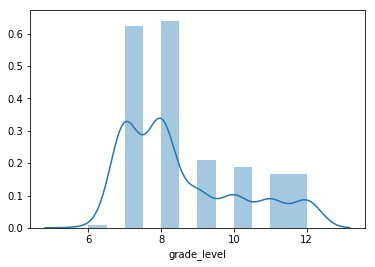

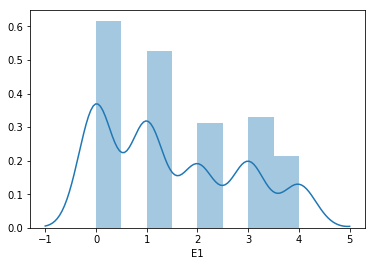

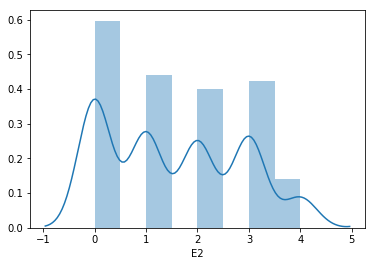

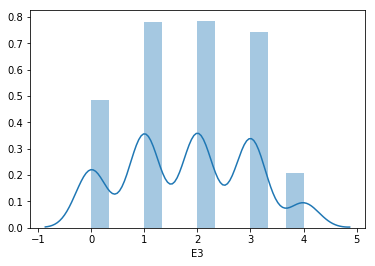

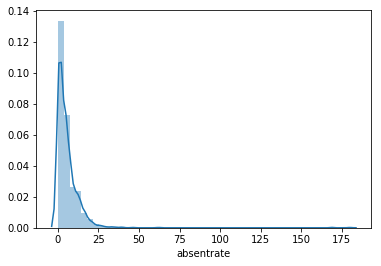

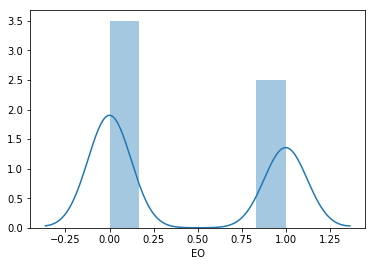

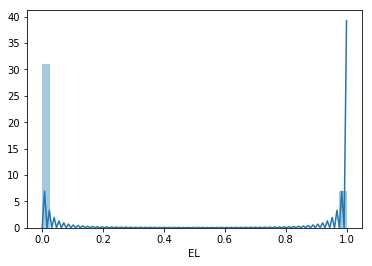

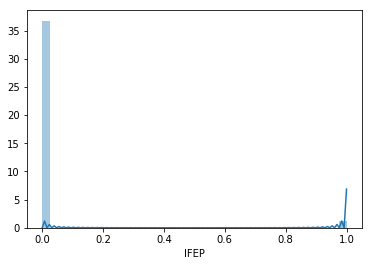

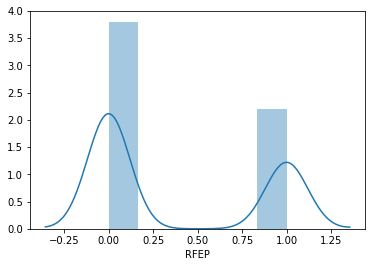

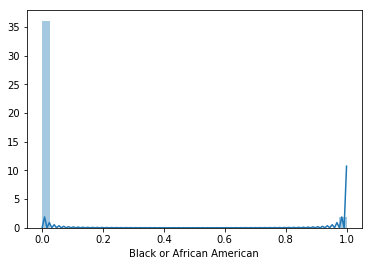

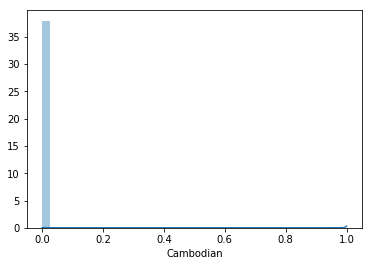

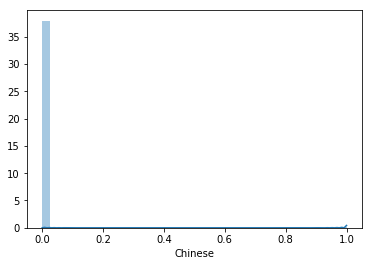

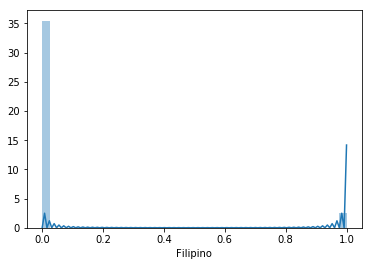

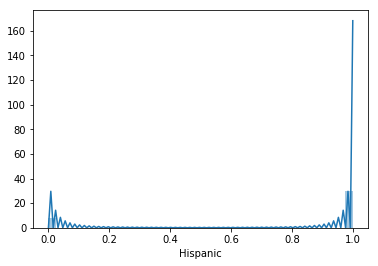

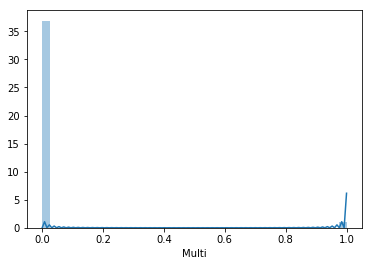

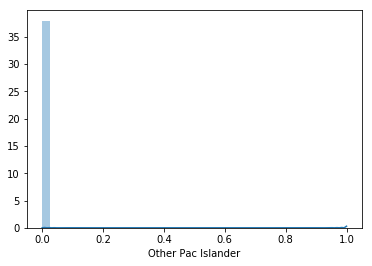

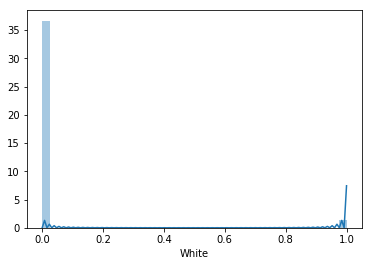

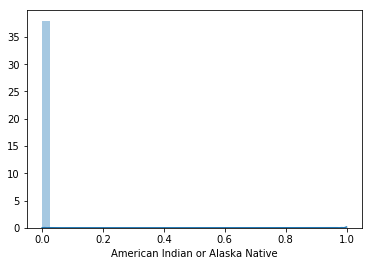

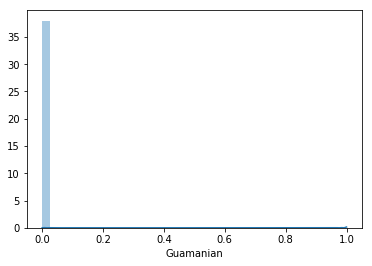

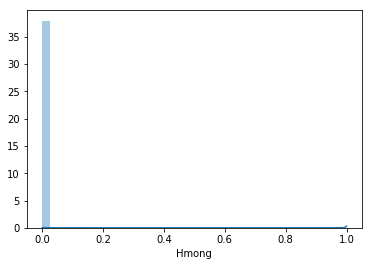

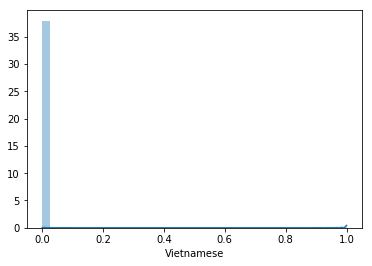

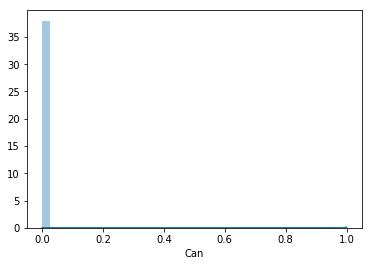

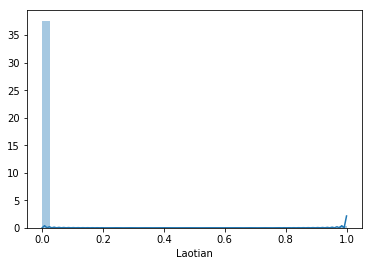

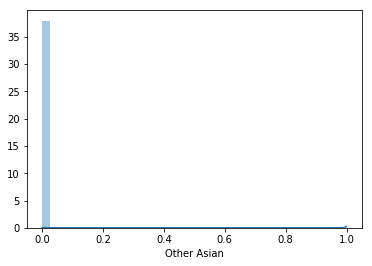

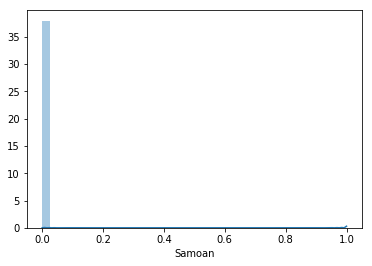

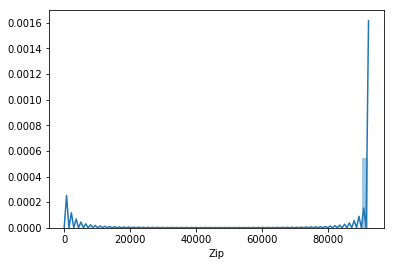

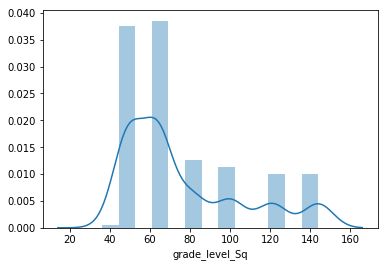

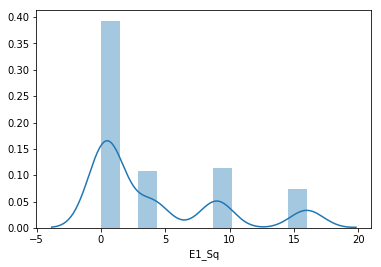

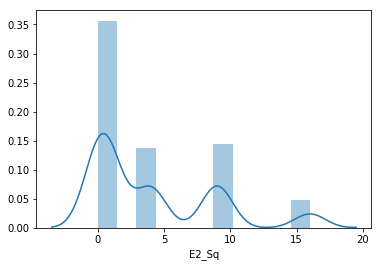

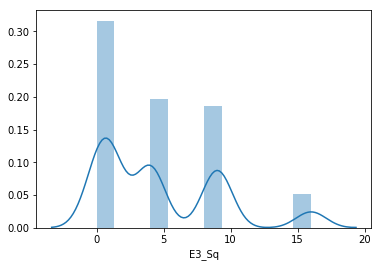

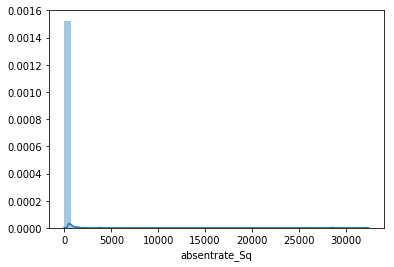

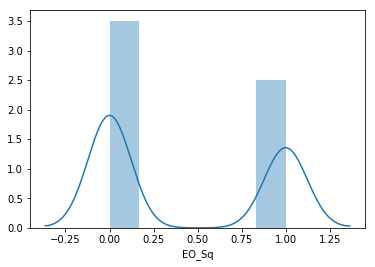

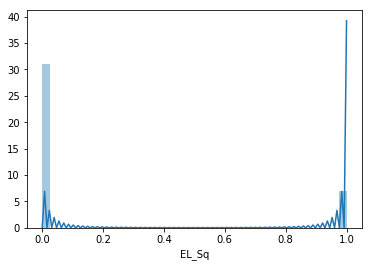

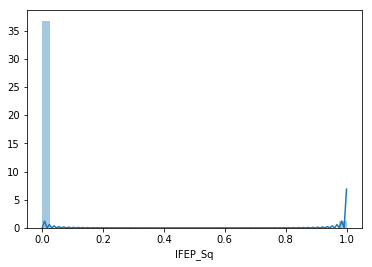

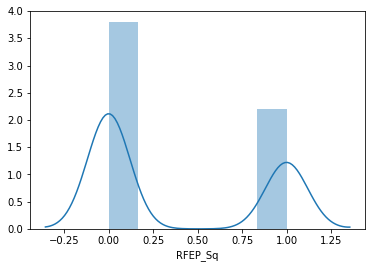

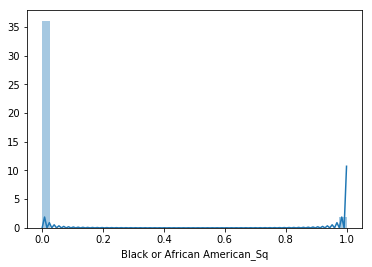

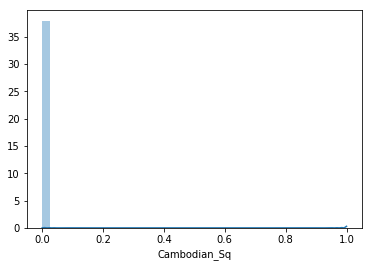

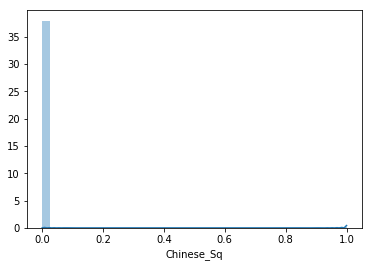

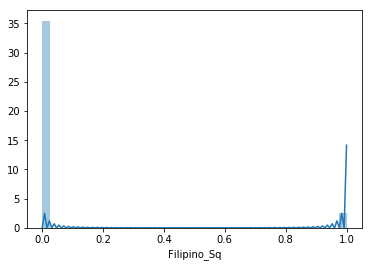

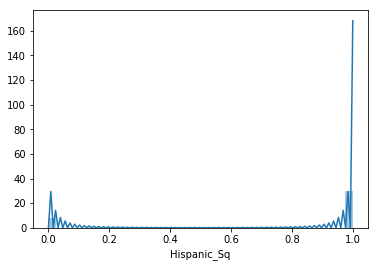

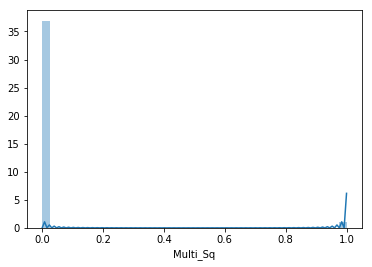

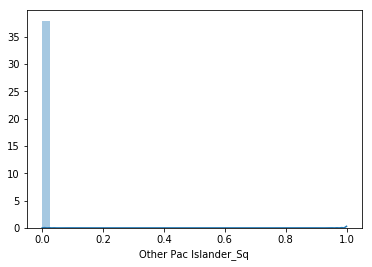

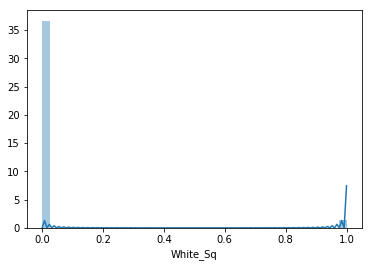

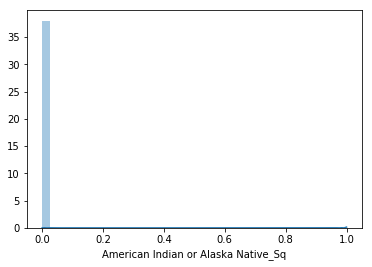

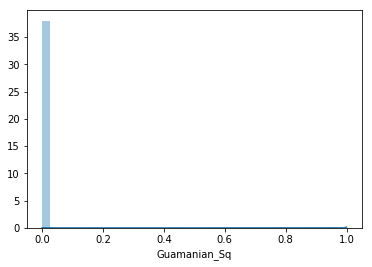

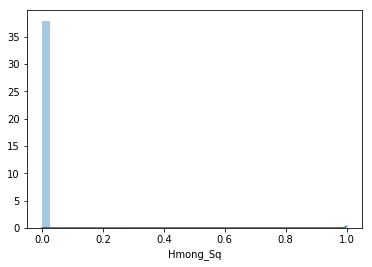

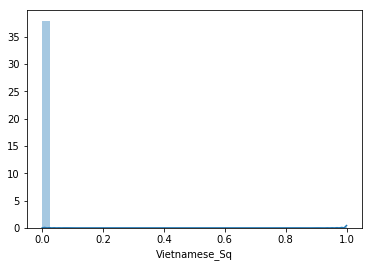

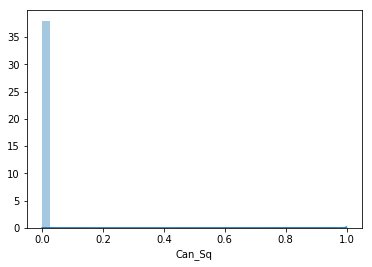

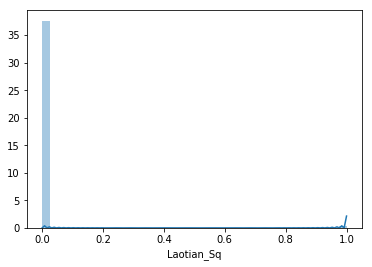

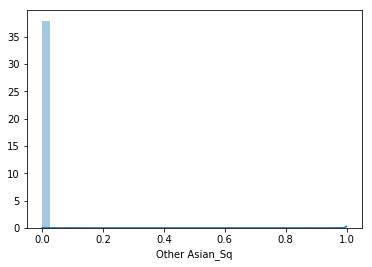

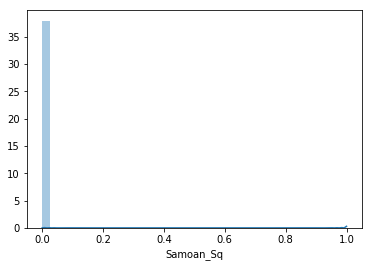

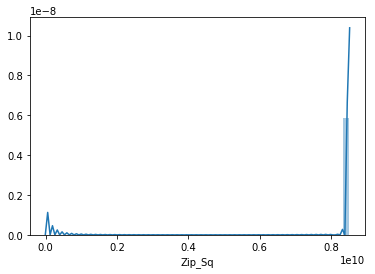

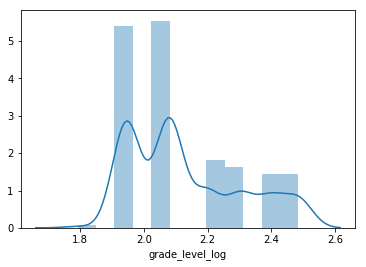

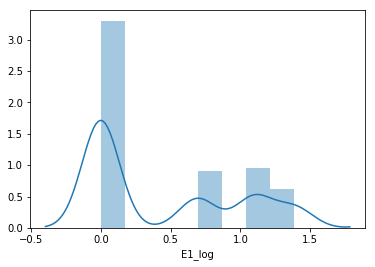

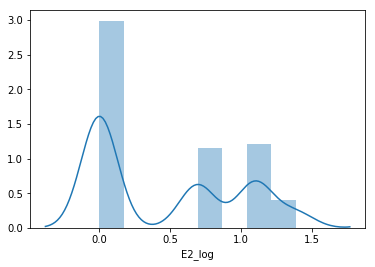

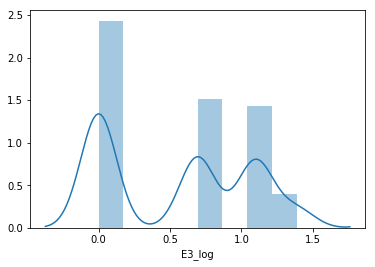

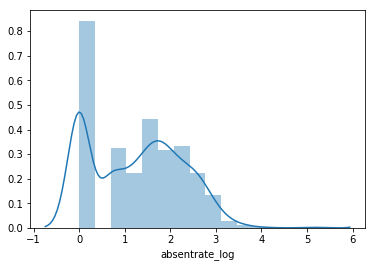

c:\users\sakok\miniconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
c:\users\sakok\miniconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


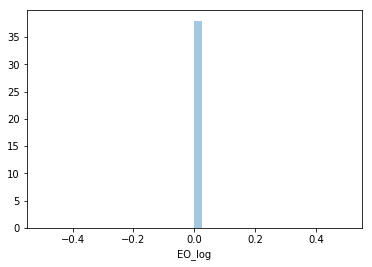

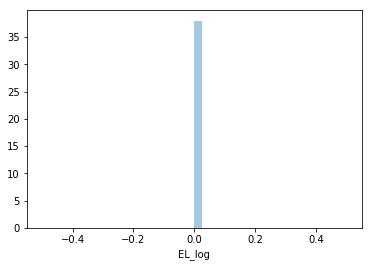

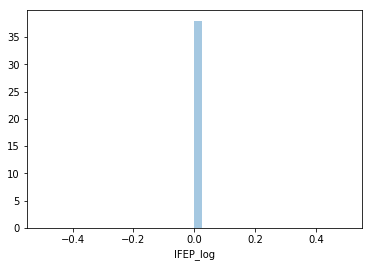

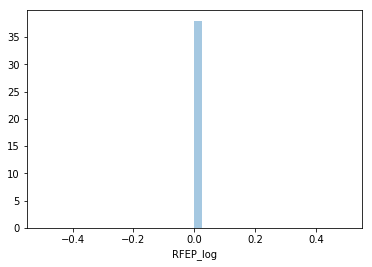

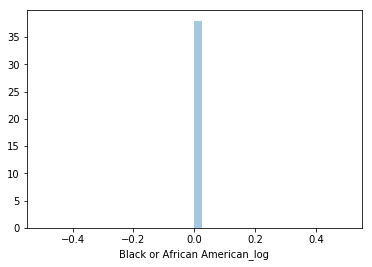

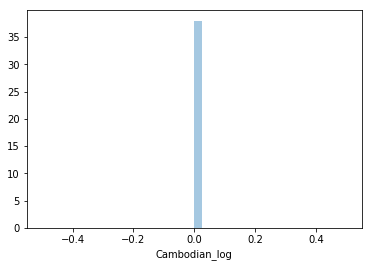

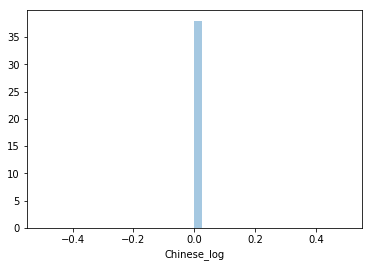

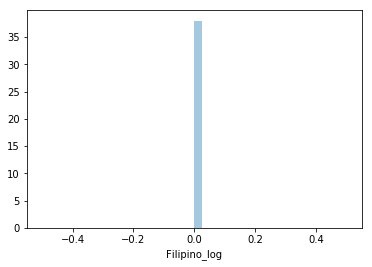

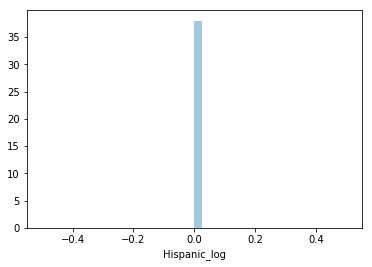

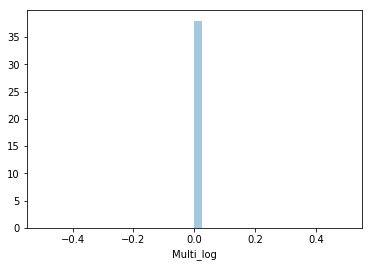

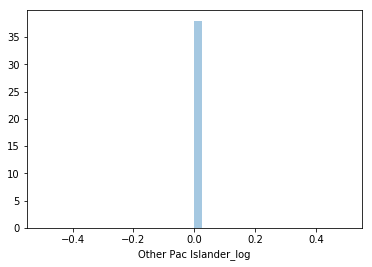

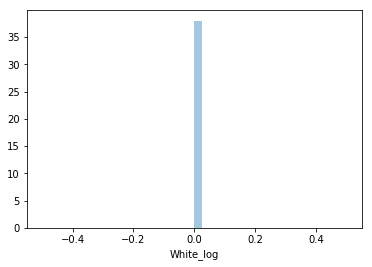

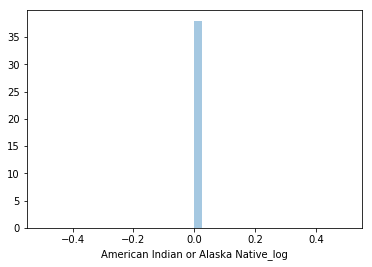

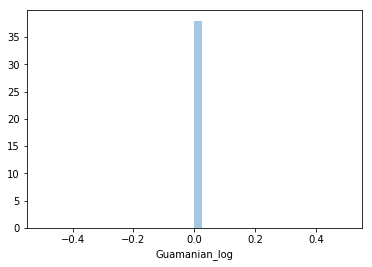

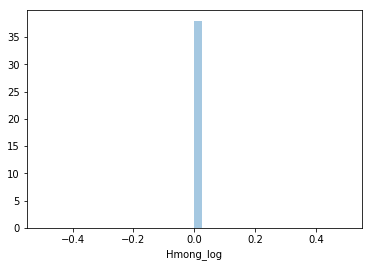

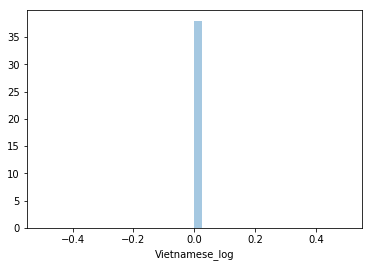

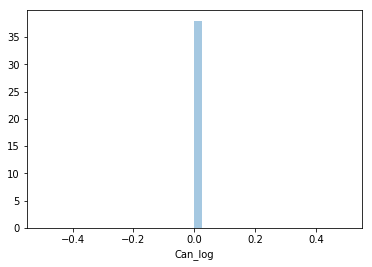

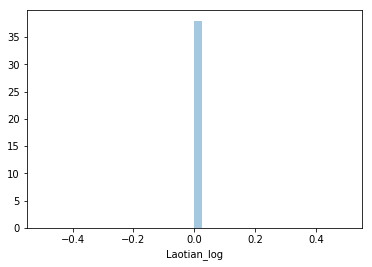

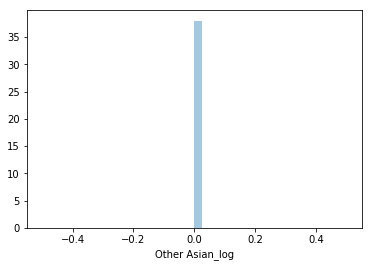

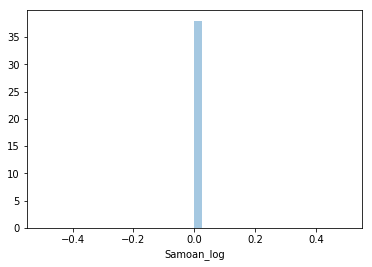

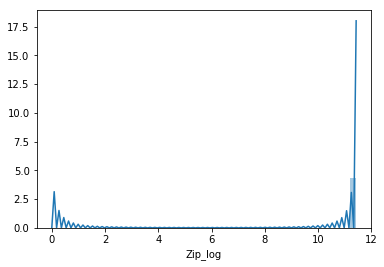

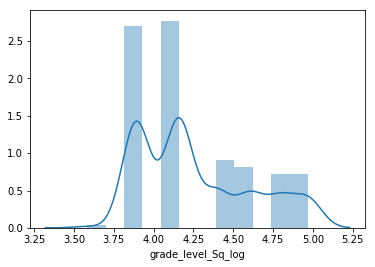

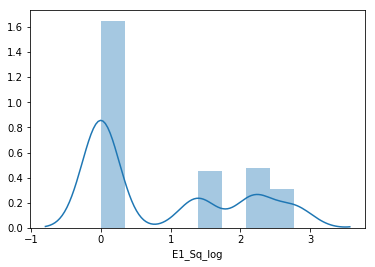

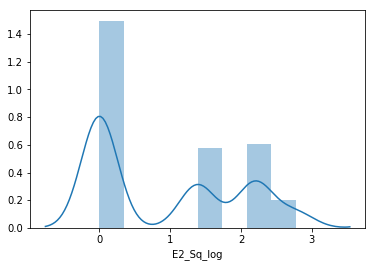

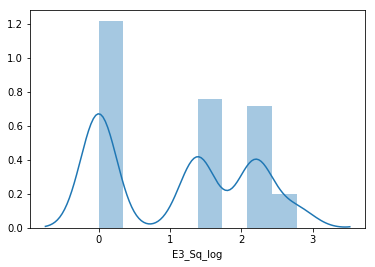

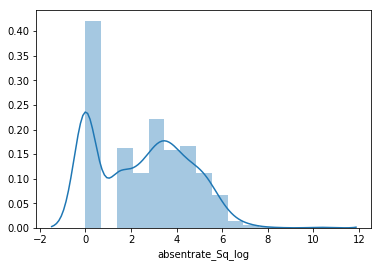

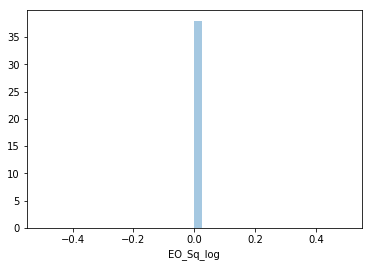

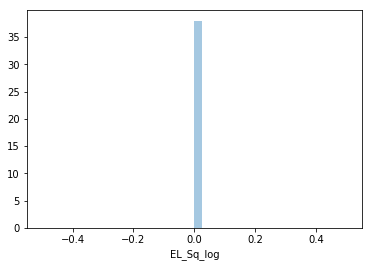

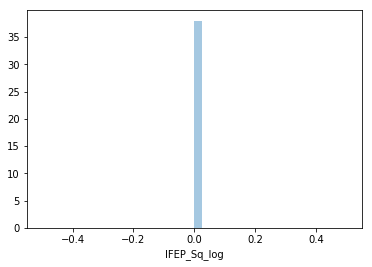

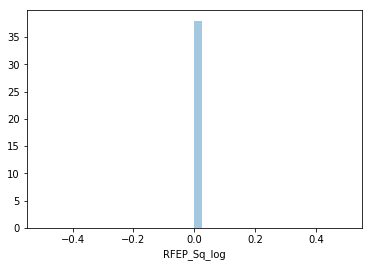

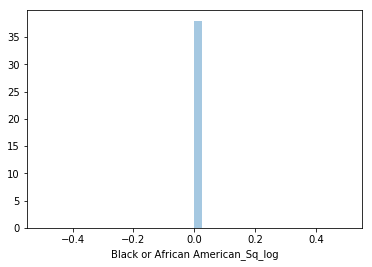

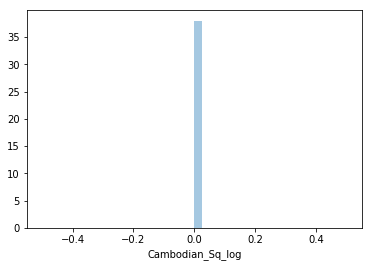

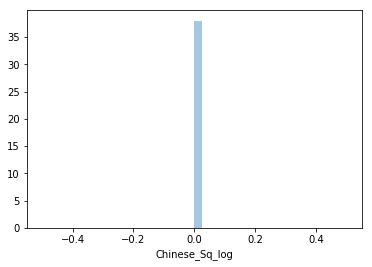

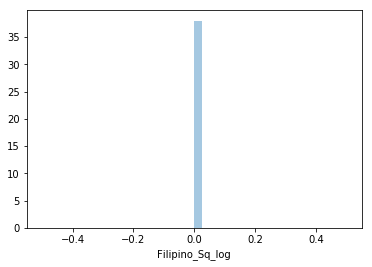

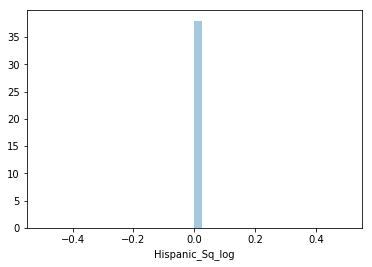

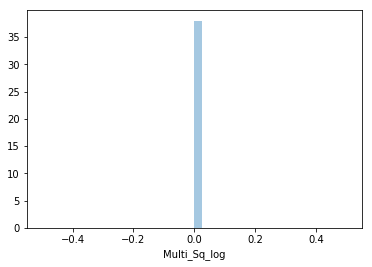

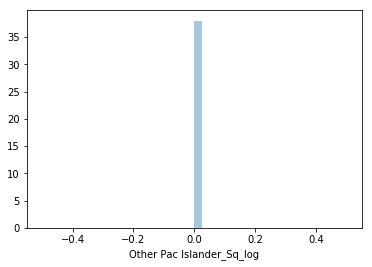

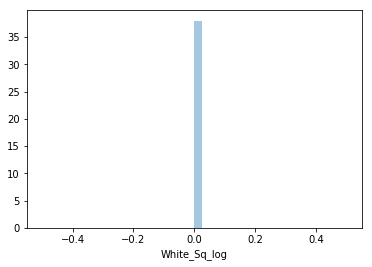

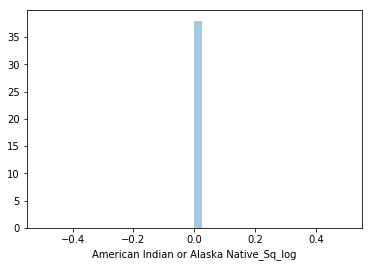

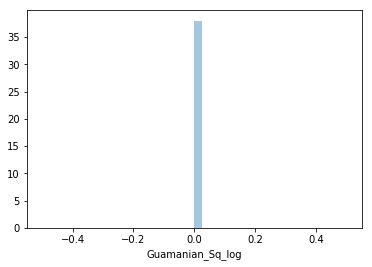

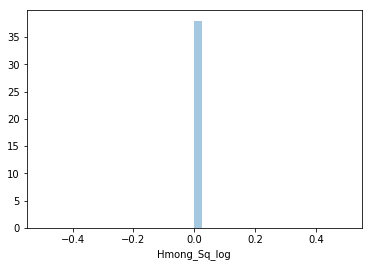

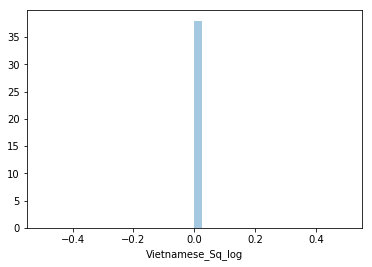

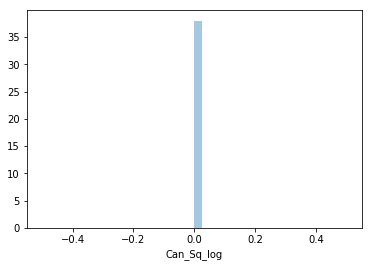

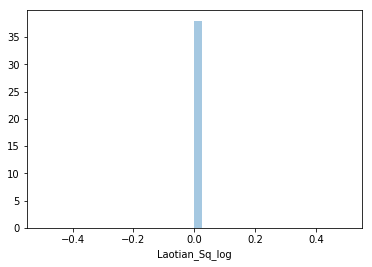

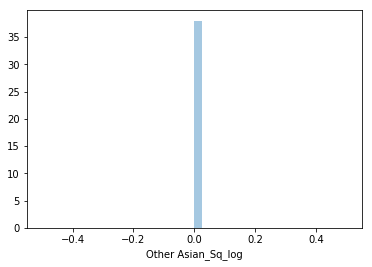

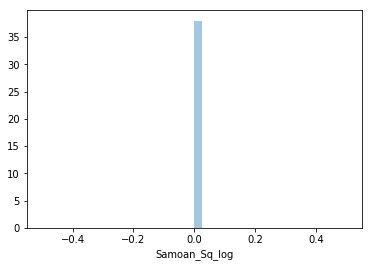

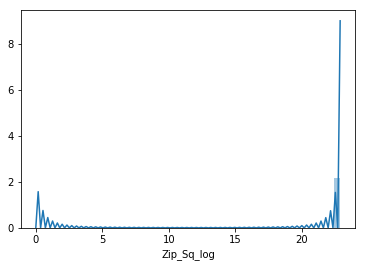

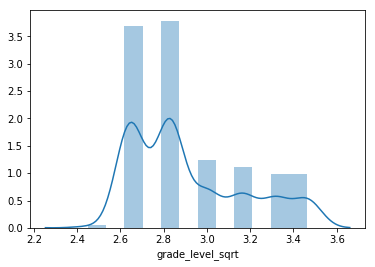

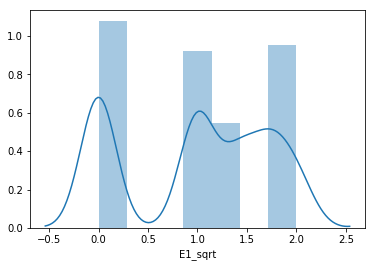

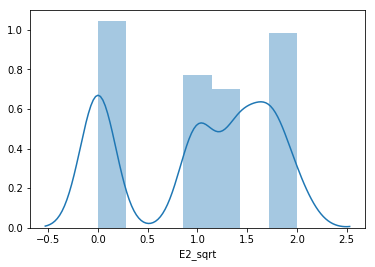

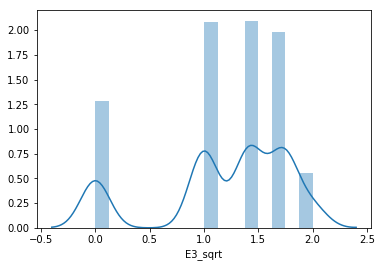

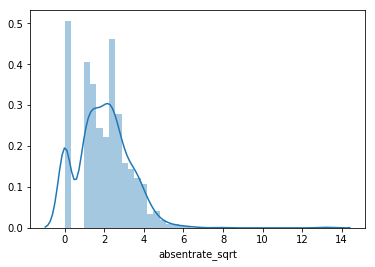

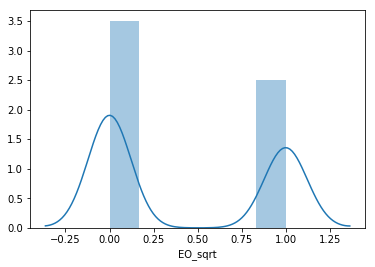

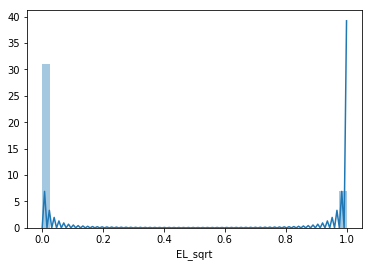

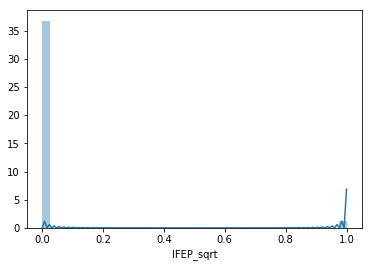

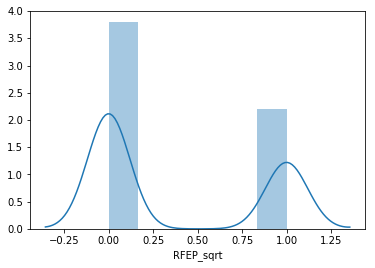

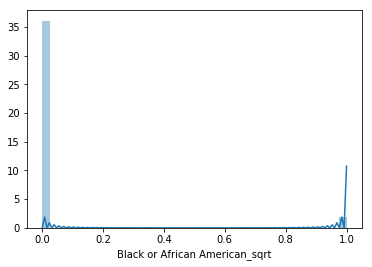

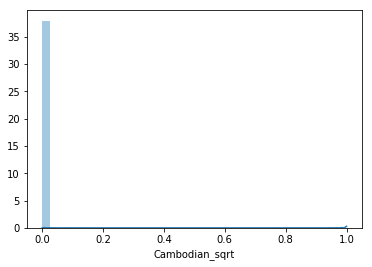

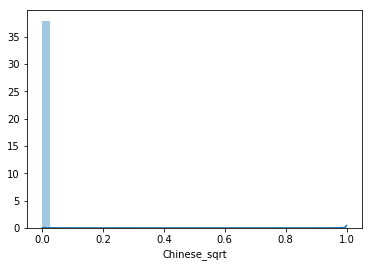

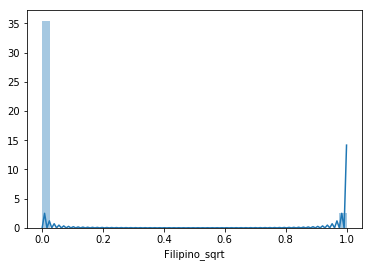

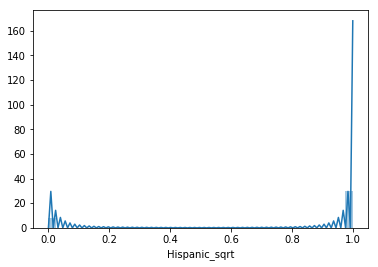

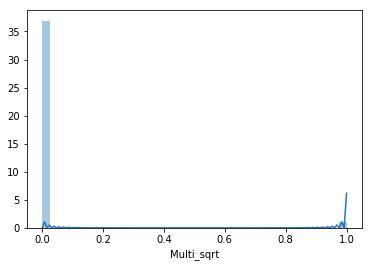

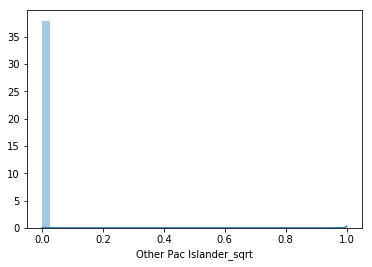

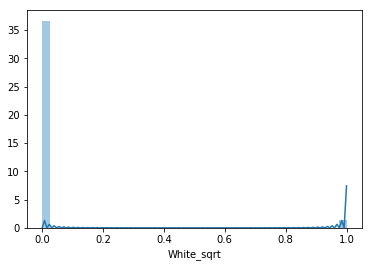

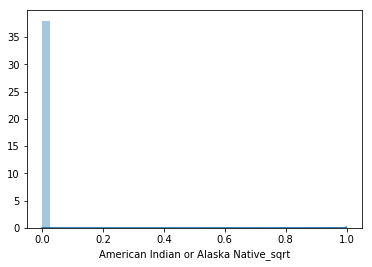

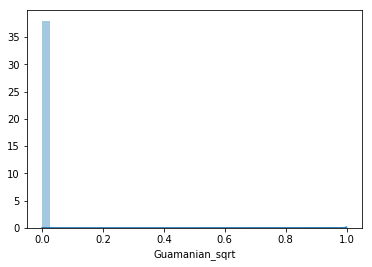

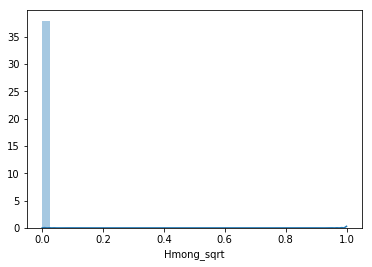

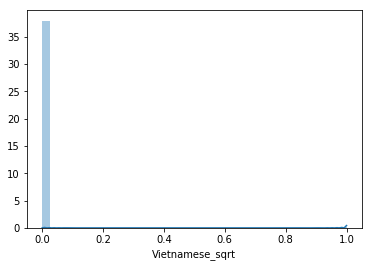

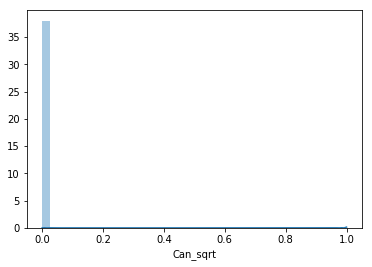

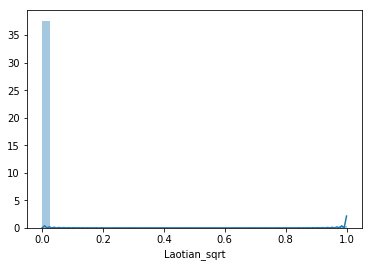

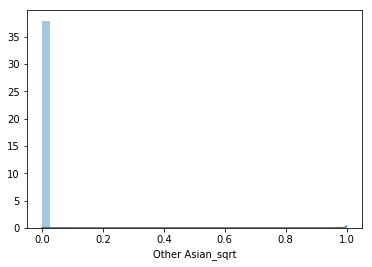

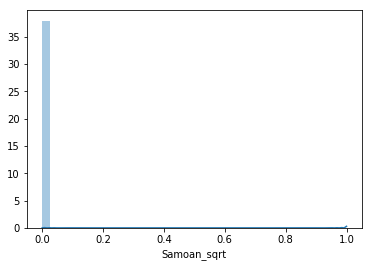

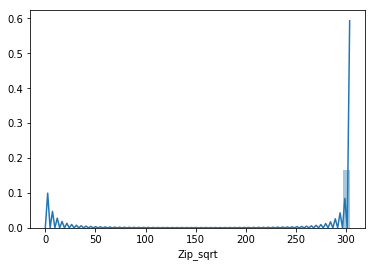

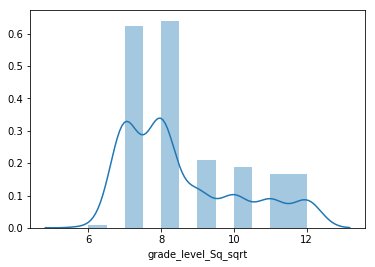

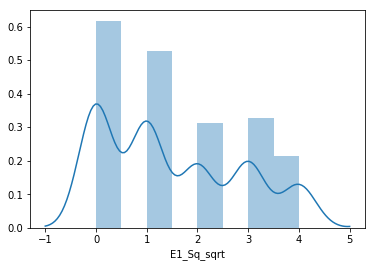

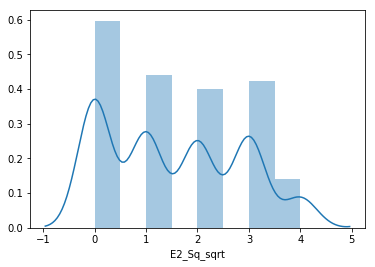

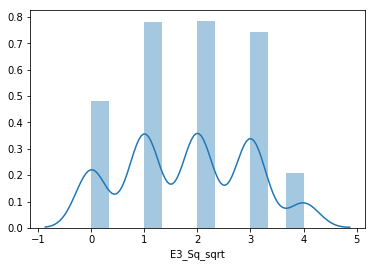

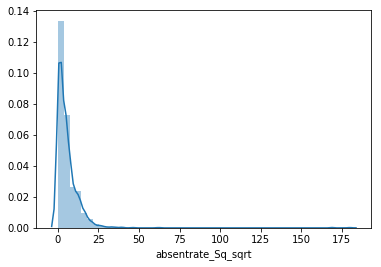

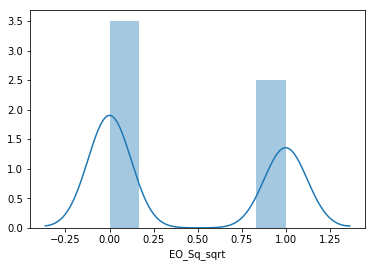

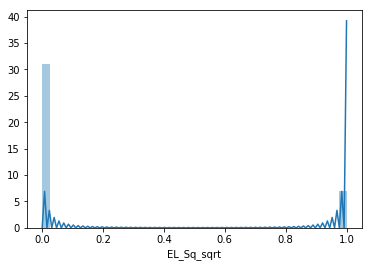

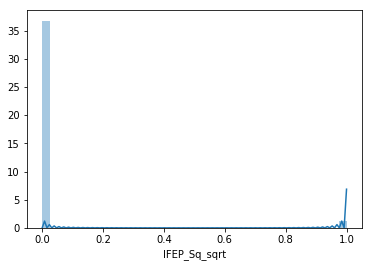

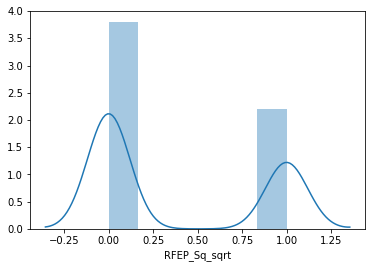

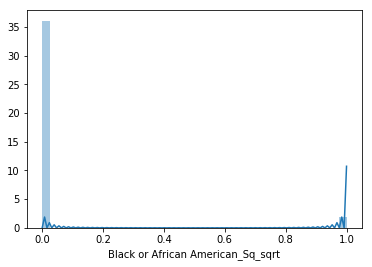

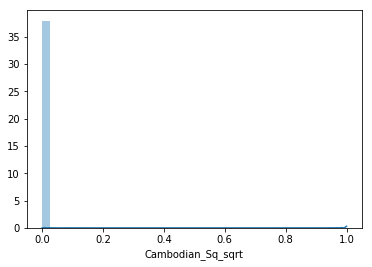

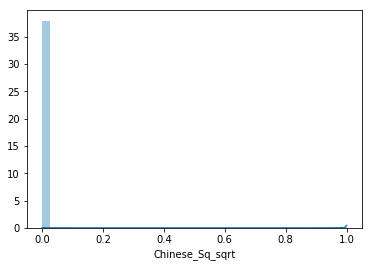

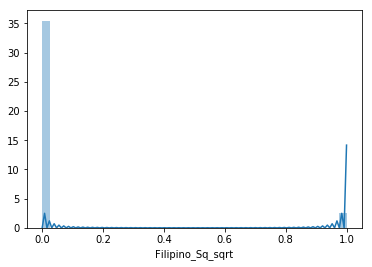

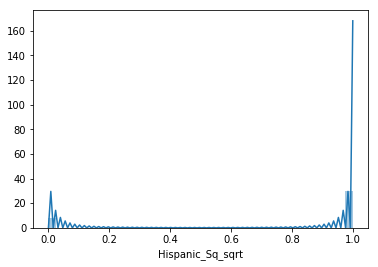

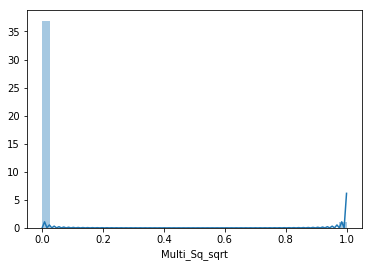

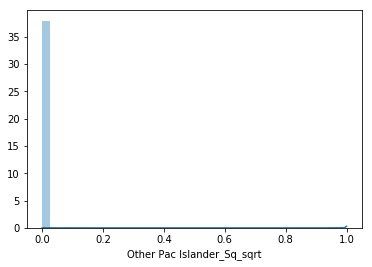

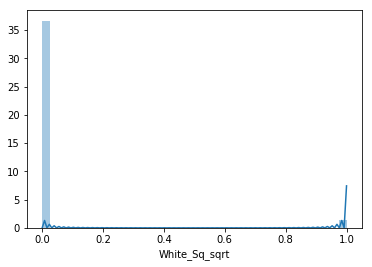

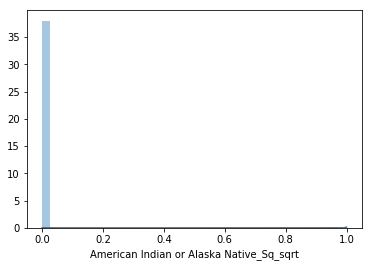

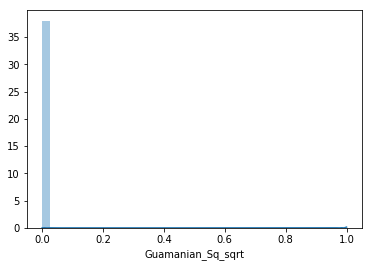

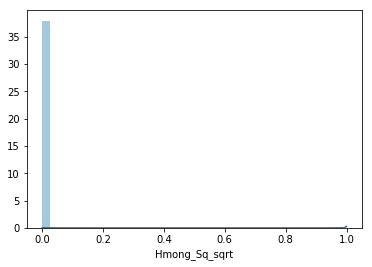

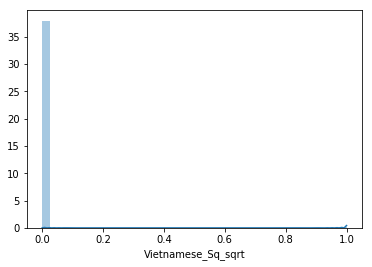

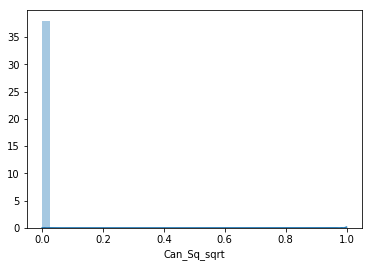

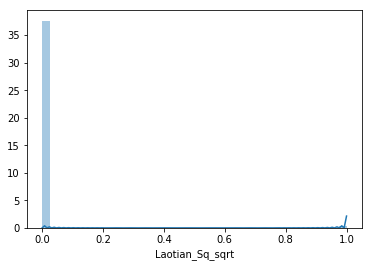

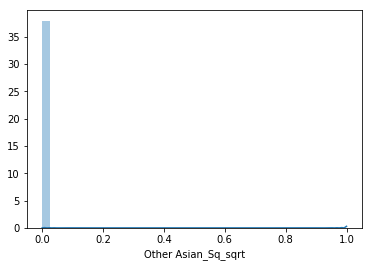

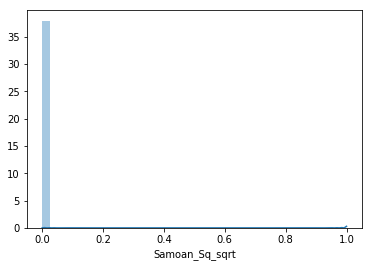

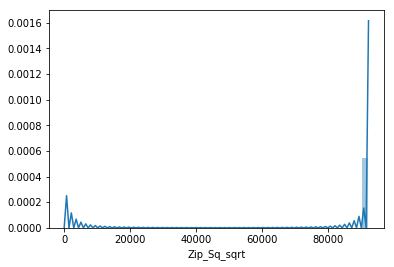

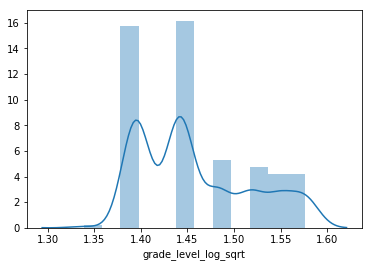

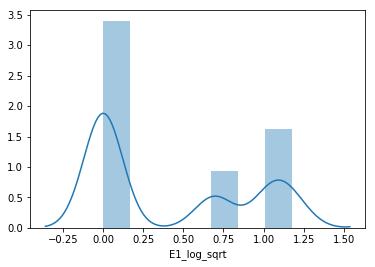

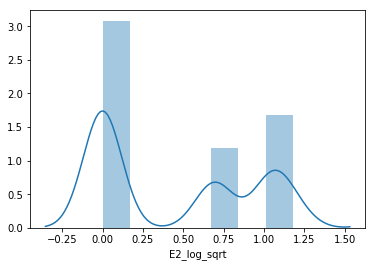

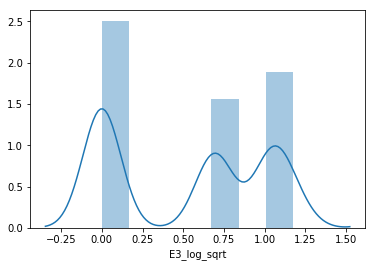

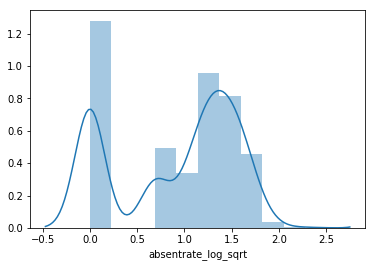

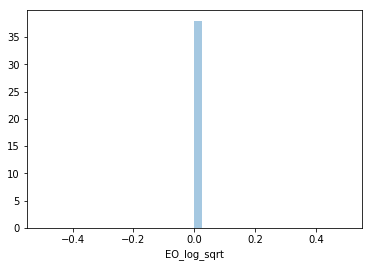

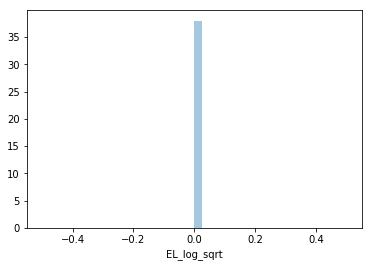

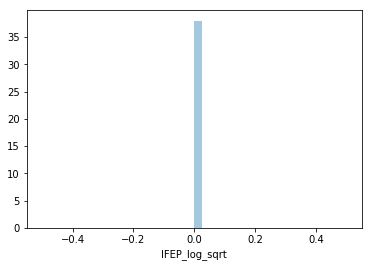

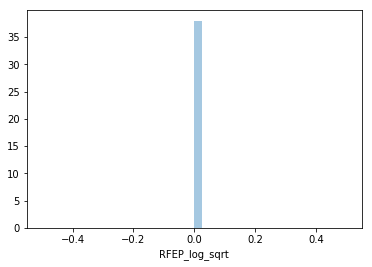

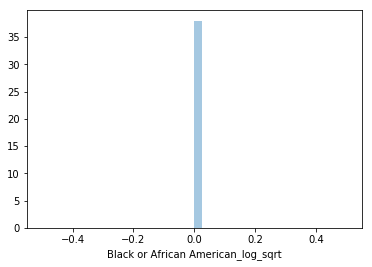

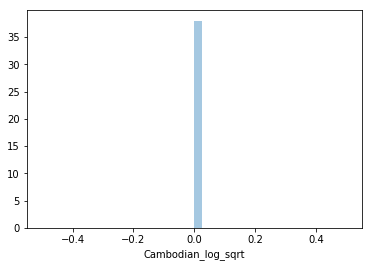

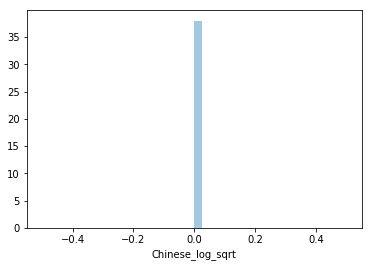

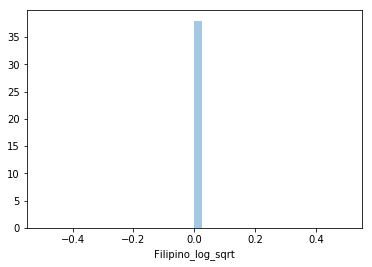

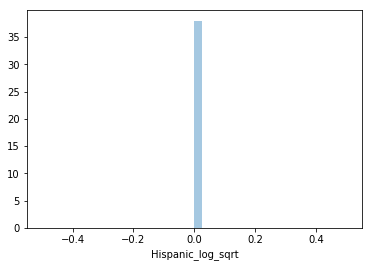

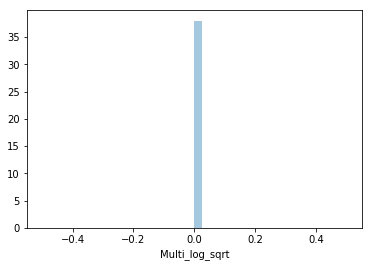

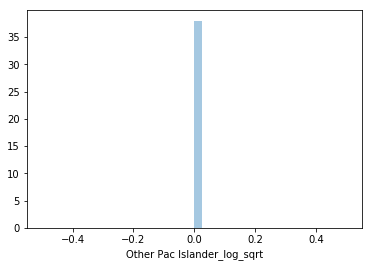

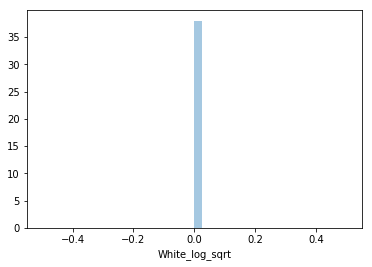

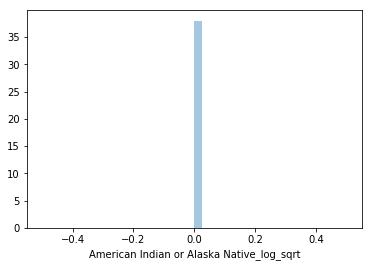

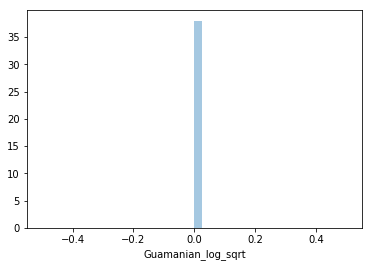

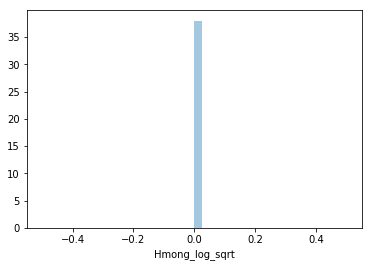

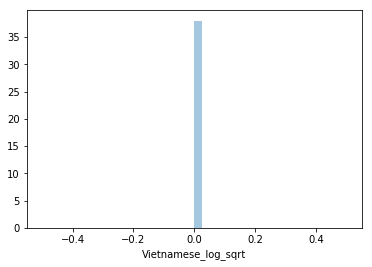

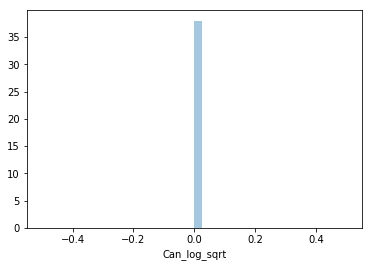

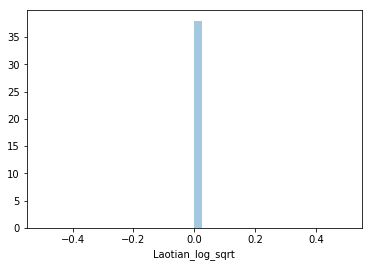

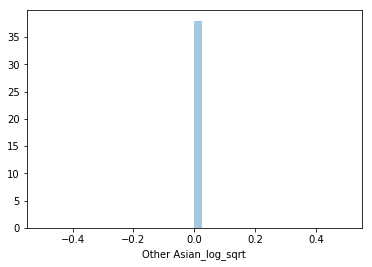

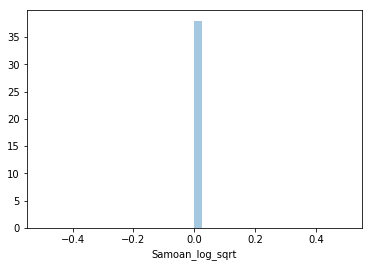

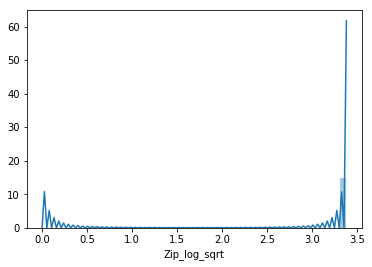

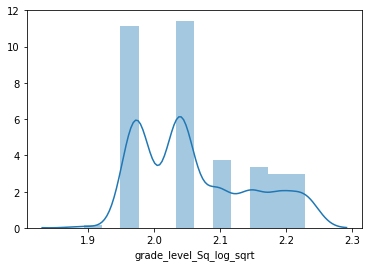

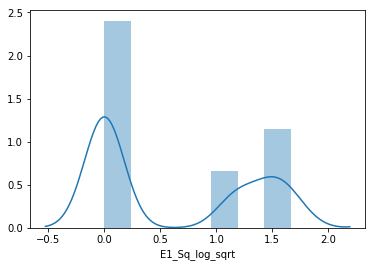

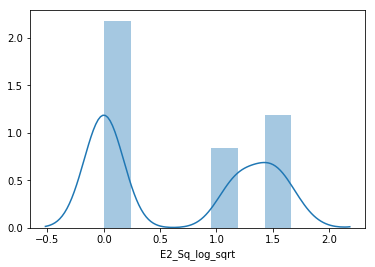

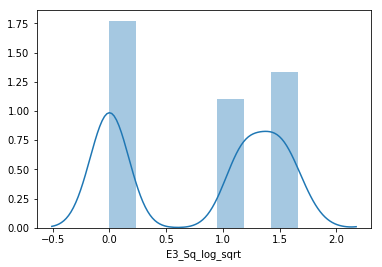

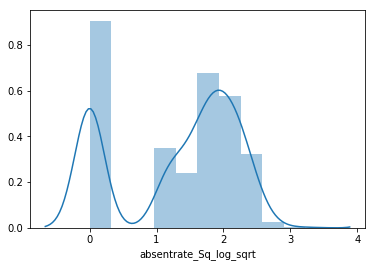

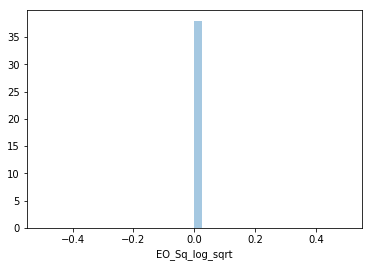

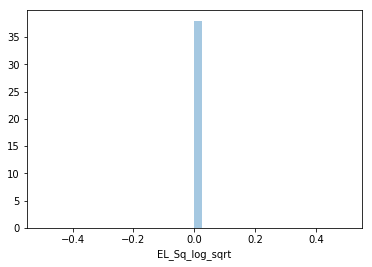

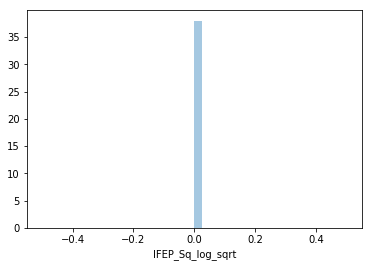

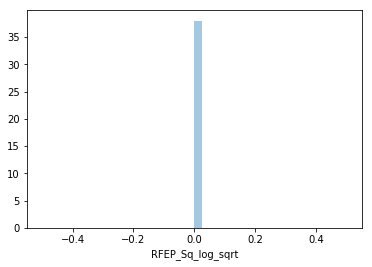

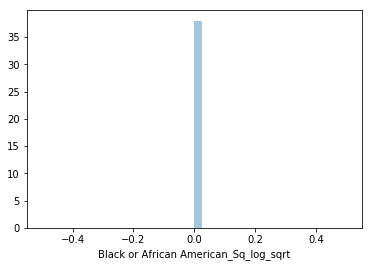

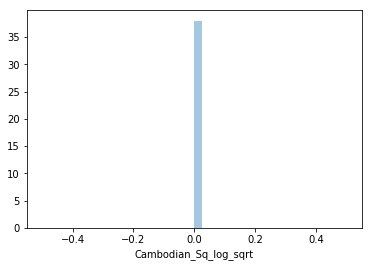

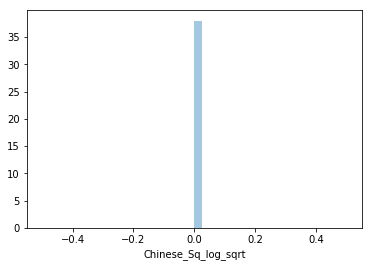

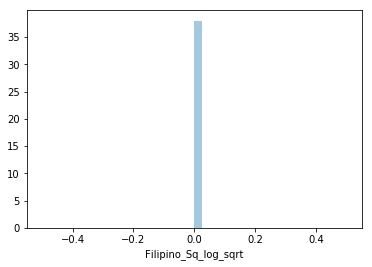

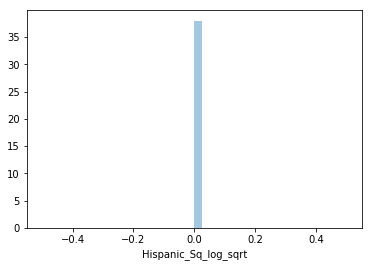

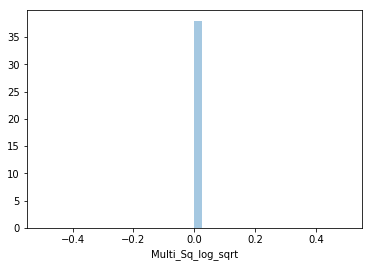

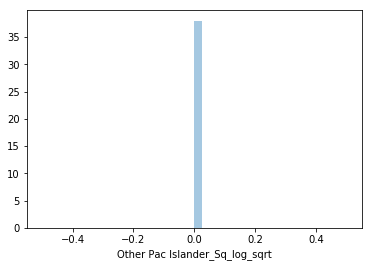

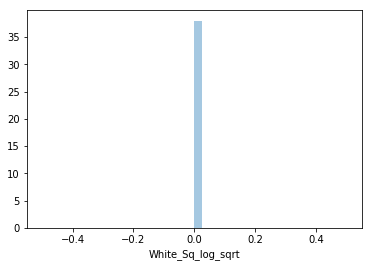

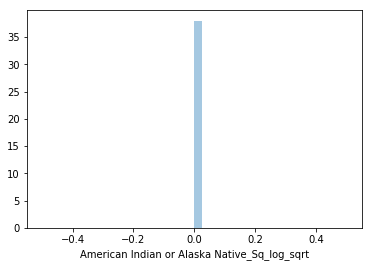

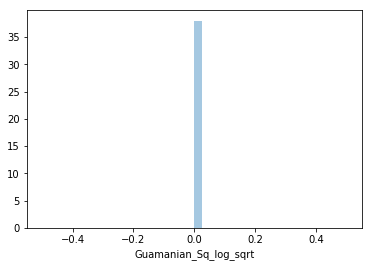

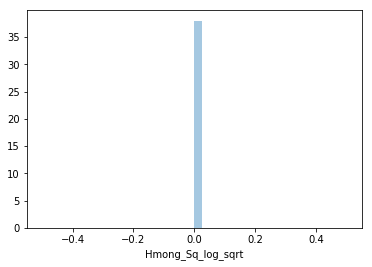

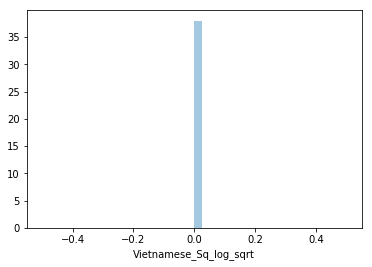

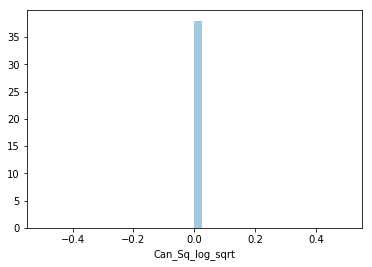

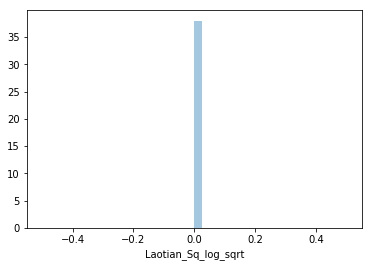

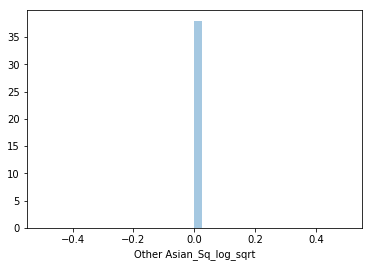

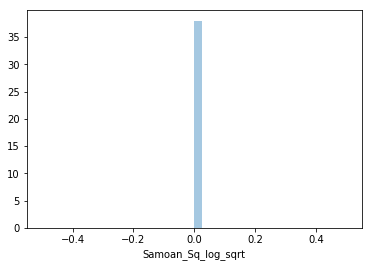

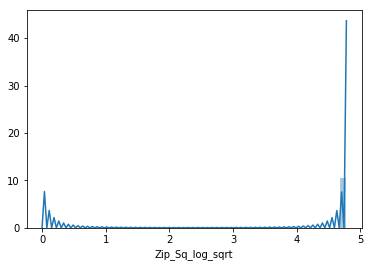

In [19]:
for x1 in X:
    sns.distplot(X[x1])
    plt.show()


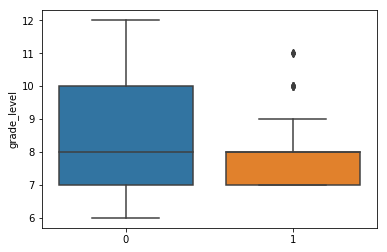

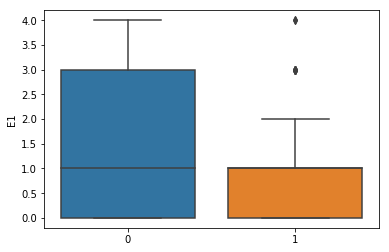

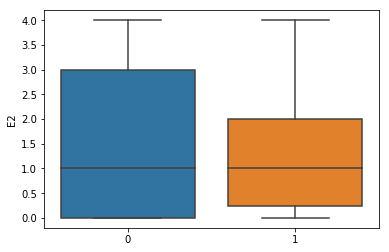

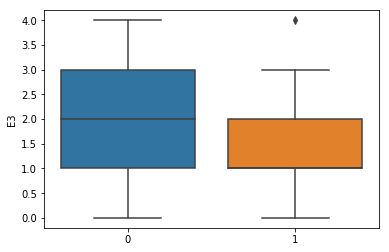

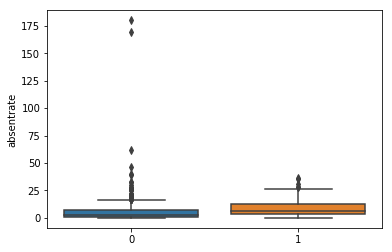

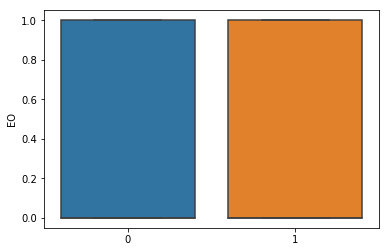

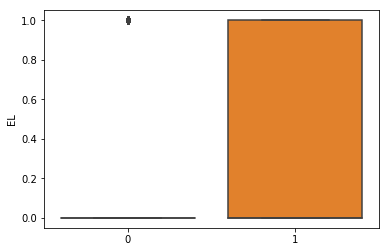

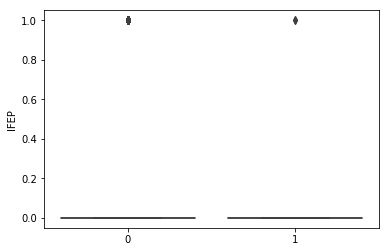

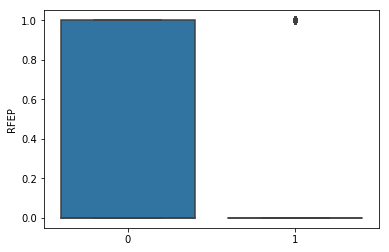

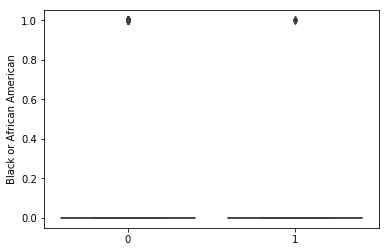

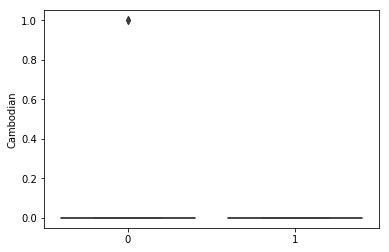

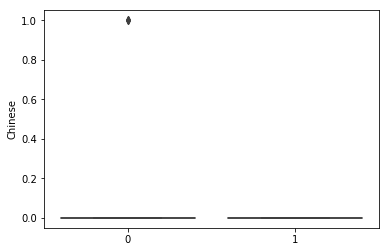

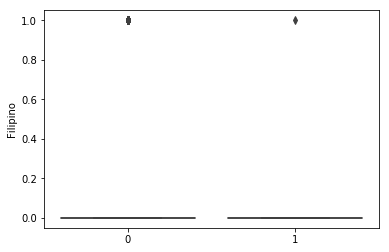

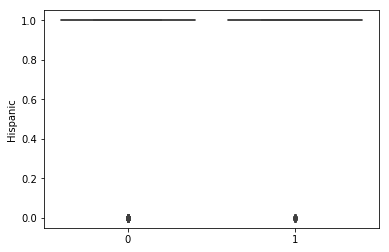

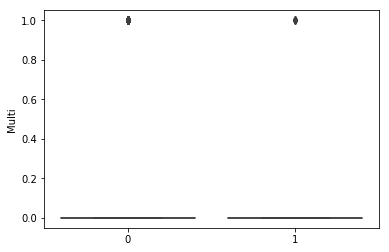

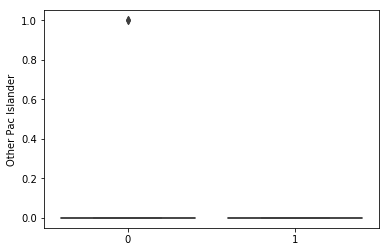

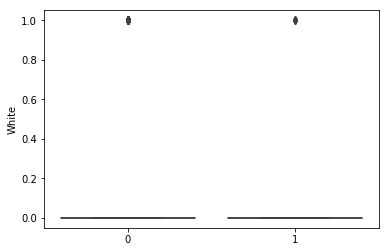

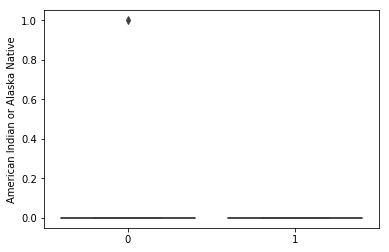

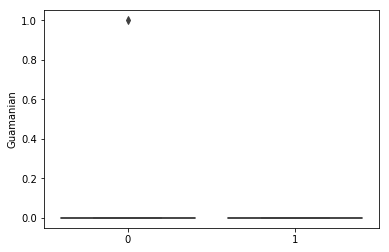

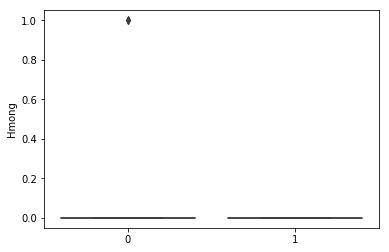

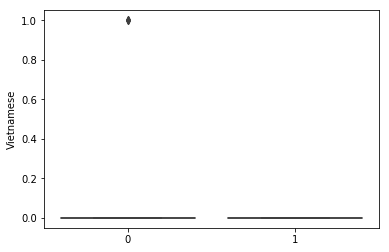

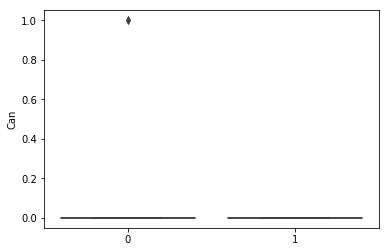

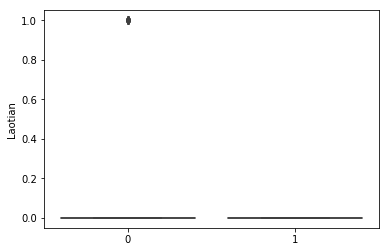

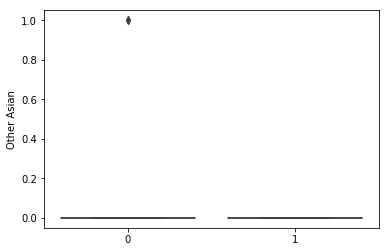

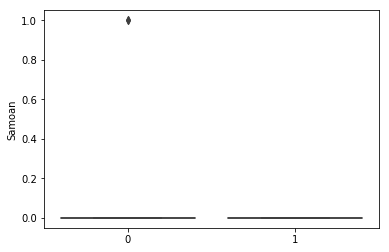

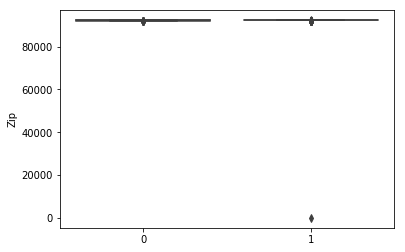

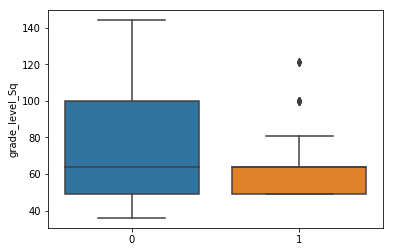

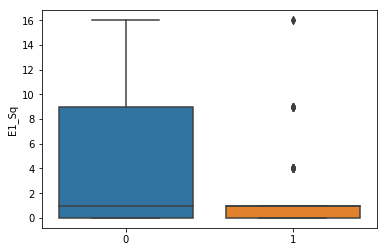

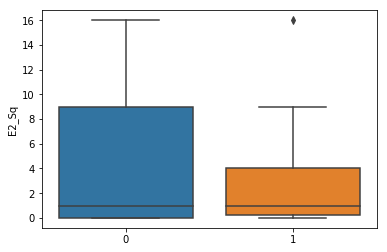

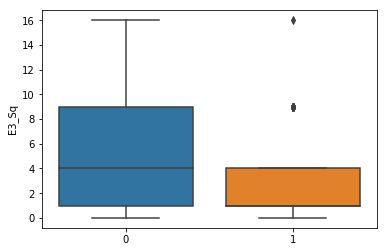

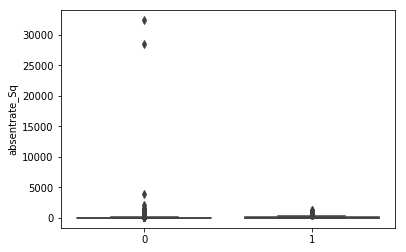

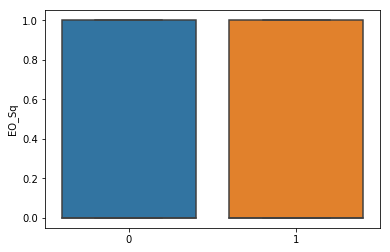

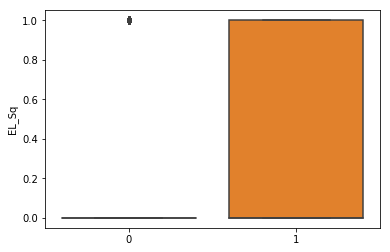

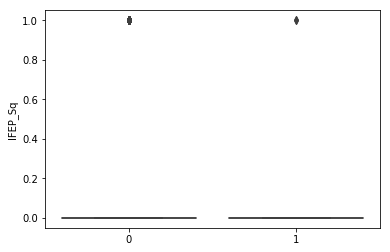

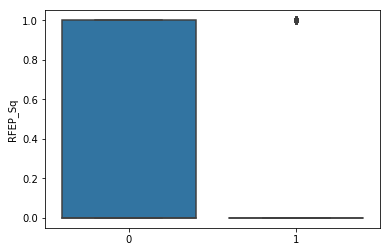

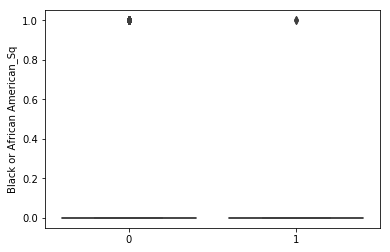

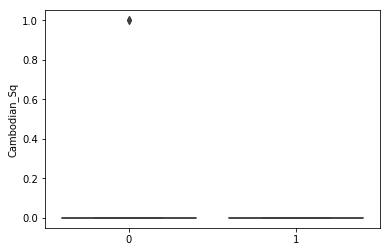

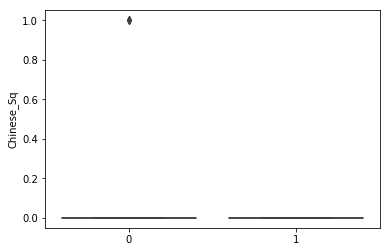

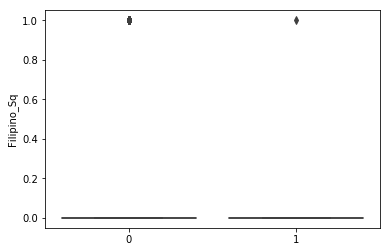

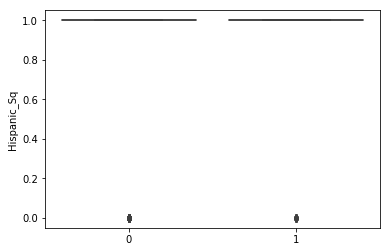

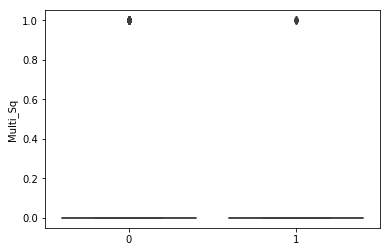

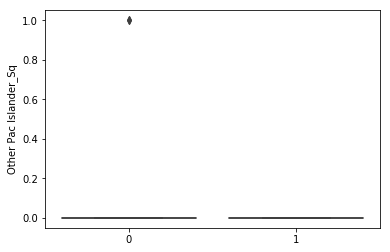

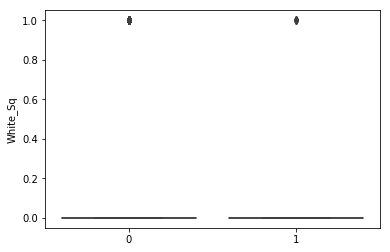

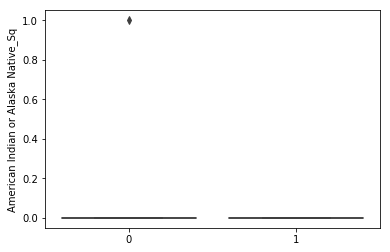

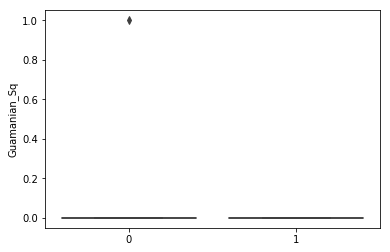

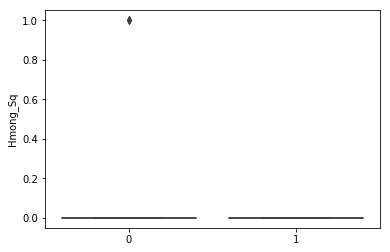

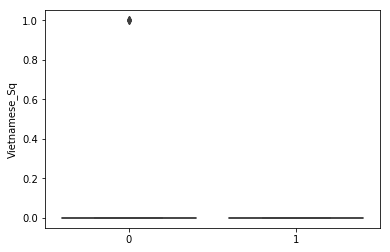

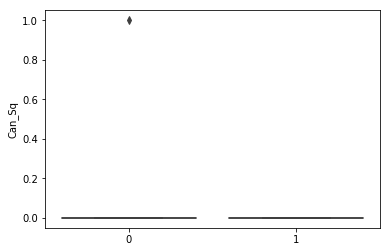

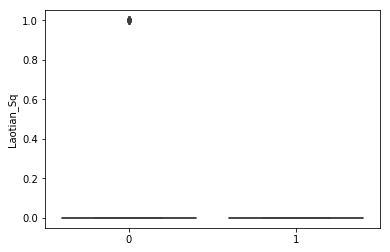

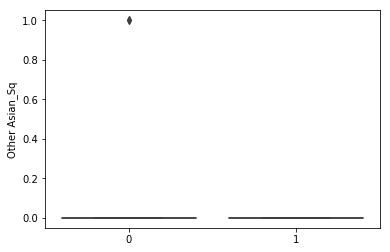

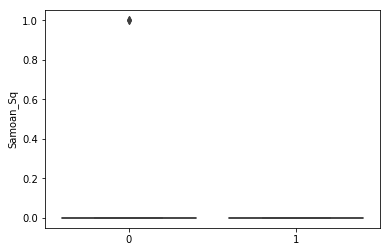

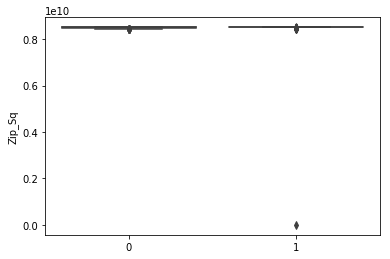

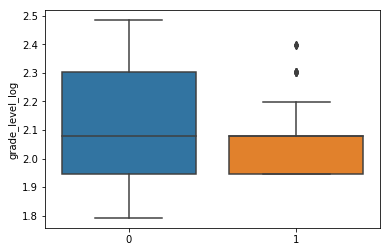

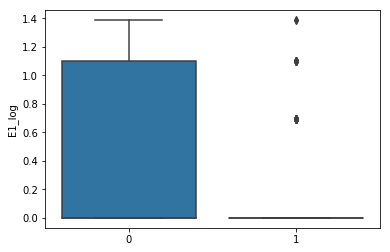

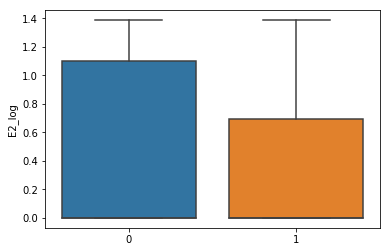

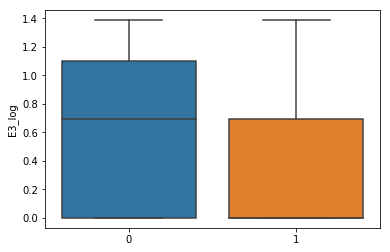

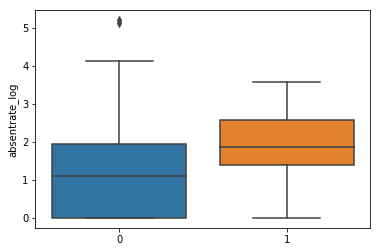

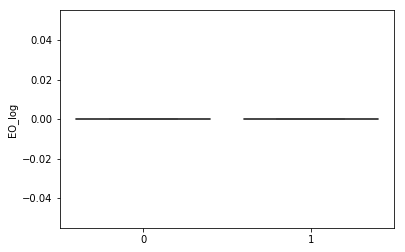

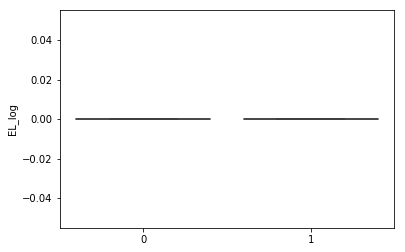

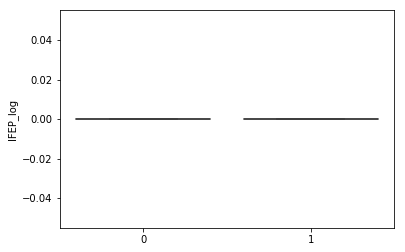

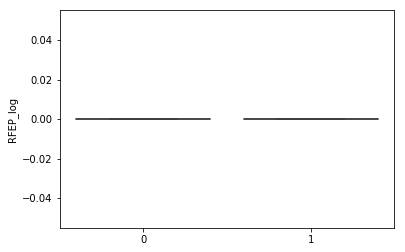

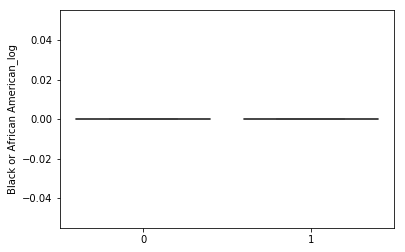

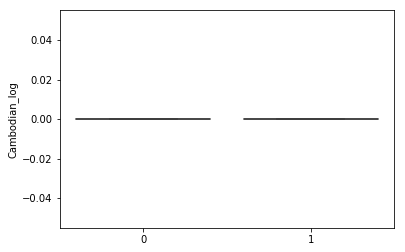

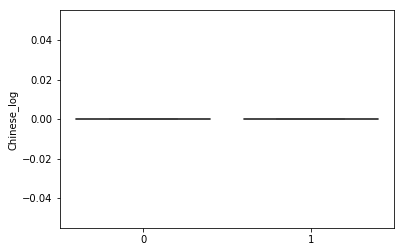

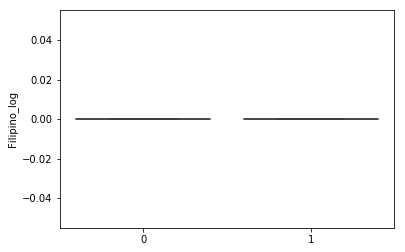

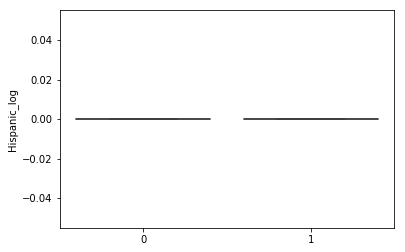

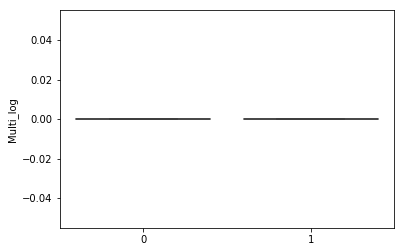

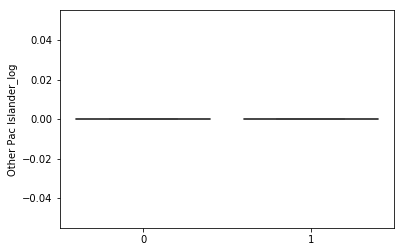

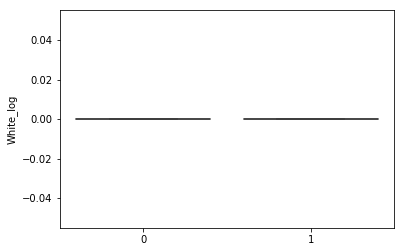

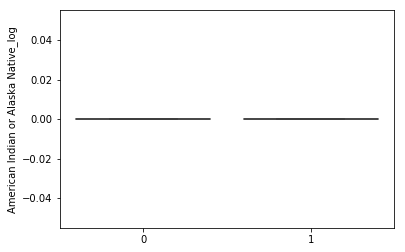

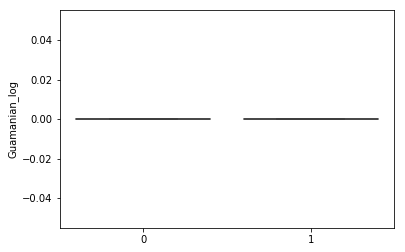

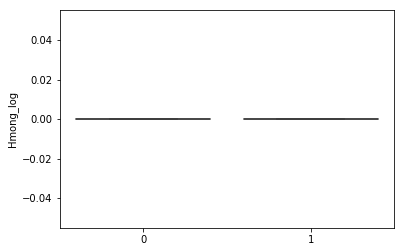

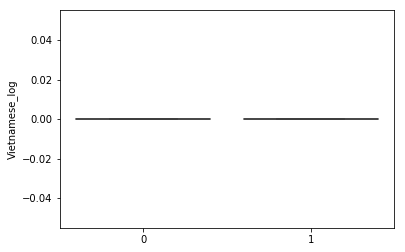

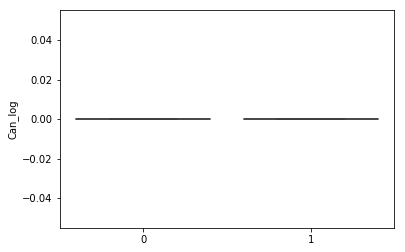

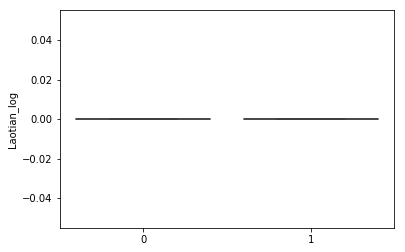

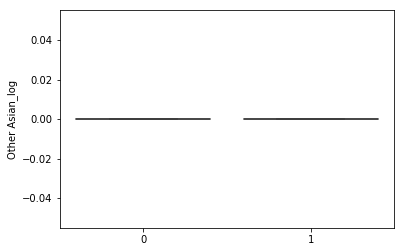

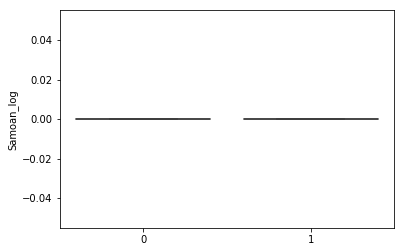

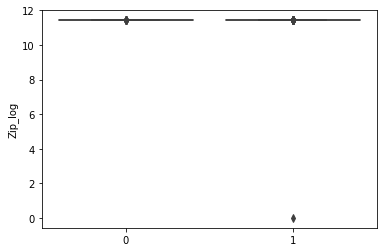

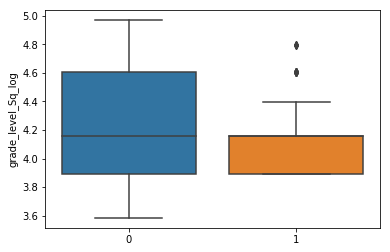

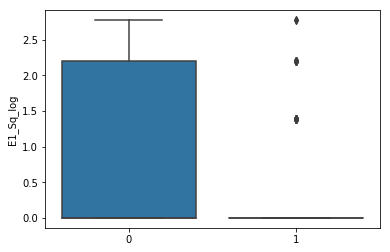

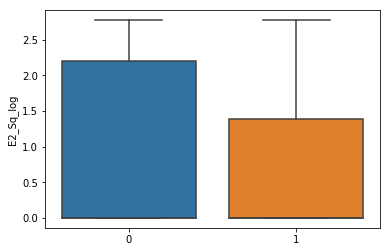

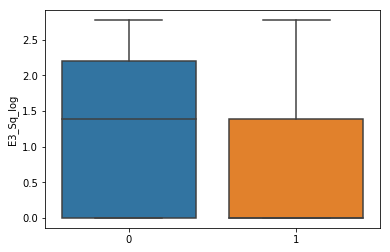

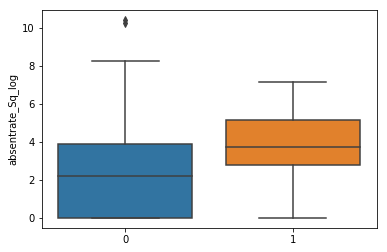

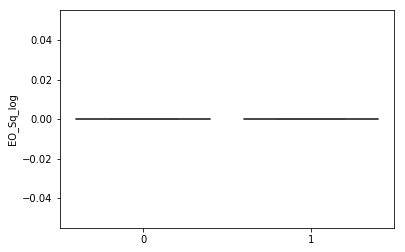

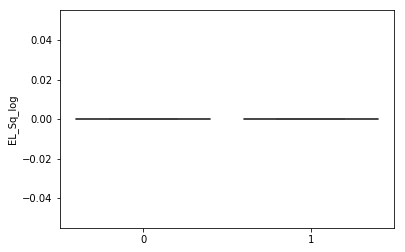

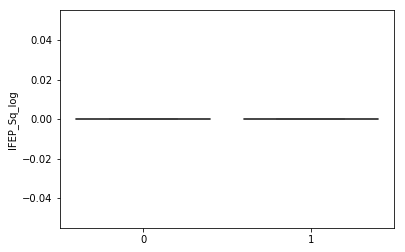

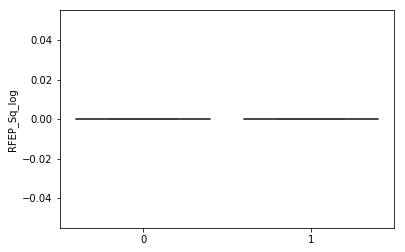

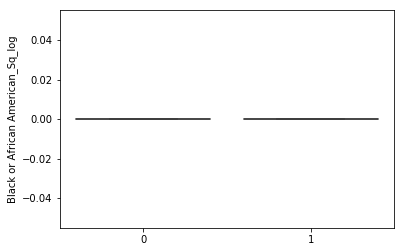

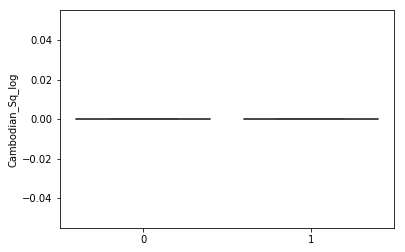

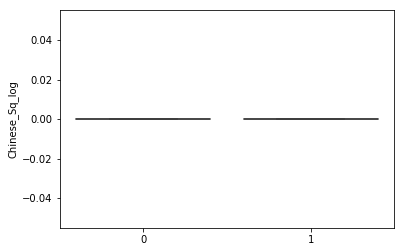

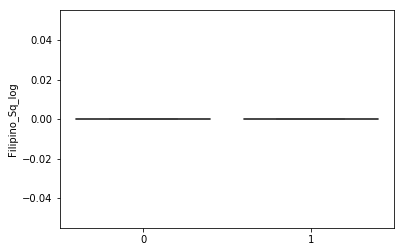

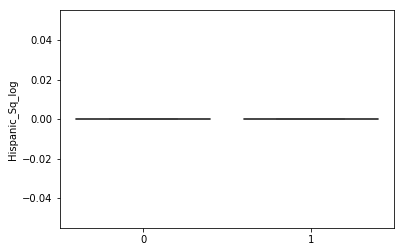

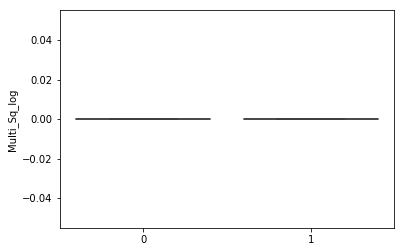

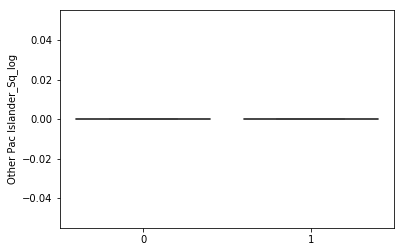

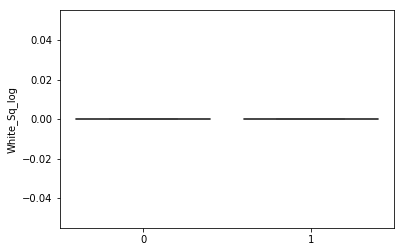

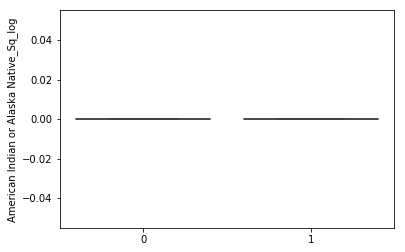

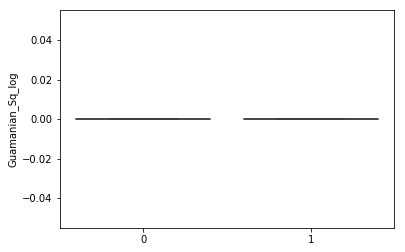

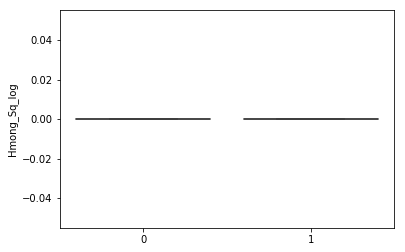

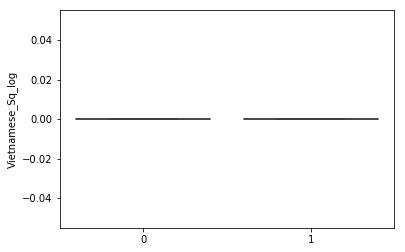

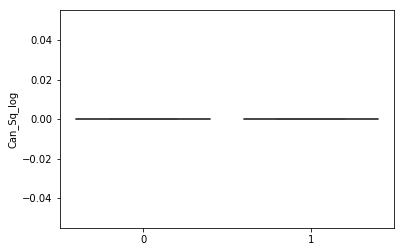

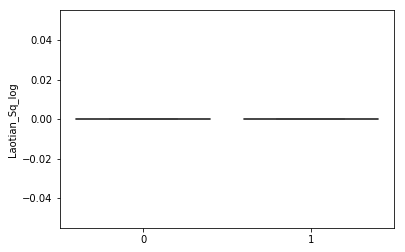

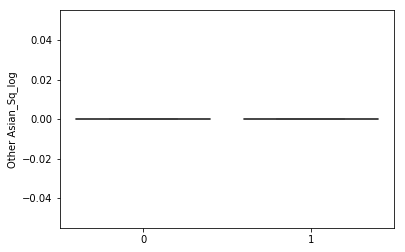

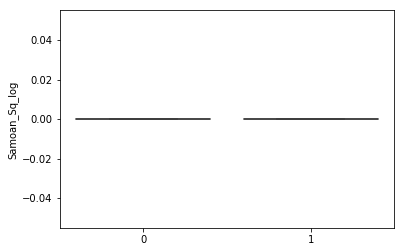

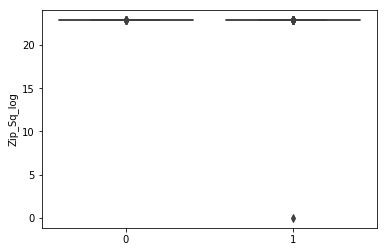

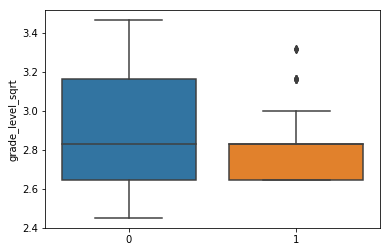

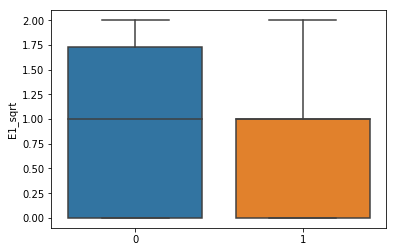

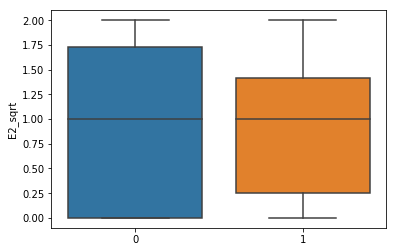

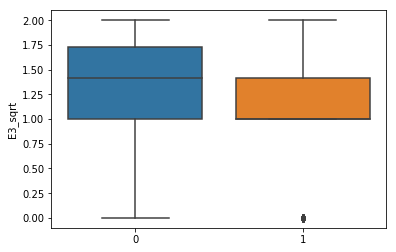

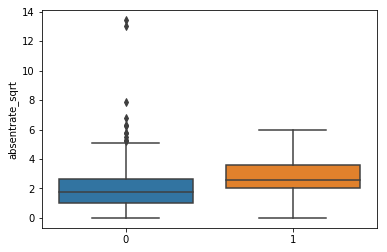

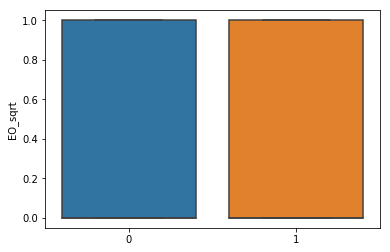

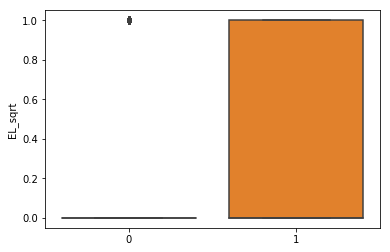

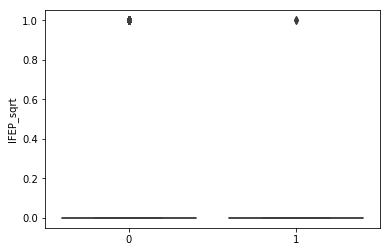

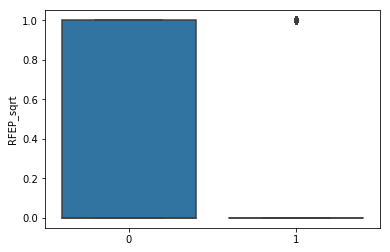

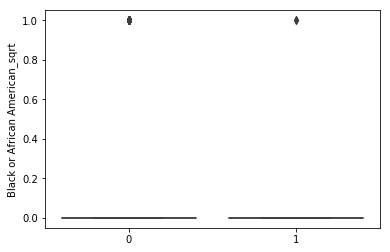

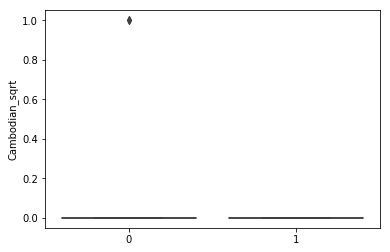

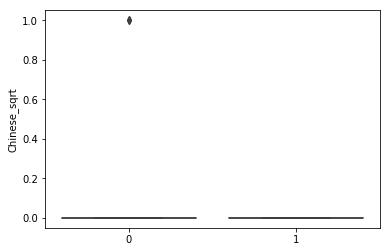

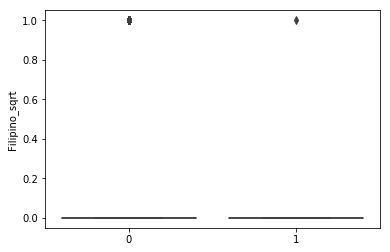

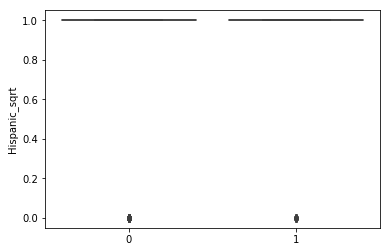

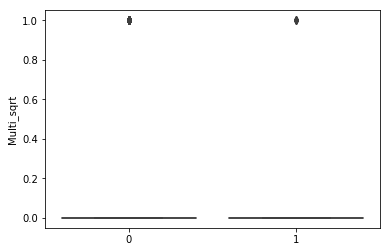

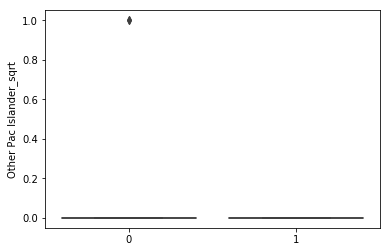

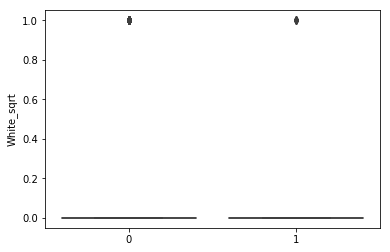

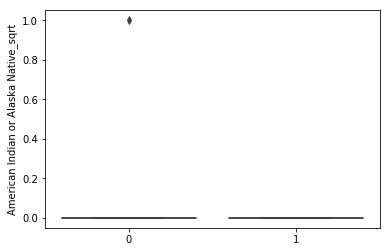

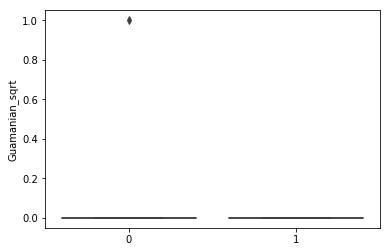

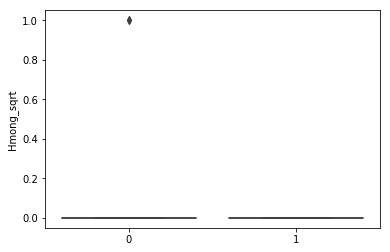

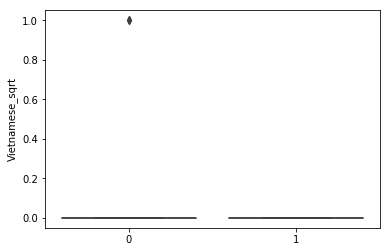

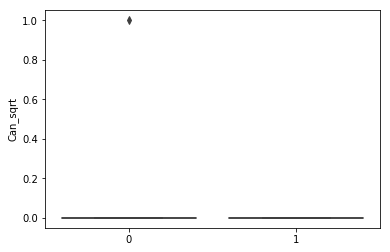

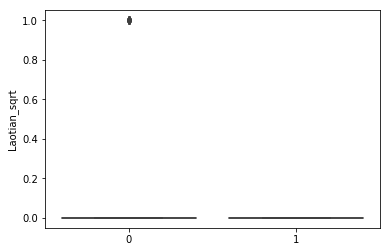

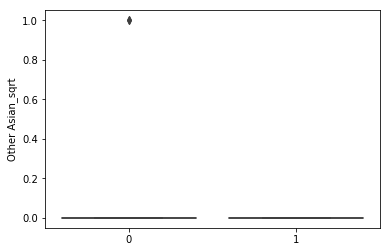

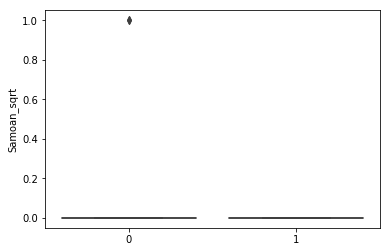

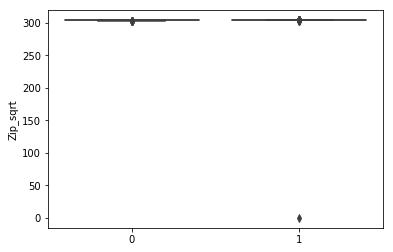

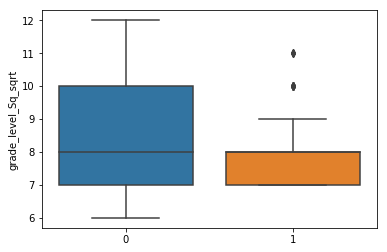

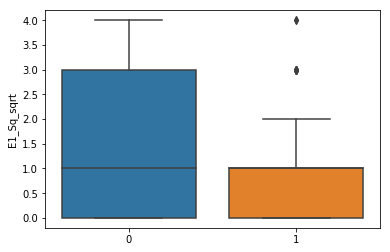

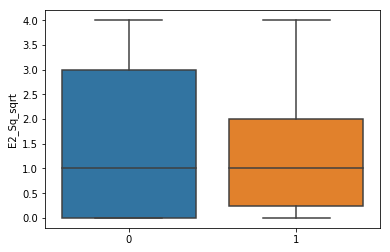

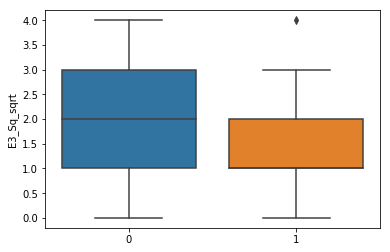

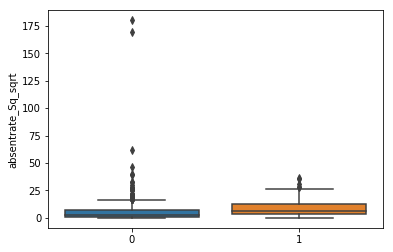

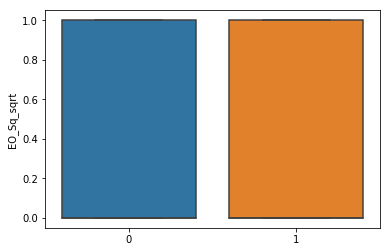

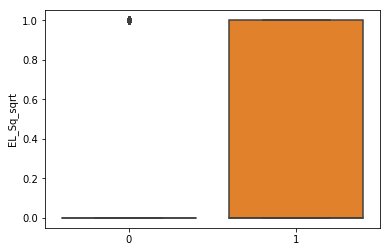

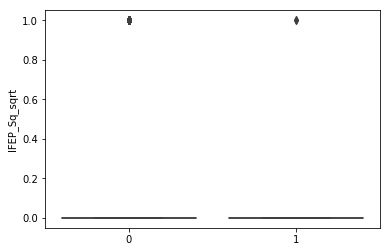

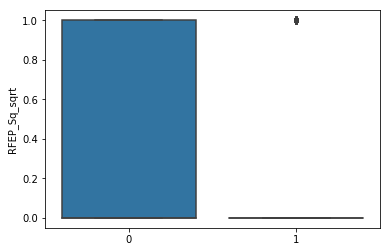

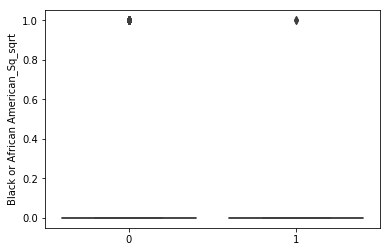

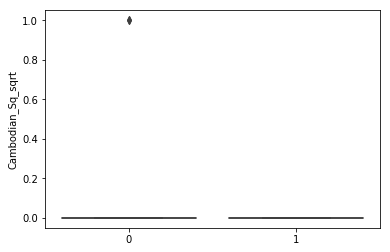

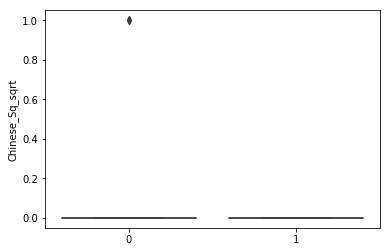

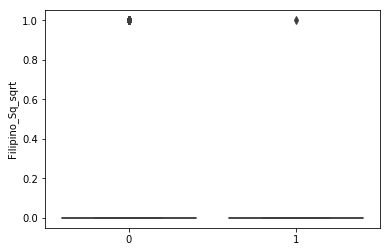

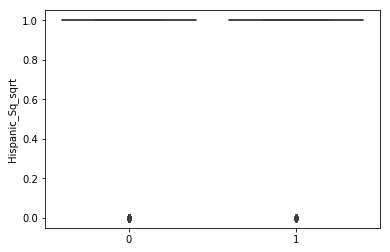

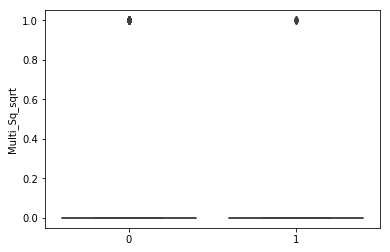

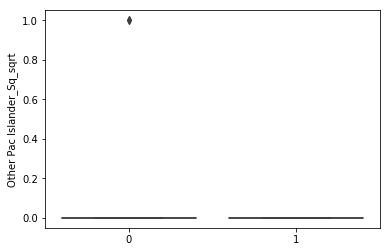

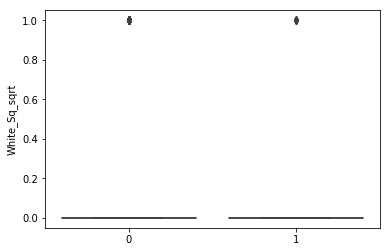

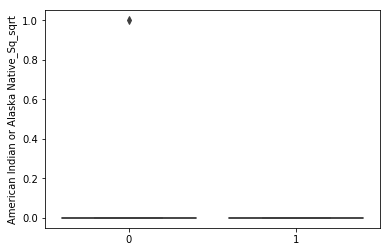

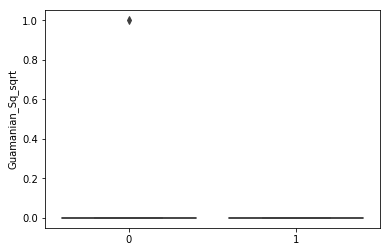

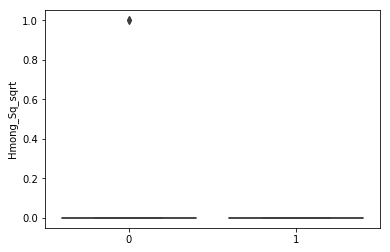

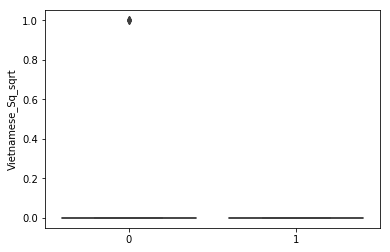

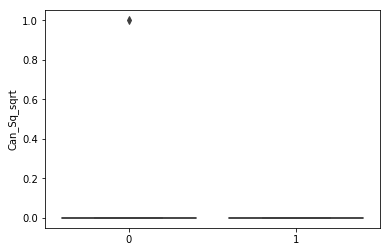

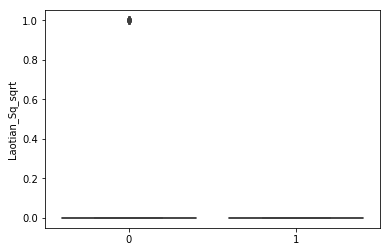

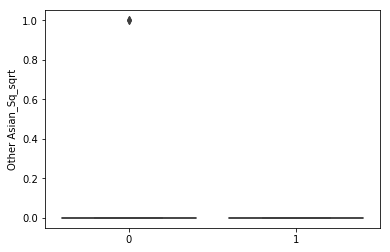

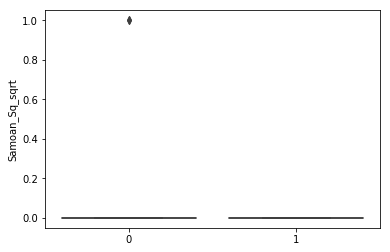

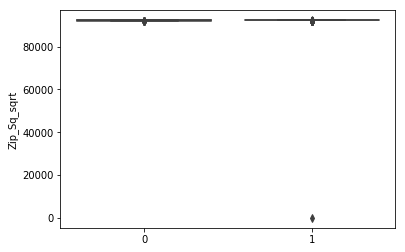

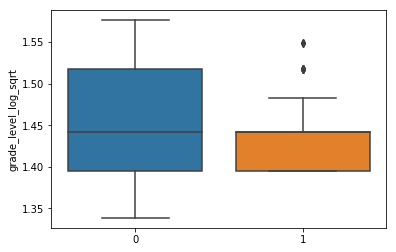

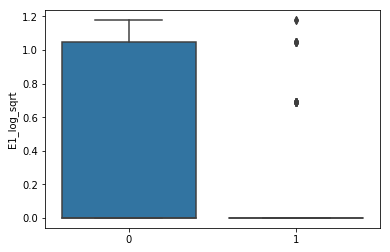

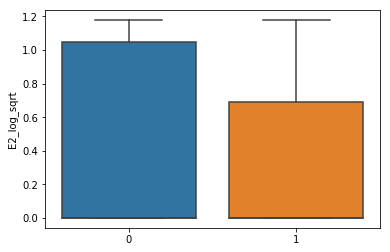

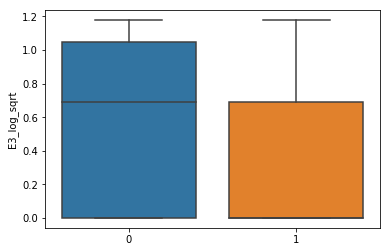

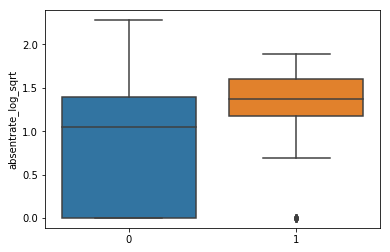

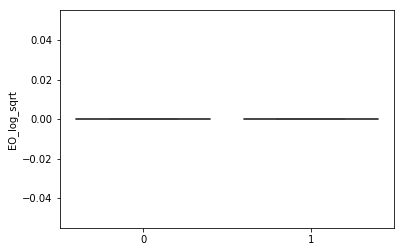

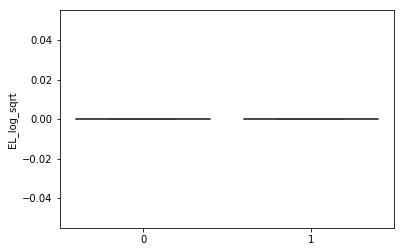

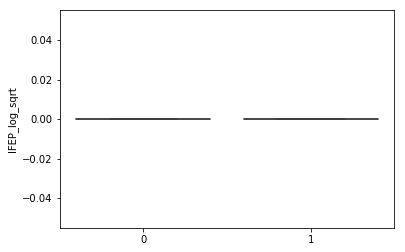

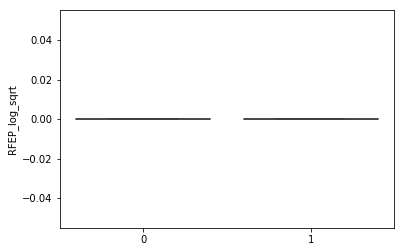

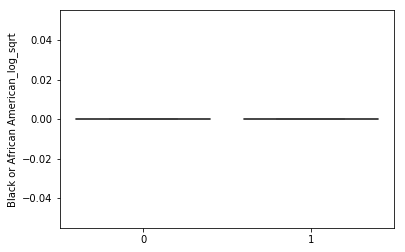

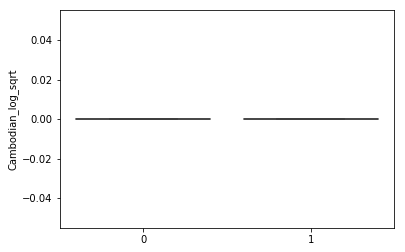

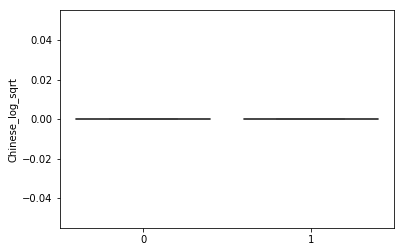

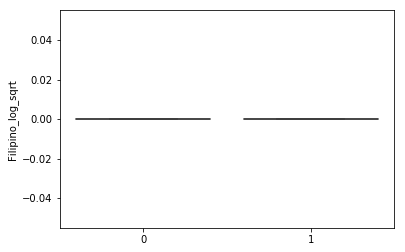

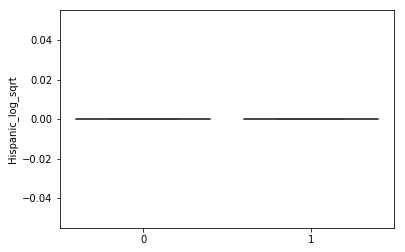

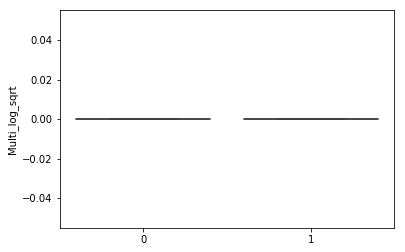

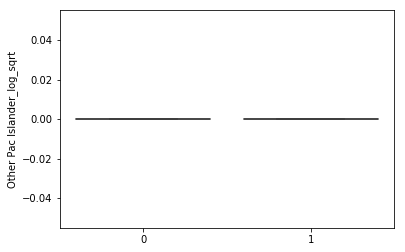

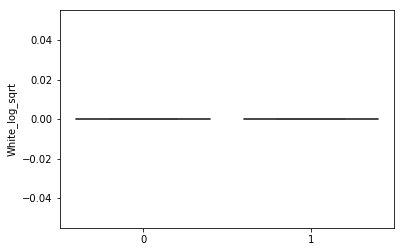

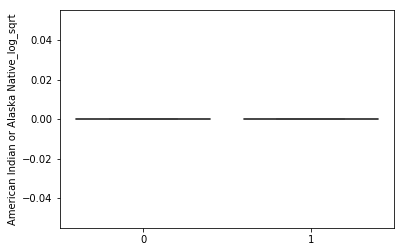

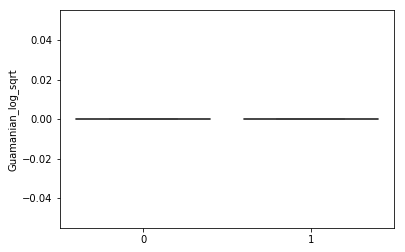

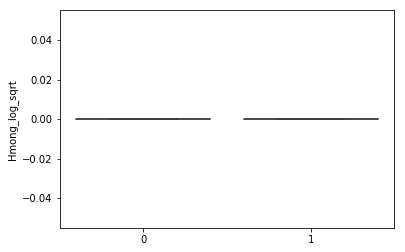

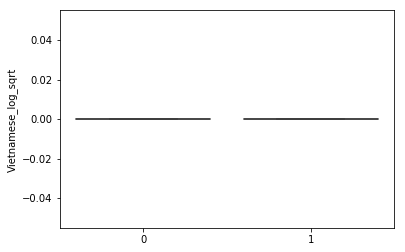

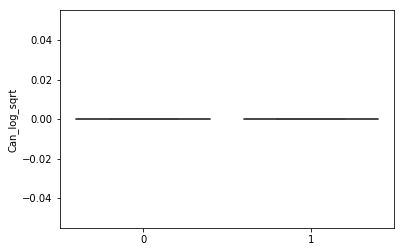

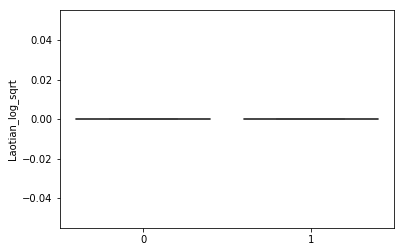

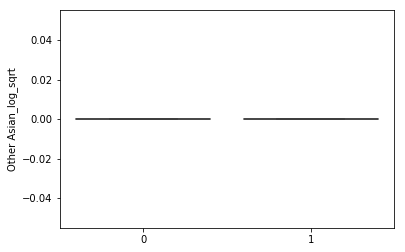

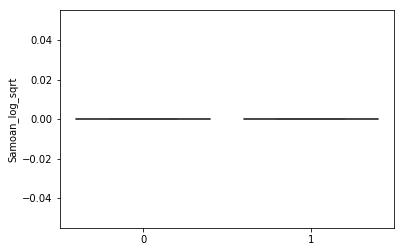

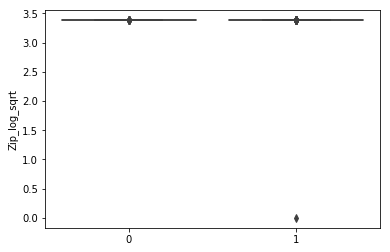

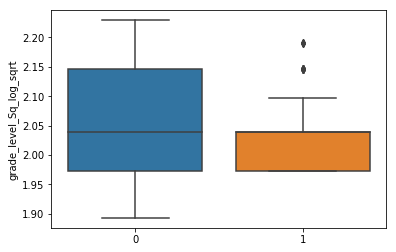

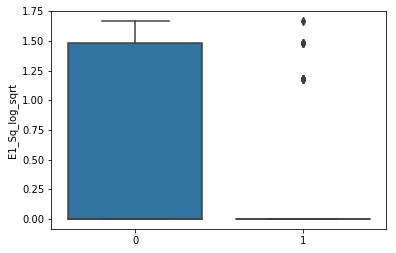

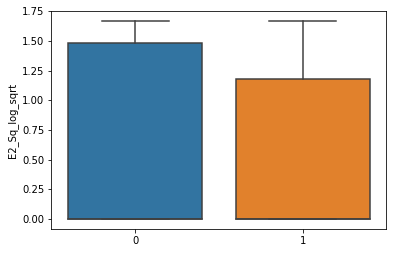

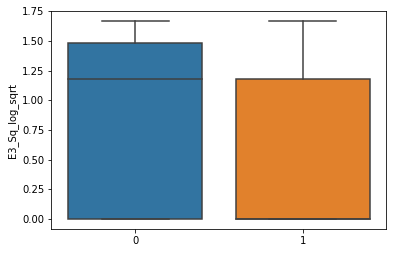

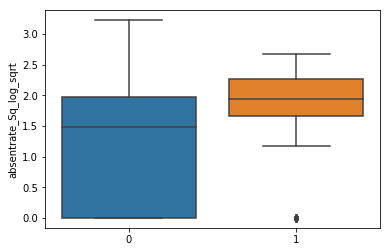

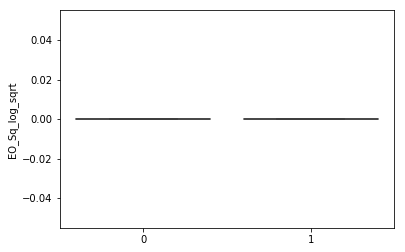

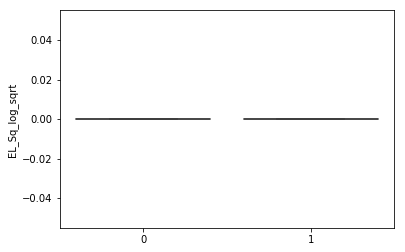

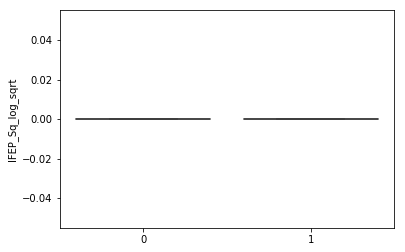

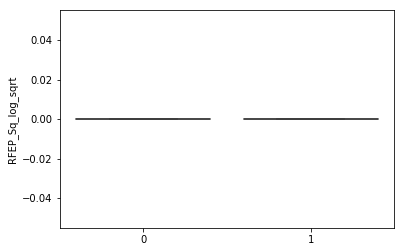

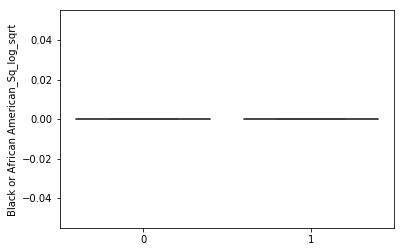

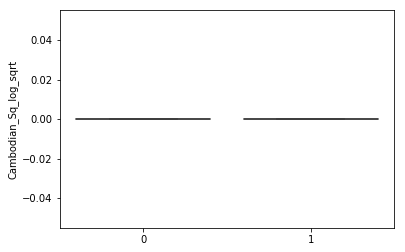

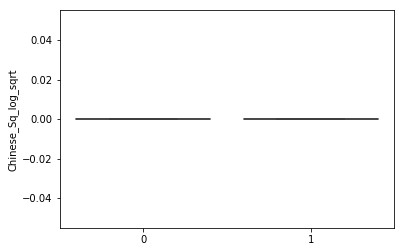

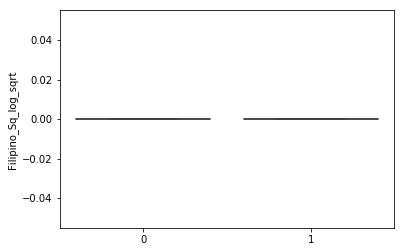

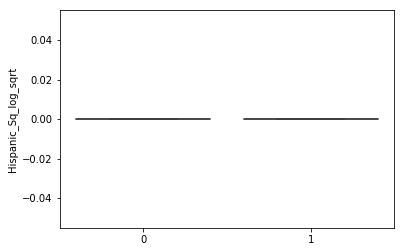

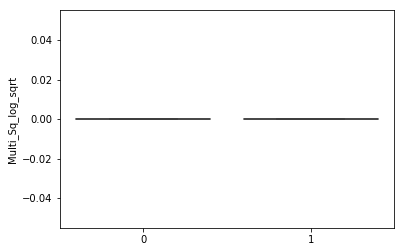

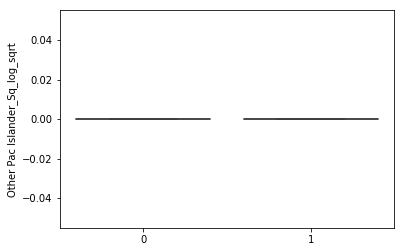

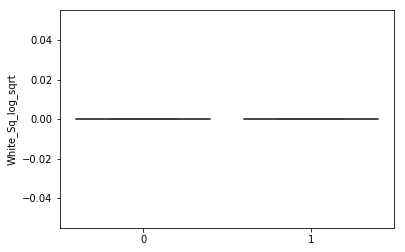

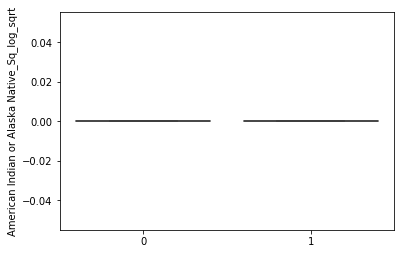

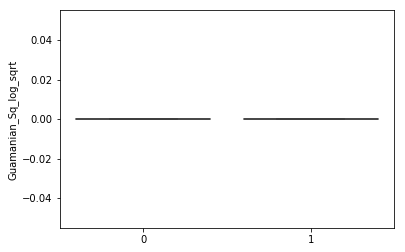

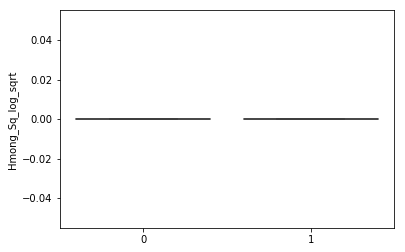

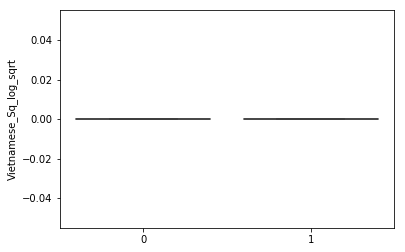

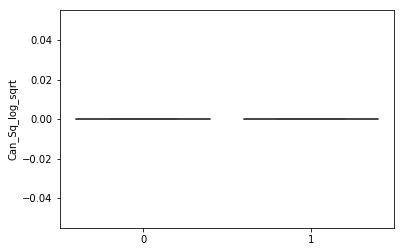

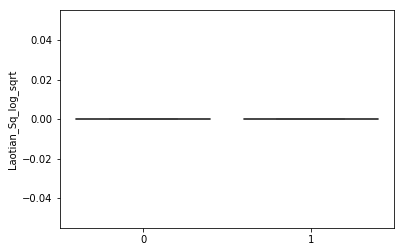

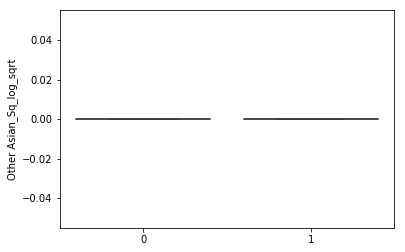

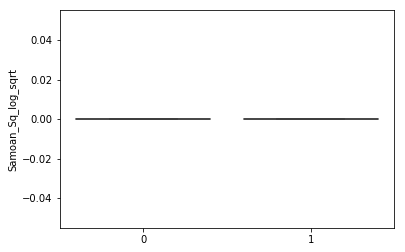

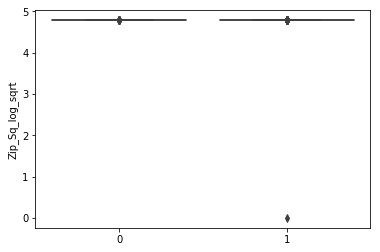

In [21]:
for x1 in X:
    sns.boxplot(x=y,y=X[x1] )
    plt.show()


grade_level


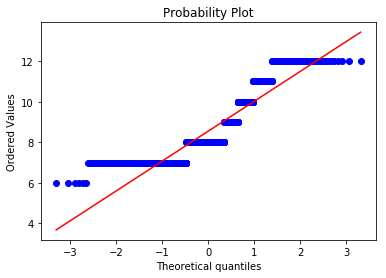

E1


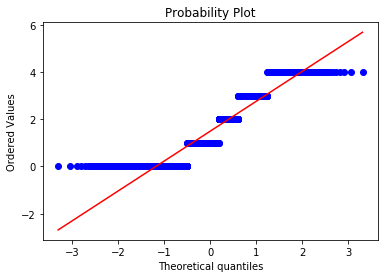

E2


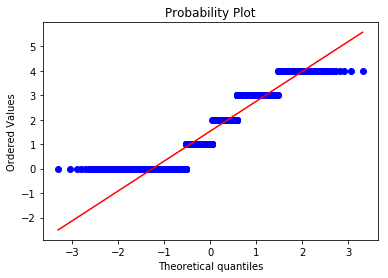

E3


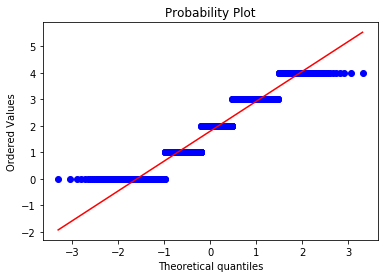

absentrate


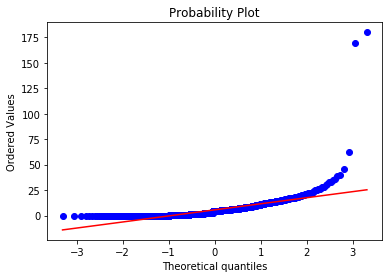

EO


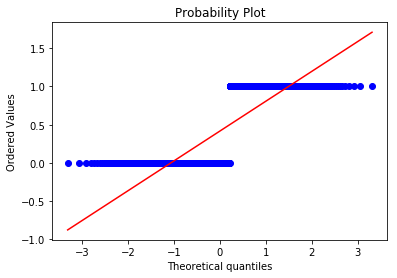

EL


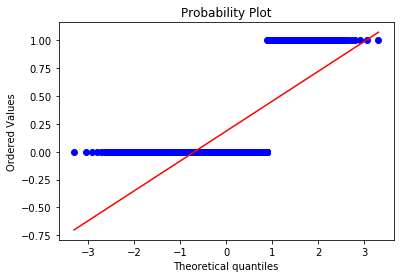

IFEP


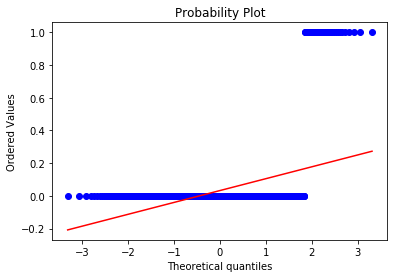

RFEP


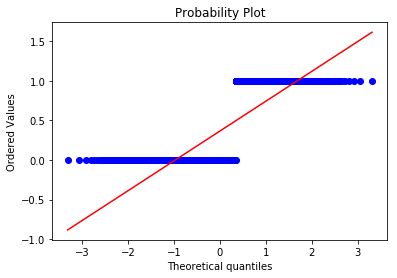

Black or African American


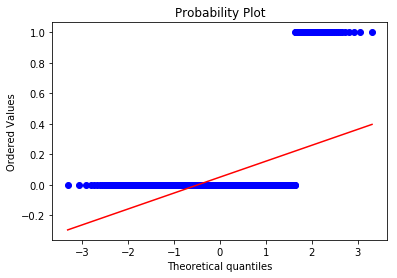

Cambodian


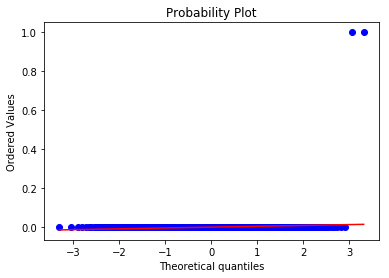

Chinese


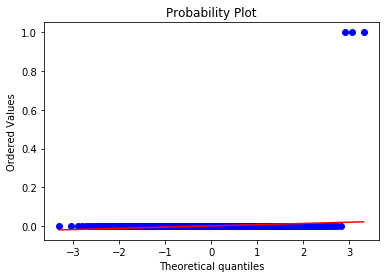

Filipino


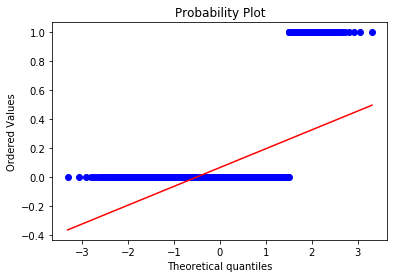

Hispanic


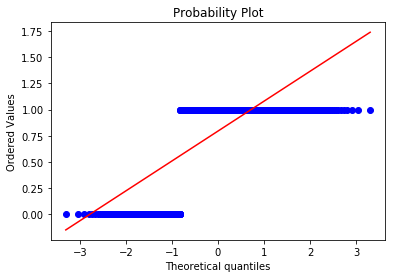

Multi


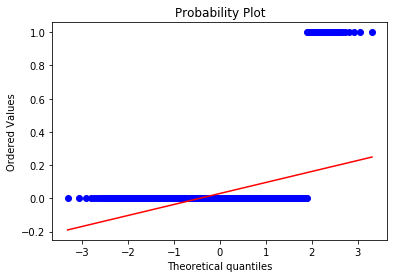

Other Pac Islander


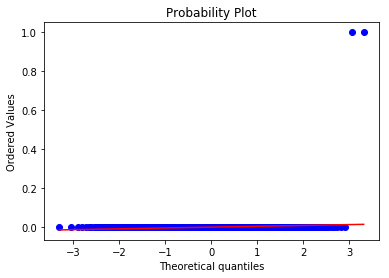

White


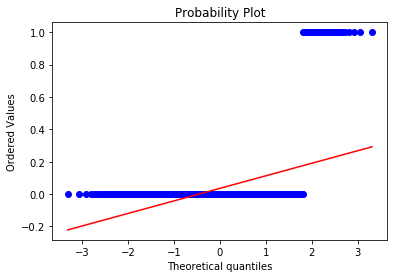

American Indian or Alaska Native


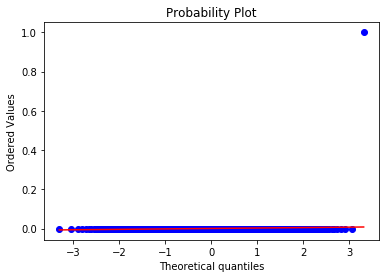

Guamanian


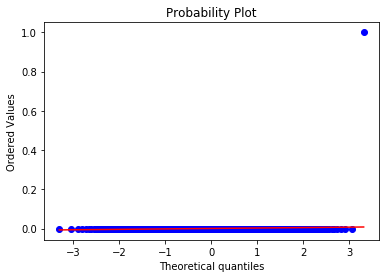

Hmong


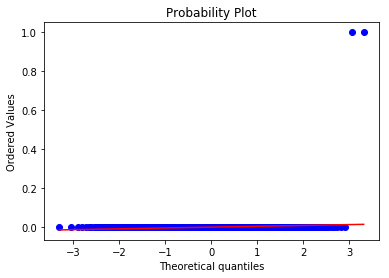

Vietnamese


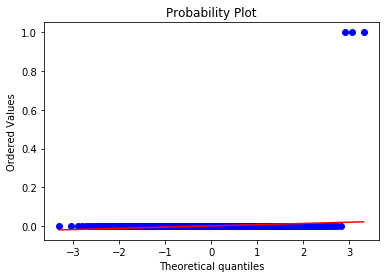

Can


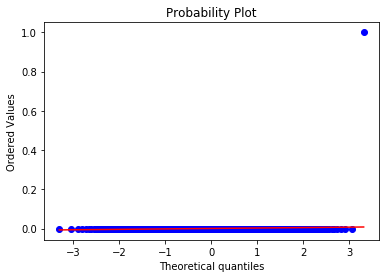

Laotian


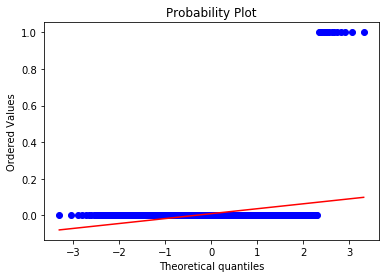

Other Asian


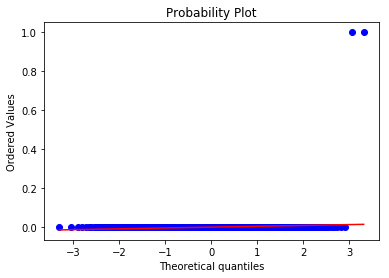

Samoan


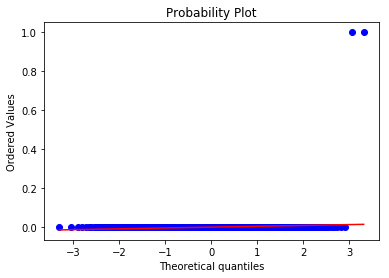

Zip


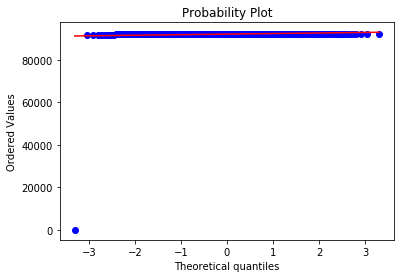

grade_level_Sq


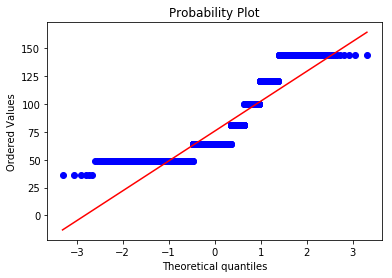

E1_Sq


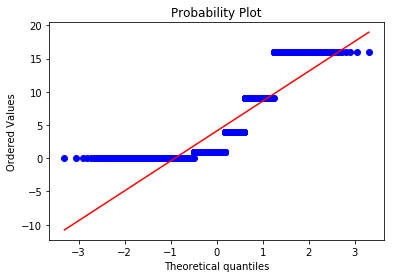

E2_Sq


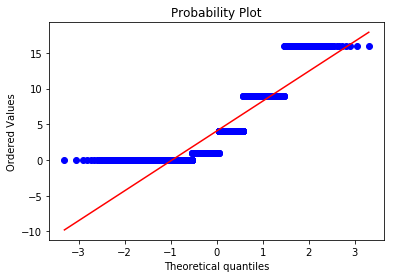

E3_Sq


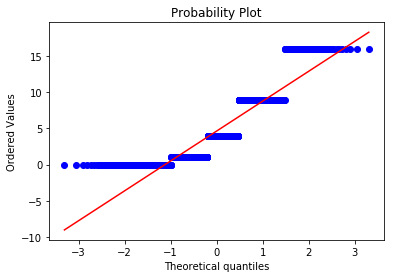

absentrate_Sq


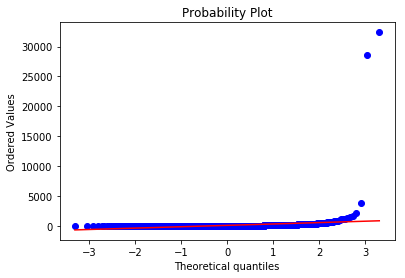

EO_Sq


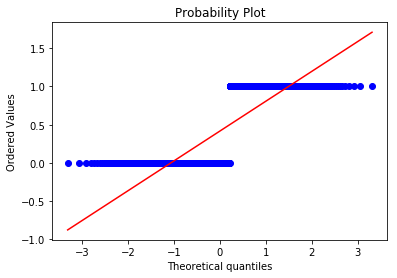

EL_Sq


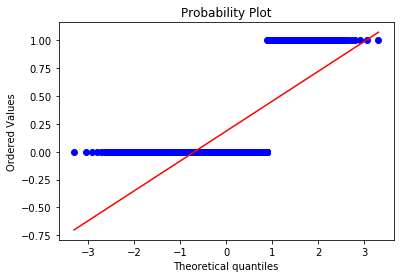

IFEP_Sq


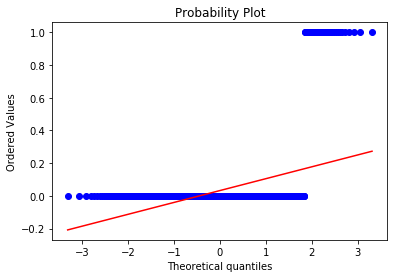

RFEP_Sq


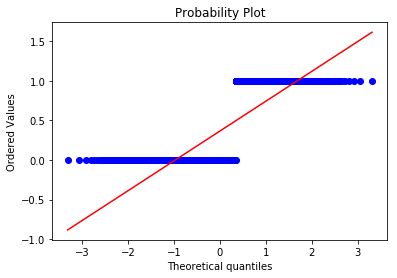

Black or African American_Sq


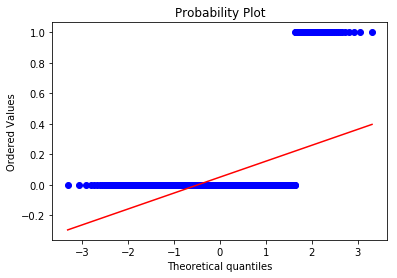

Cambodian_Sq


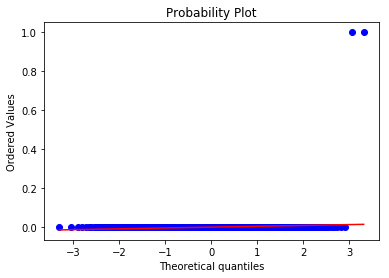

Chinese_Sq


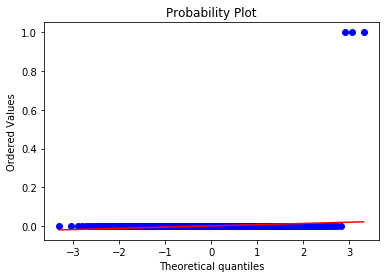

Filipino_Sq


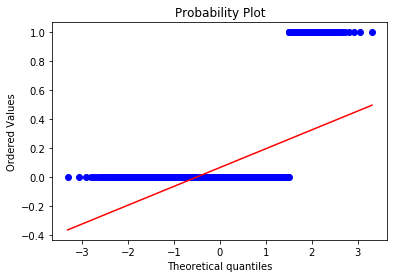

Hispanic_Sq


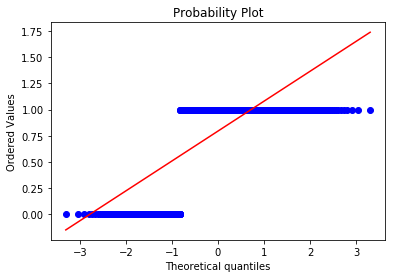

Multi_Sq


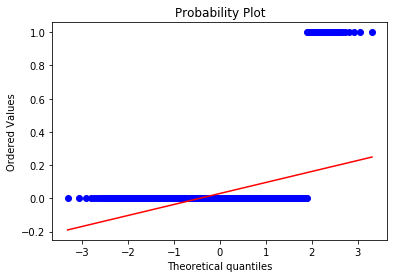

Other Pac Islander_Sq


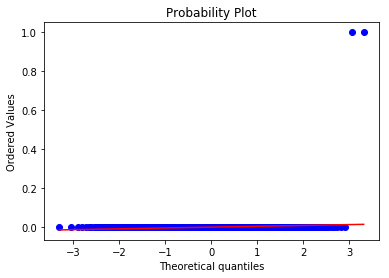

White_Sq


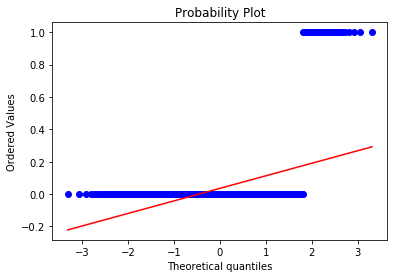

American Indian or Alaska Native_Sq


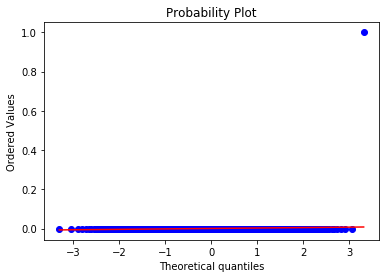

Guamanian_Sq


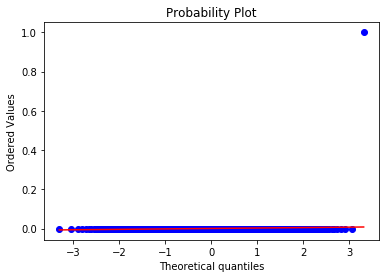

Hmong_Sq


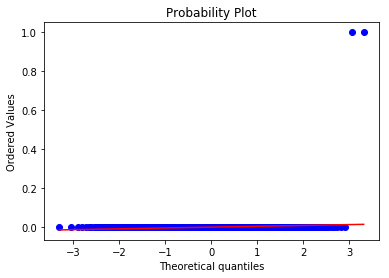

Vietnamese_Sq


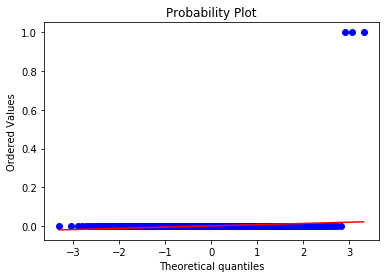

Can_Sq


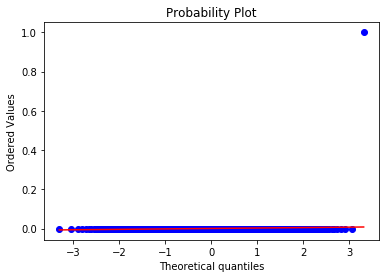

Laotian_Sq


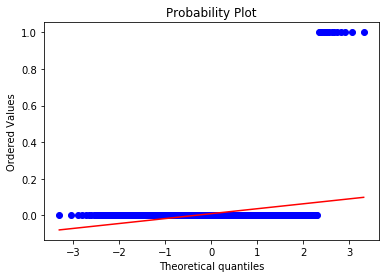

Other Asian_Sq


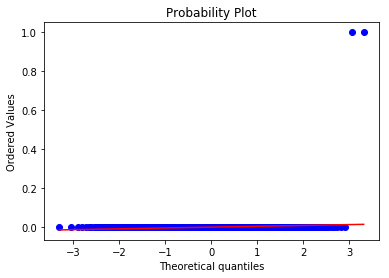

Samoan_Sq


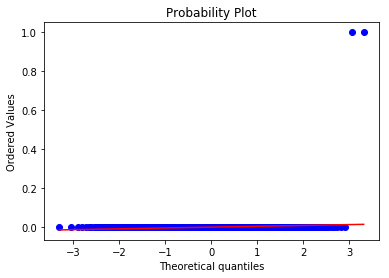

Zip_Sq


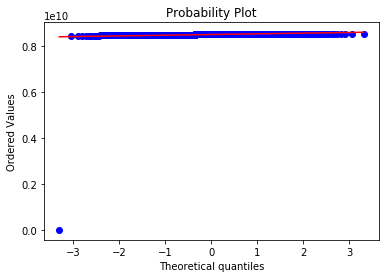

grade_level_log


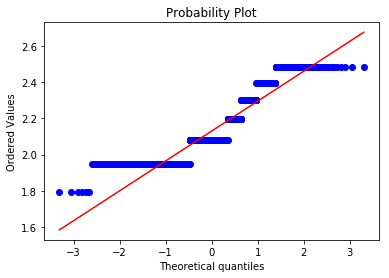

E1_log


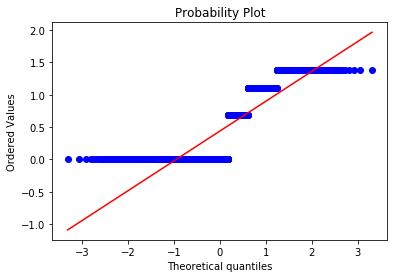

E2_log


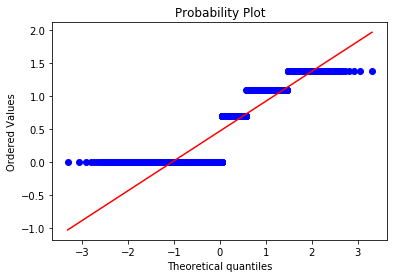

E3_log


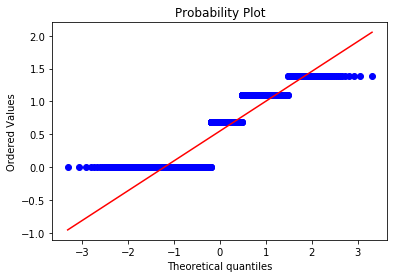

absentrate_log


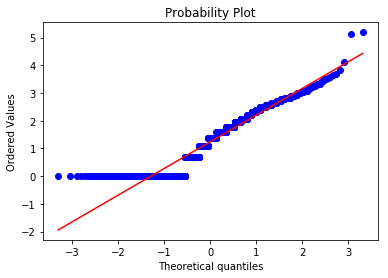

EO_log


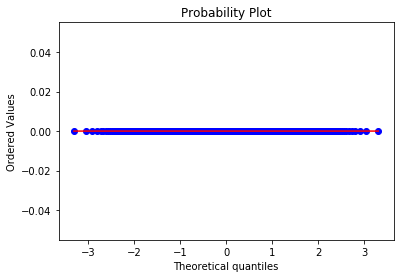

EL_log


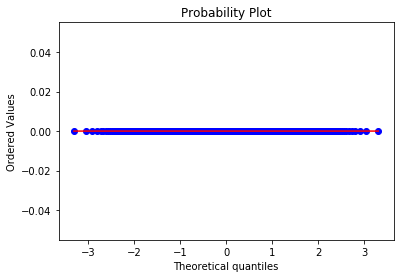

IFEP_log


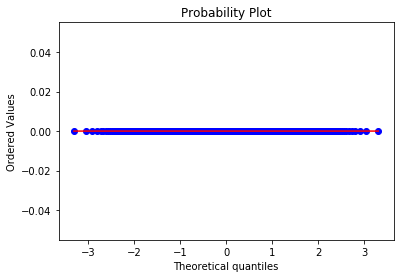

RFEP_log


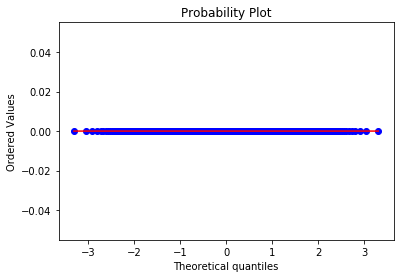

Black or African American_log


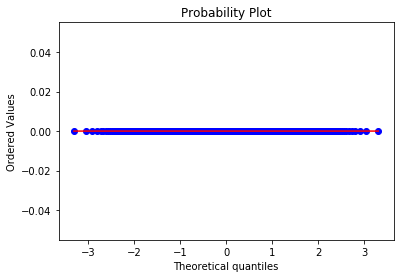

Cambodian_log


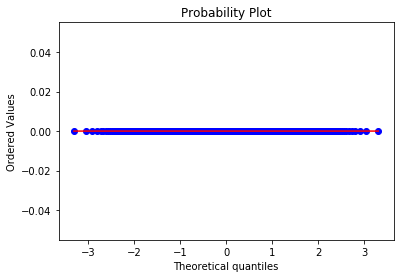

Chinese_log


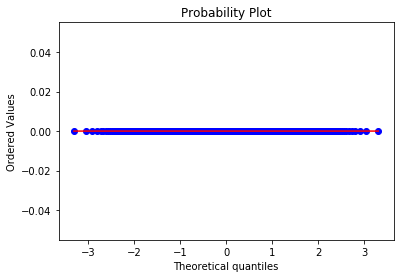

Filipino_log


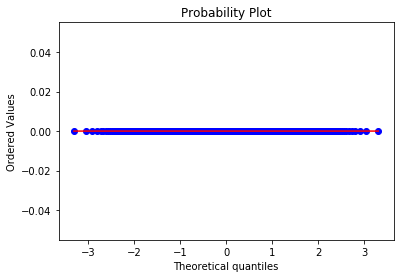

Hispanic_log


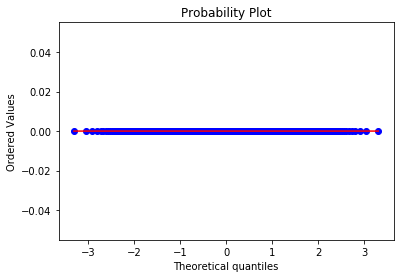

Multi_log


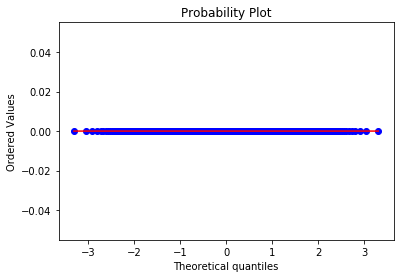

Other Pac Islander_log


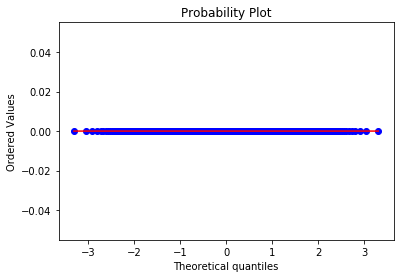

White_log


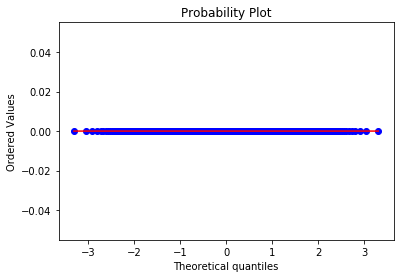

American Indian or Alaska Native_log


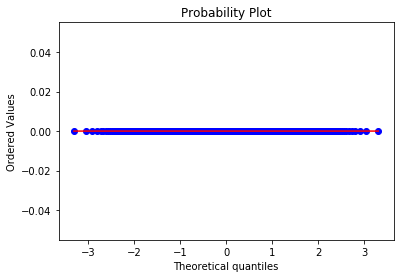

Guamanian_log


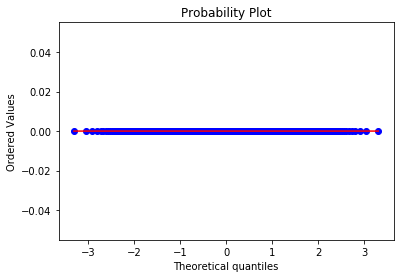

Hmong_log


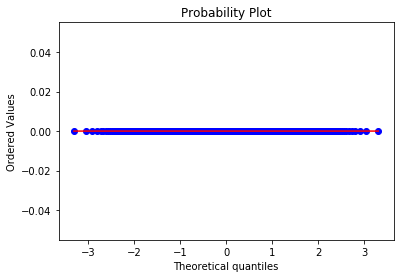

Vietnamese_log


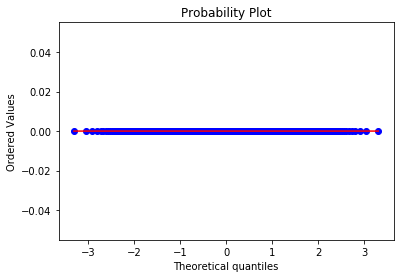

Can_log


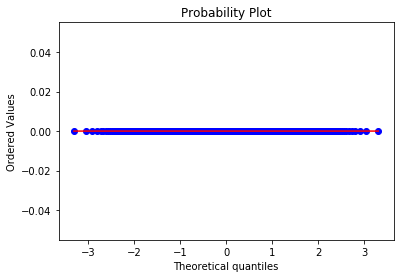

Laotian_log


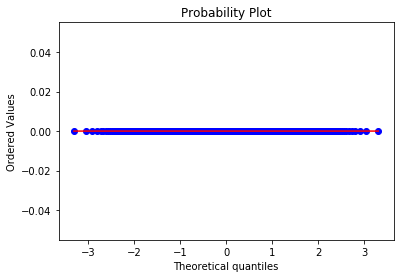

Other Asian_log


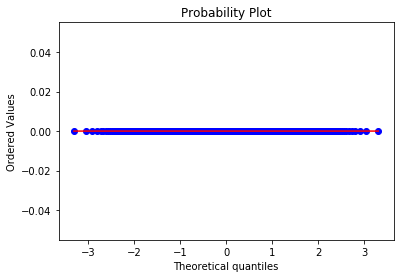

Samoan_log


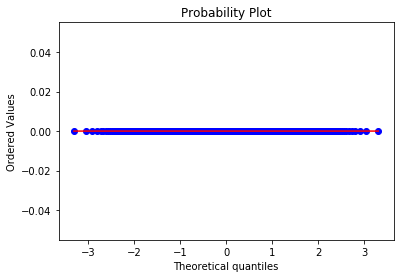

Zip_log


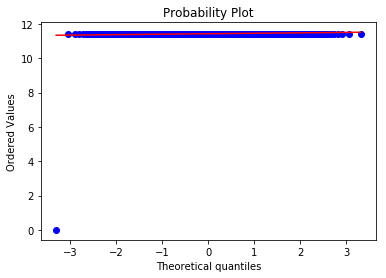

grade_level_Sq_log


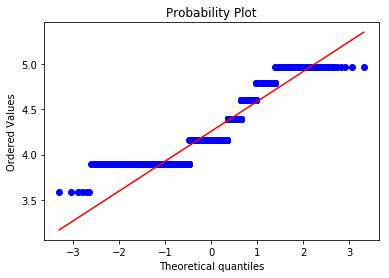

E1_Sq_log


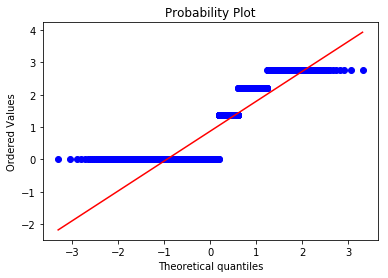

E2_Sq_log


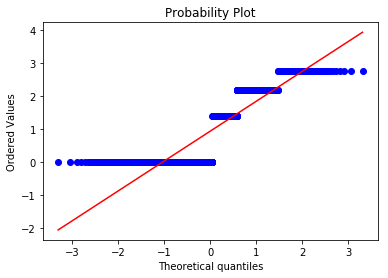

E3_Sq_log


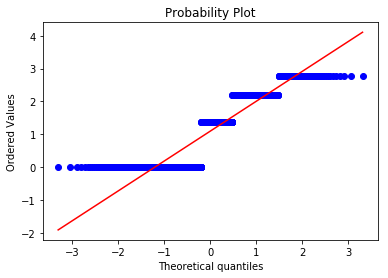

absentrate_Sq_log


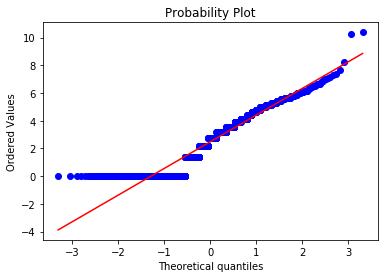

EO_Sq_log


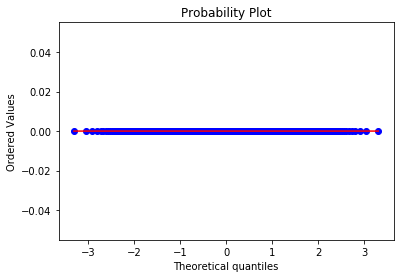

EL_Sq_log


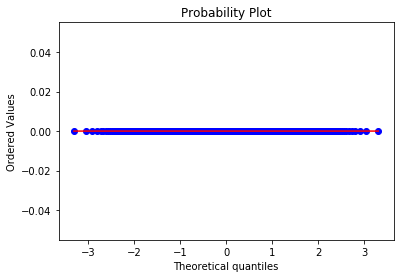

IFEP_Sq_log


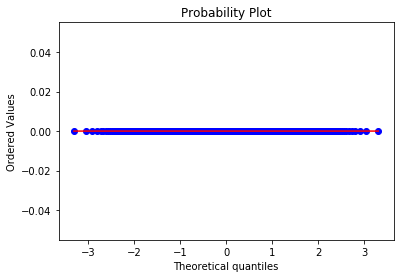

RFEP_Sq_log


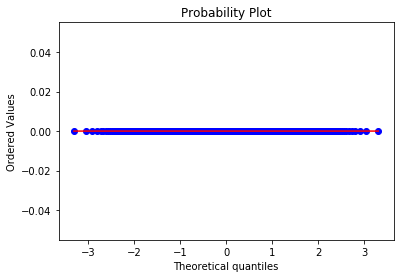

Black or African American_Sq_log


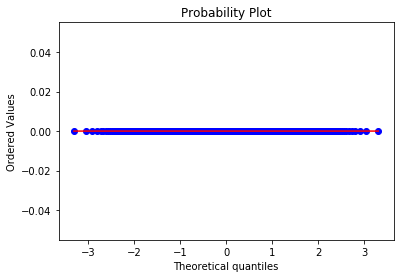

Cambodian_Sq_log


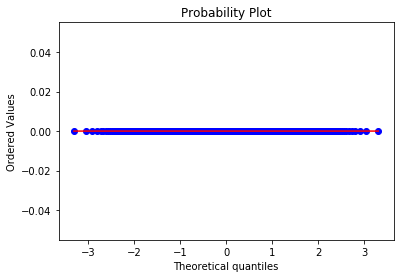

Chinese_Sq_log


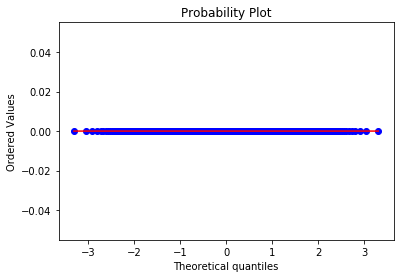

Filipino_Sq_log


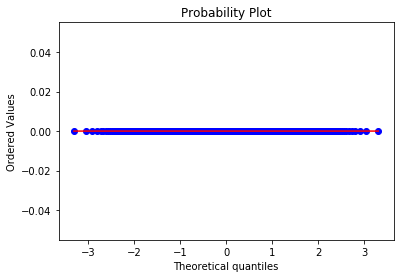

Hispanic_Sq_log


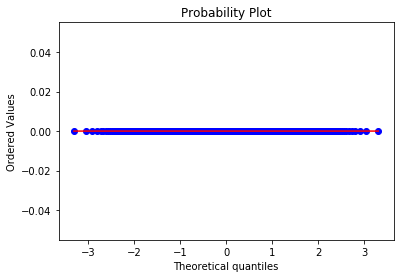

Multi_Sq_log


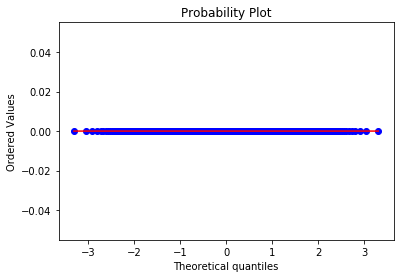

Other Pac Islander_Sq_log


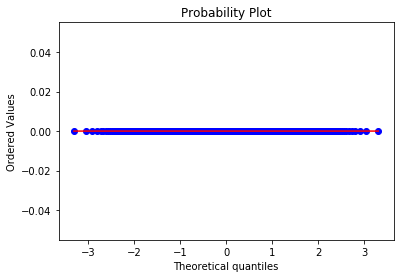

White_Sq_log


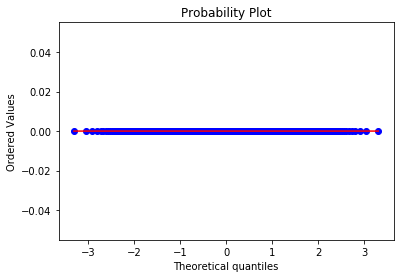

American Indian or Alaska Native_Sq_log


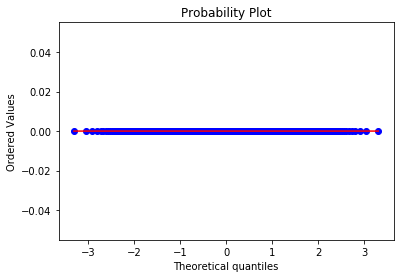

Guamanian_Sq_log


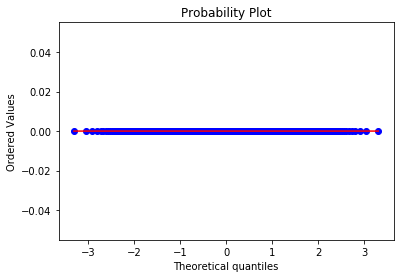

Hmong_Sq_log


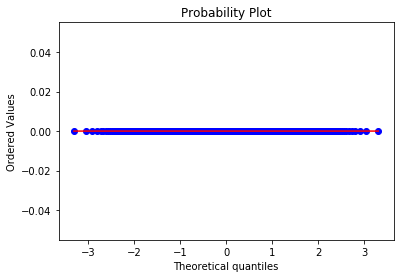

Vietnamese_Sq_log


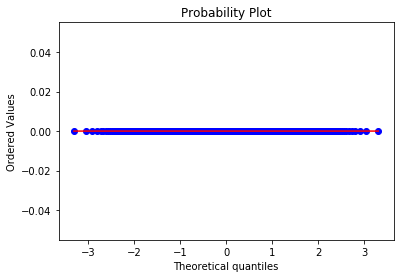

Can_Sq_log


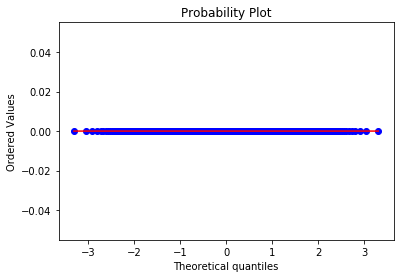

Laotian_Sq_log


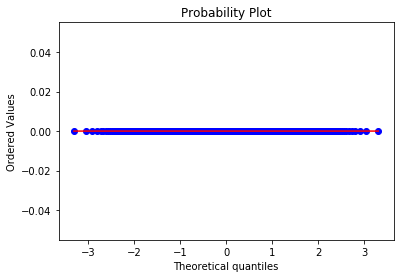

Other Asian_Sq_log


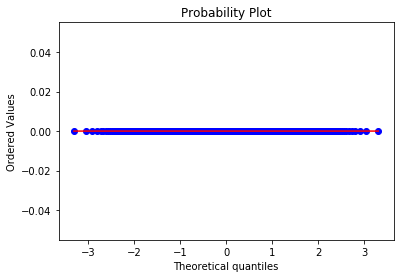

Samoan_Sq_log


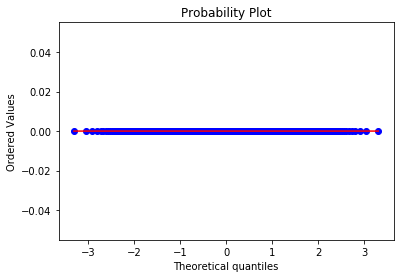

Zip_Sq_log


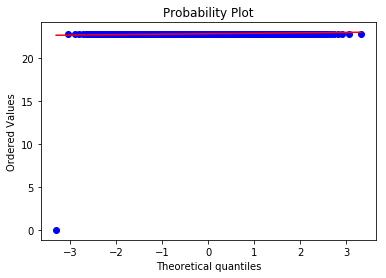

grade_level_sqrt


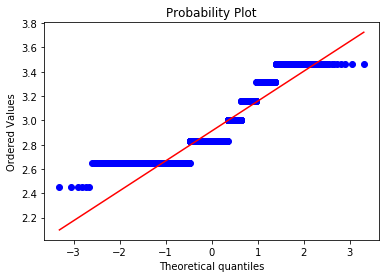

E1_sqrt


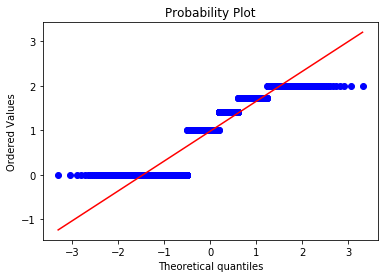

E2_sqrt


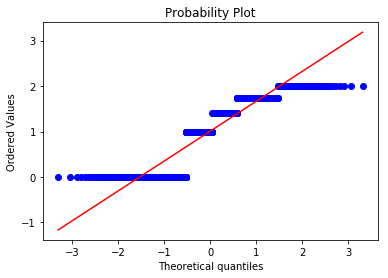

E3_sqrt


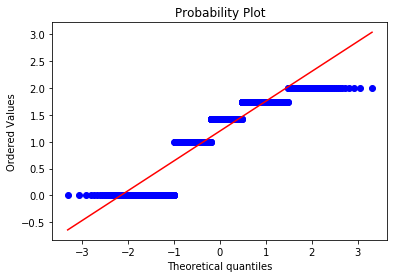

absentrate_sqrt


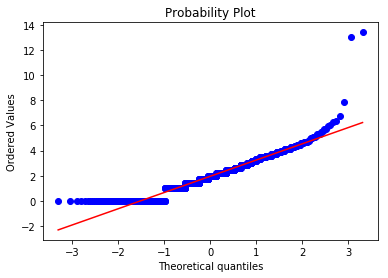

EO_sqrt


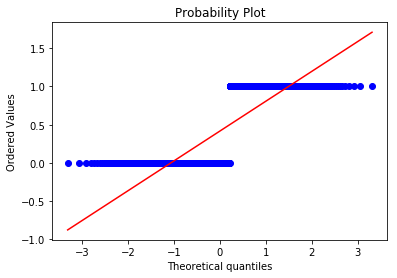

EL_sqrt


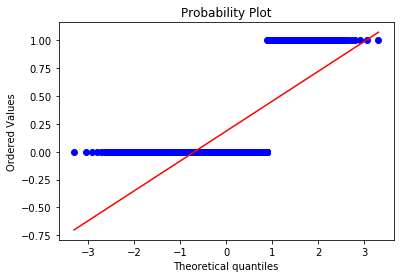

IFEP_sqrt


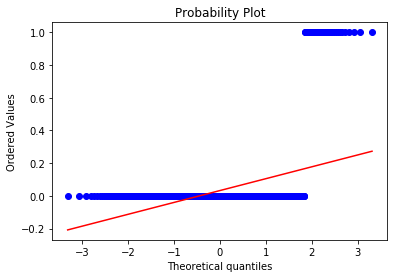

RFEP_sqrt


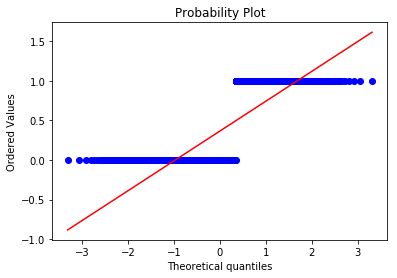

Black or African American_sqrt


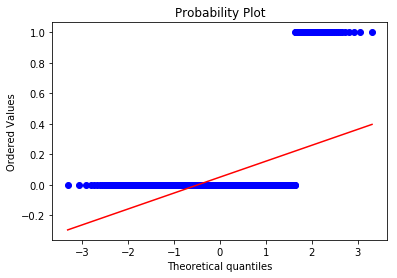

Cambodian_sqrt


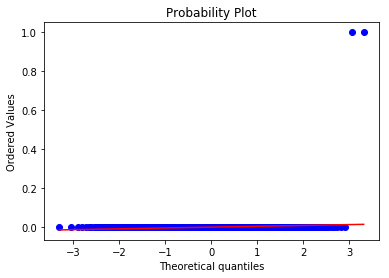

Chinese_sqrt


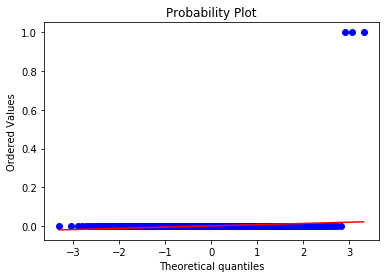

Filipino_sqrt


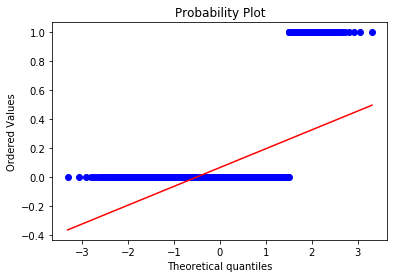

Hispanic_sqrt


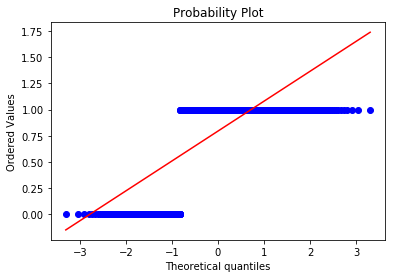

Multi_sqrt


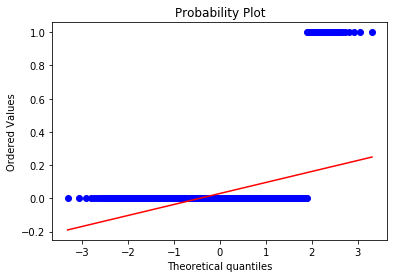

Other Pac Islander_sqrt


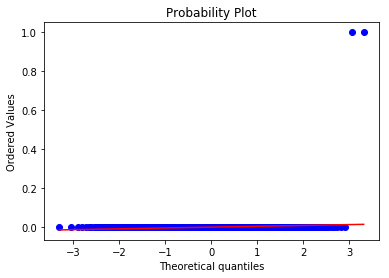

White_sqrt


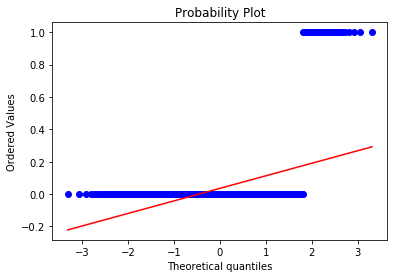

American Indian or Alaska Native_sqrt


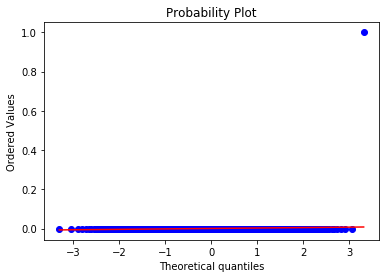

Guamanian_sqrt


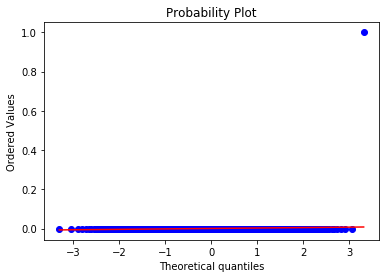

Hmong_sqrt


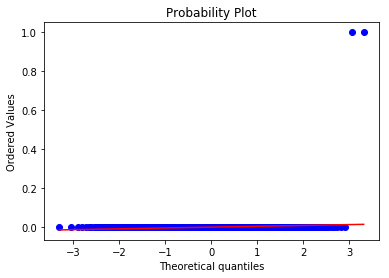

Vietnamese_sqrt


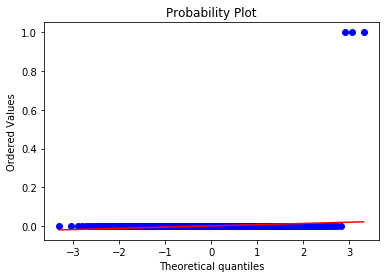

Can_sqrt


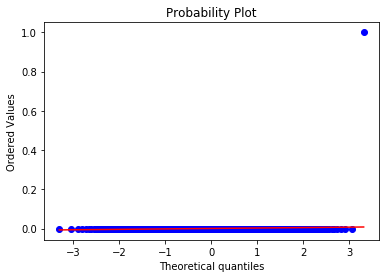

Laotian_sqrt


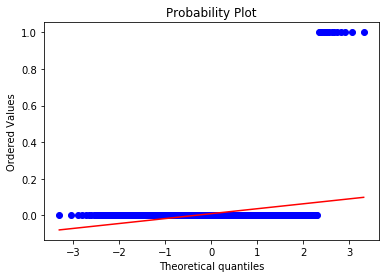

Other Asian_sqrt


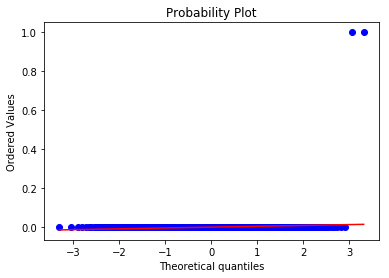

Samoan_sqrt


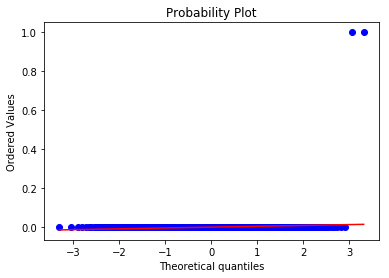

Zip_sqrt


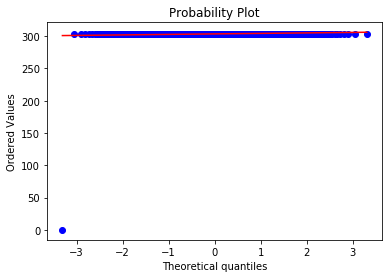

grade_level_Sq_sqrt


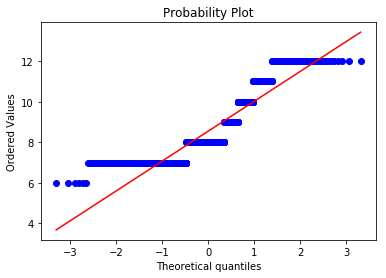

E1_Sq_sqrt


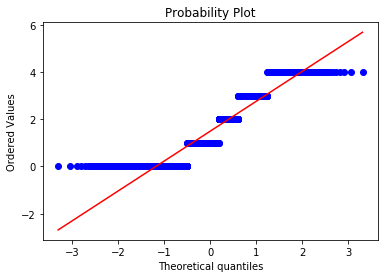

E2_Sq_sqrt


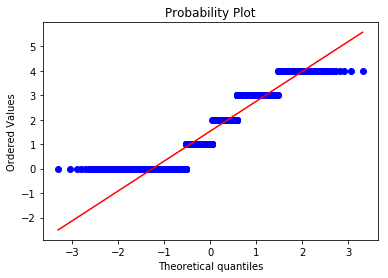

E3_Sq_sqrt


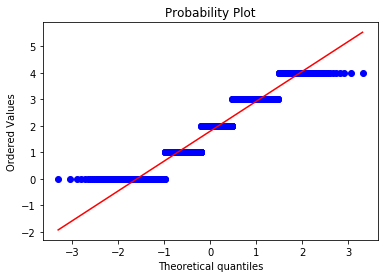

absentrate_Sq_sqrt


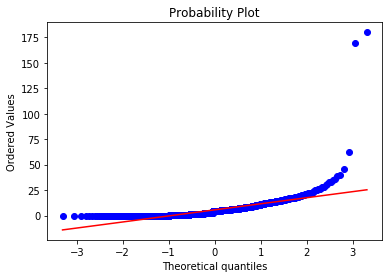

EO_Sq_sqrt


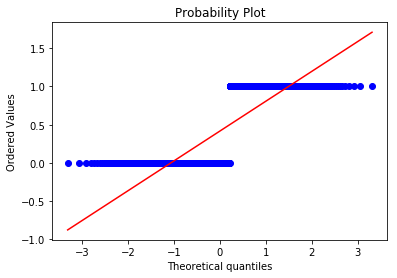

EL_Sq_sqrt


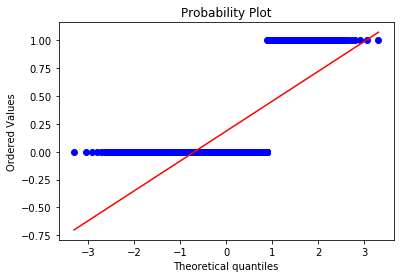

IFEP_Sq_sqrt


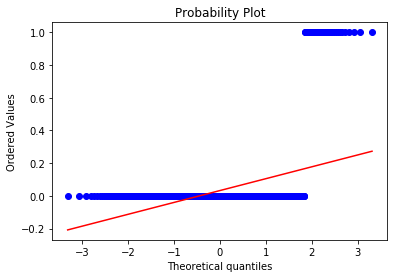

RFEP_Sq_sqrt


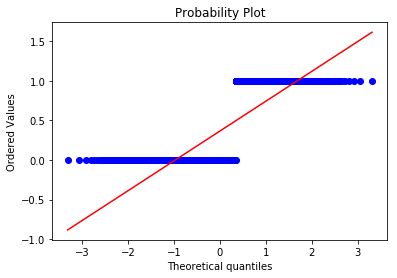

Black or African American_Sq_sqrt


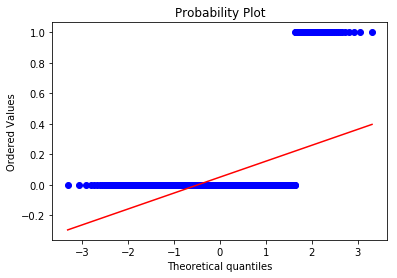

Cambodian_Sq_sqrt


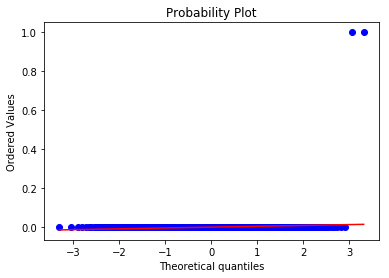

Chinese_Sq_sqrt


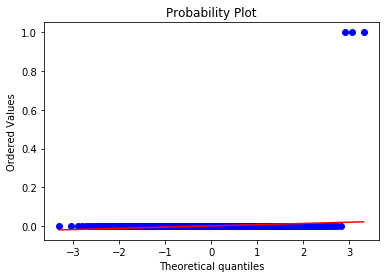

Filipino_Sq_sqrt


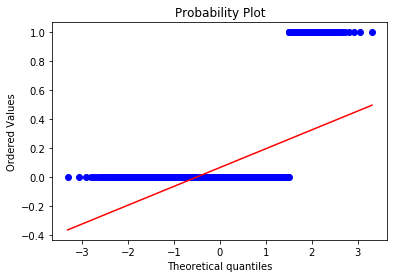

Hispanic_Sq_sqrt


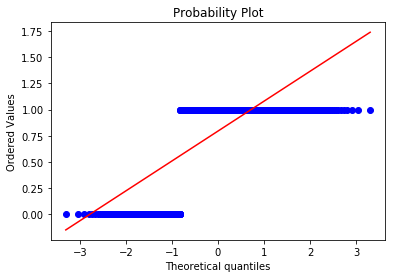

Multi_Sq_sqrt


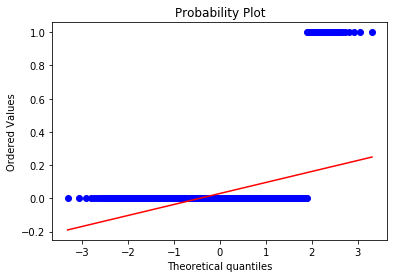

Other Pac Islander_Sq_sqrt


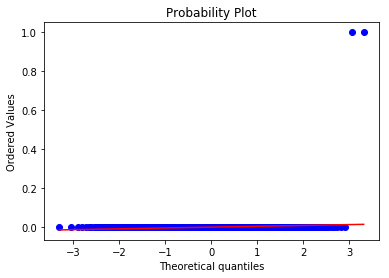

White_Sq_sqrt


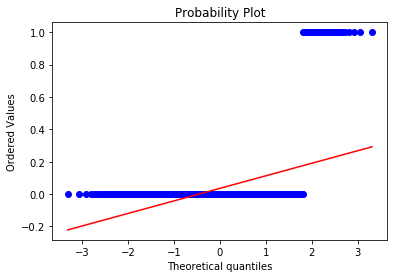

American Indian or Alaska Native_Sq_sqrt


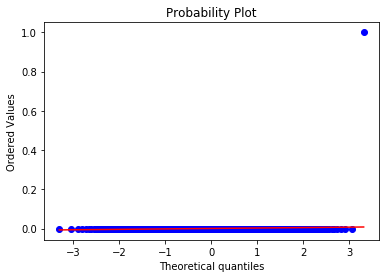

Guamanian_Sq_sqrt


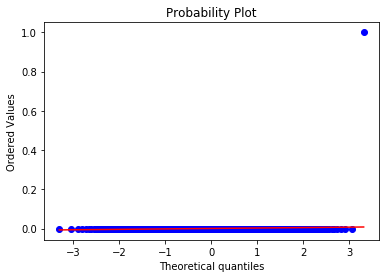

Hmong_Sq_sqrt


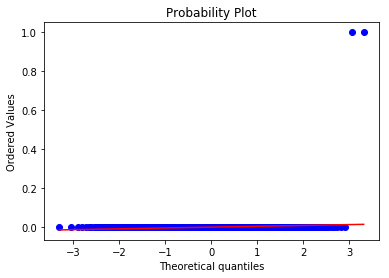

Vietnamese_Sq_sqrt


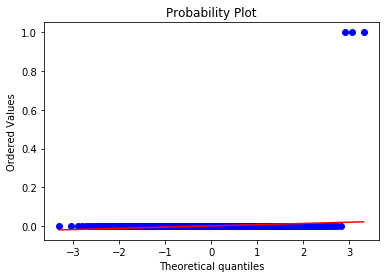

Can_Sq_sqrt


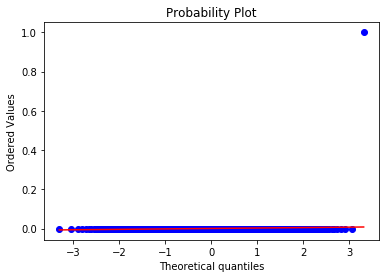

Laotian_Sq_sqrt


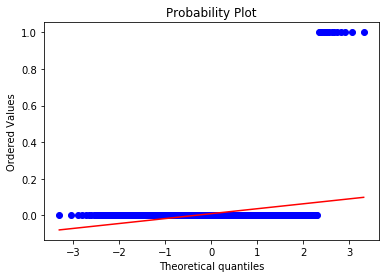

Other Asian_Sq_sqrt


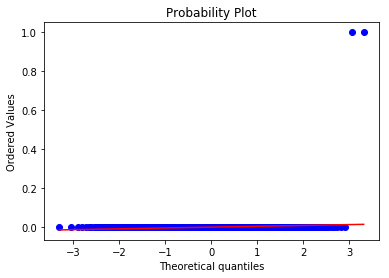

Samoan_Sq_sqrt


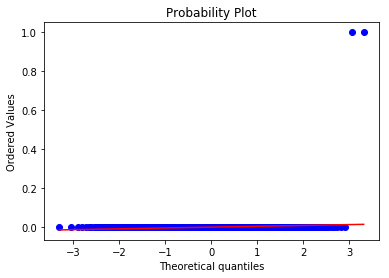

Zip_Sq_sqrt


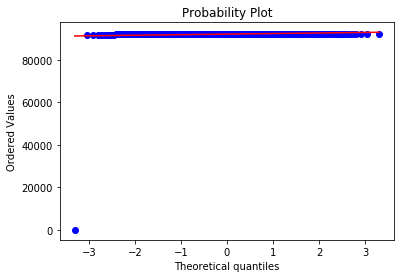

grade_level_log_sqrt


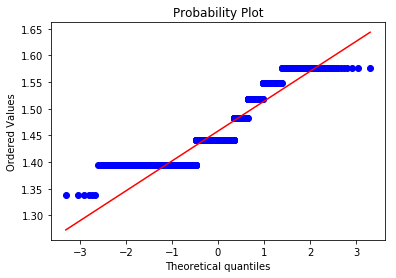

E1_log_sqrt


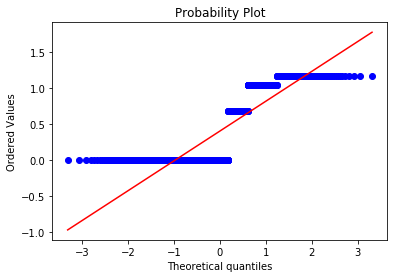

E2_log_sqrt


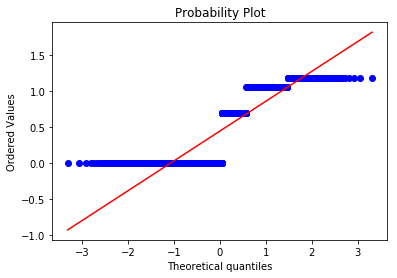

E3_log_sqrt


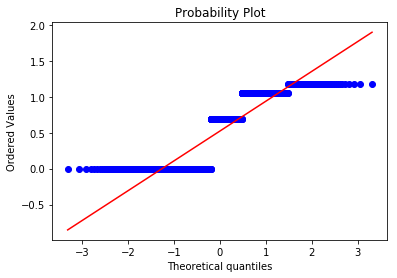

absentrate_log_sqrt


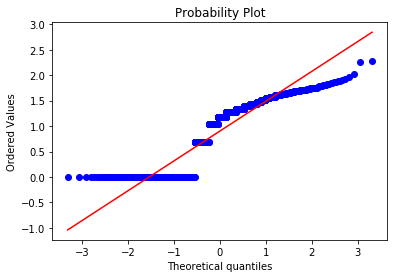

EO_log_sqrt


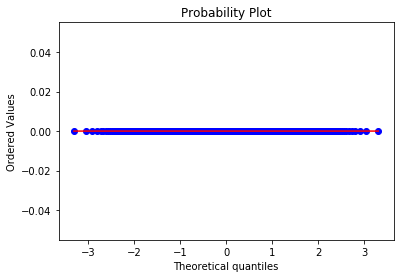

EL_log_sqrt


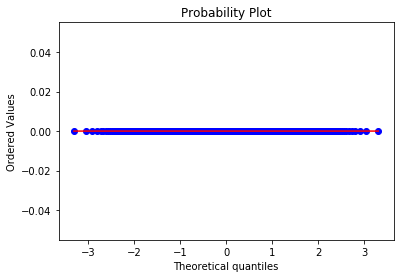

IFEP_log_sqrt


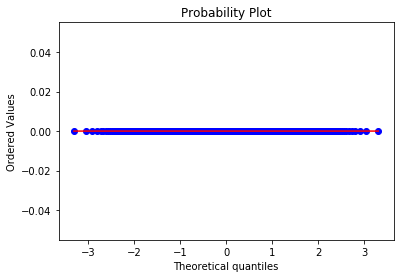

RFEP_log_sqrt


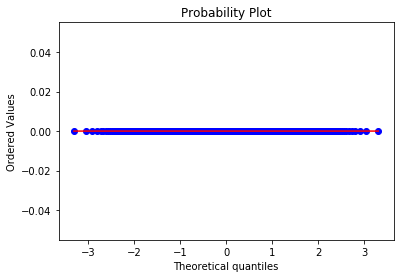

Black or African American_log_sqrt


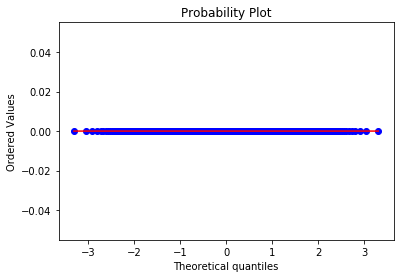

Cambodian_log_sqrt


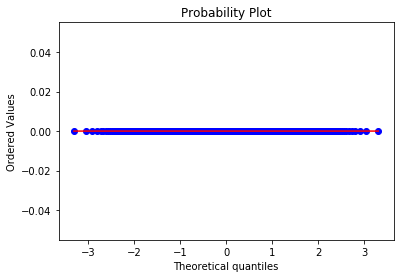

Chinese_log_sqrt


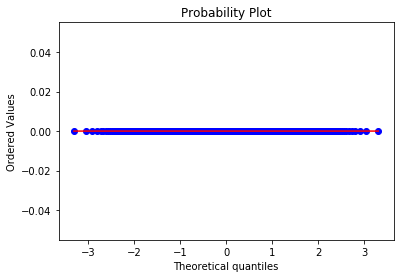

Filipino_log_sqrt


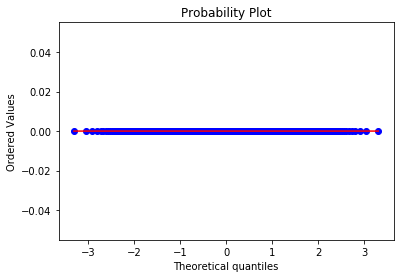

Hispanic_log_sqrt


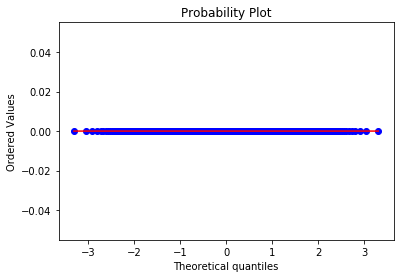

Multi_log_sqrt


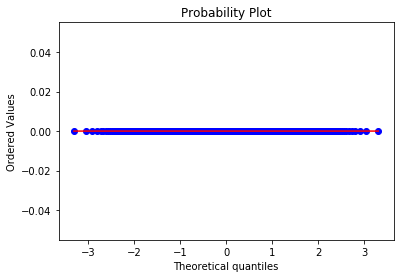

Other Pac Islander_log_sqrt


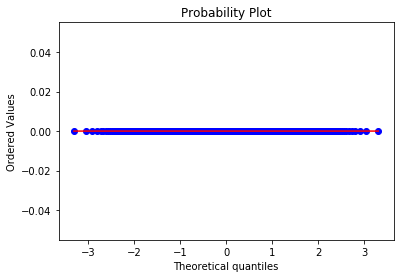

White_log_sqrt


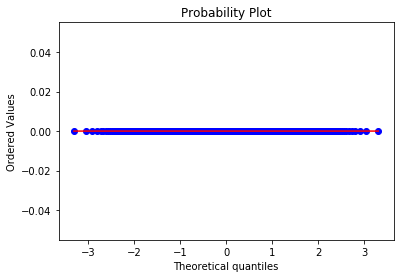

American Indian or Alaska Native_log_sqrt


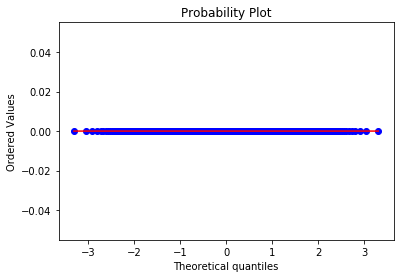

Guamanian_log_sqrt


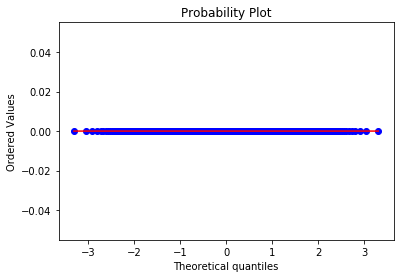

Hmong_log_sqrt


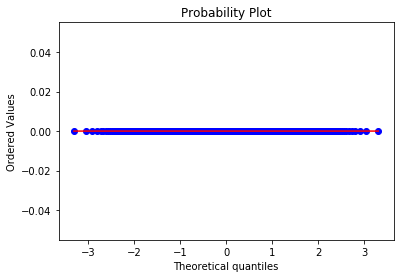

Vietnamese_log_sqrt


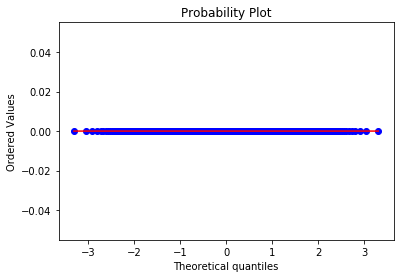

Can_log_sqrt


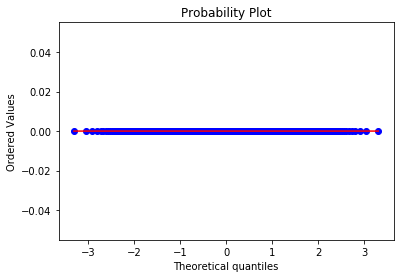

Laotian_log_sqrt


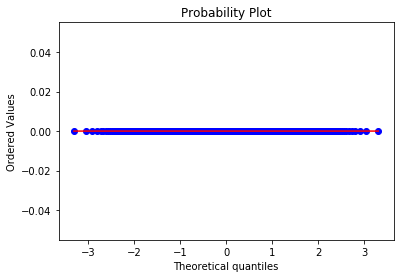

Other Asian_log_sqrt


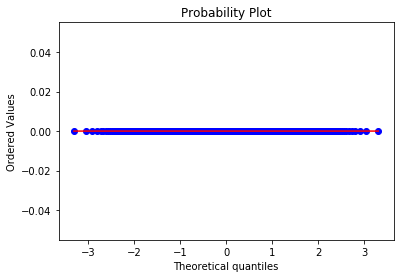

Samoan_log_sqrt


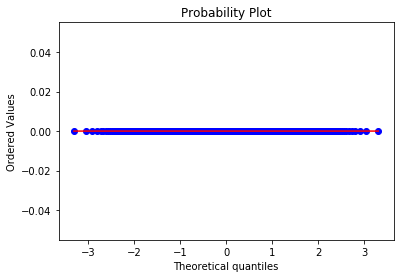

Zip_log_sqrt


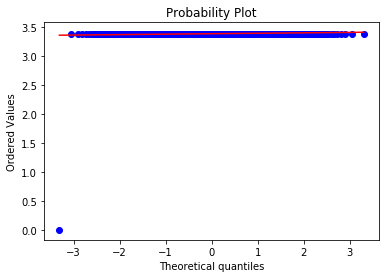

grade_level_Sq_log_sqrt


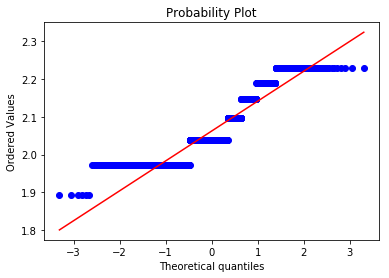

E1_Sq_log_sqrt


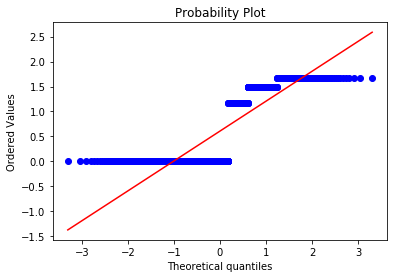

E2_Sq_log_sqrt


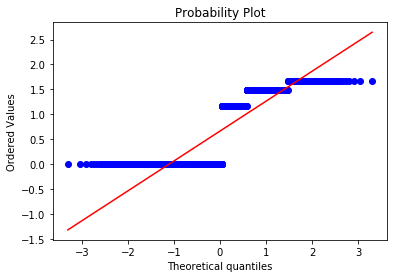

E3_Sq_log_sqrt


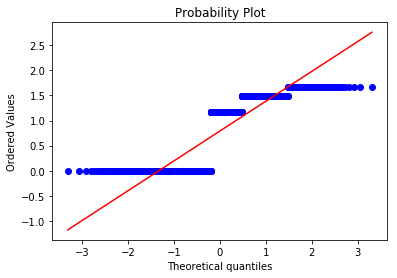

absentrate_Sq_log_sqrt


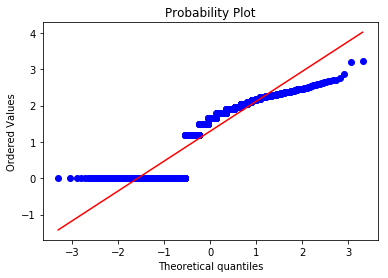

EO_Sq_log_sqrt


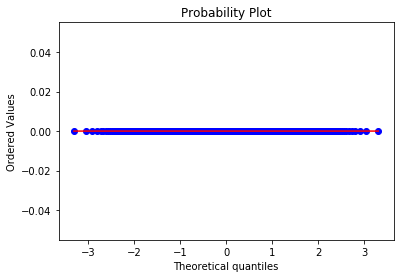

EL_Sq_log_sqrt


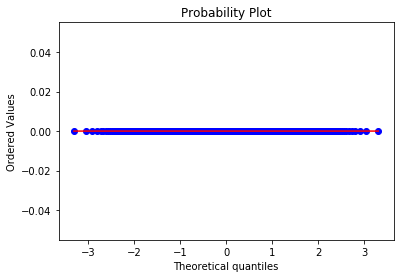

IFEP_Sq_log_sqrt


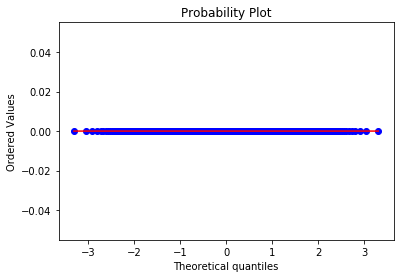

RFEP_Sq_log_sqrt


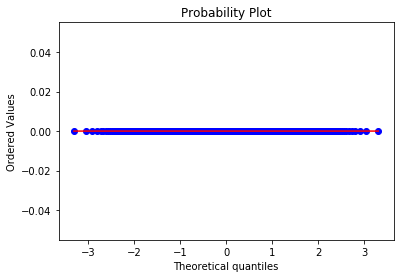

Black or African American_Sq_log_sqrt


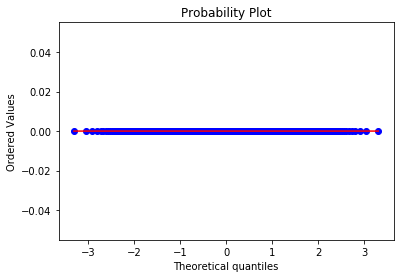

Cambodian_Sq_log_sqrt


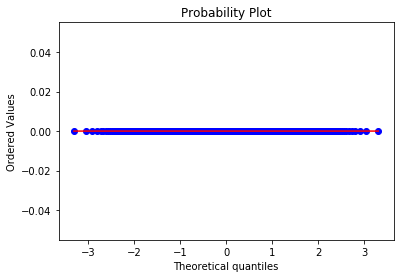

Chinese_Sq_log_sqrt


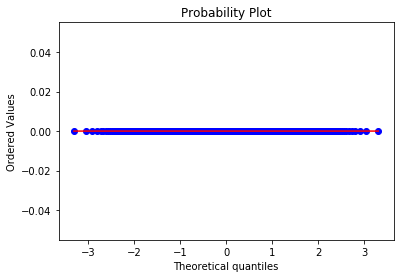

Filipino_Sq_log_sqrt


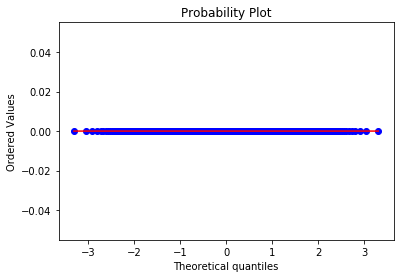

Hispanic_Sq_log_sqrt


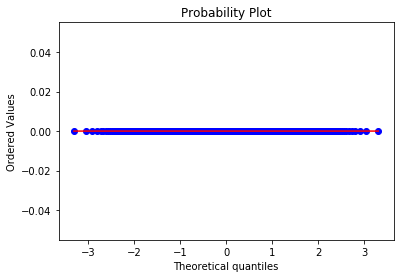

Multi_Sq_log_sqrt


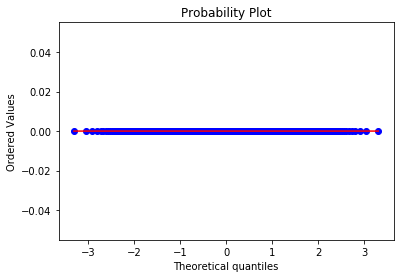

Other Pac Islander_Sq_log_sqrt


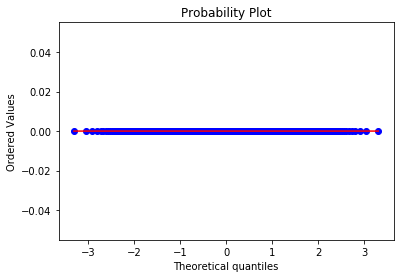

White_Sq_log_sqrt


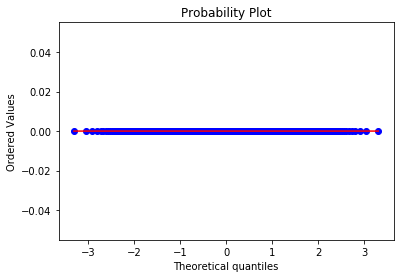

American Indian or Alaska Native_Sq_log_sqrt


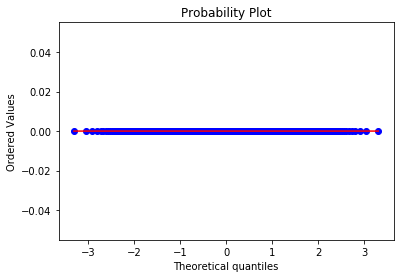

Guamanian_Sq_log_sqrt


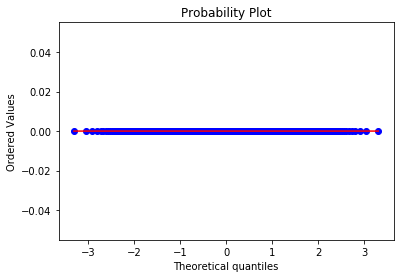

Hmong_Sq_log_sqrt


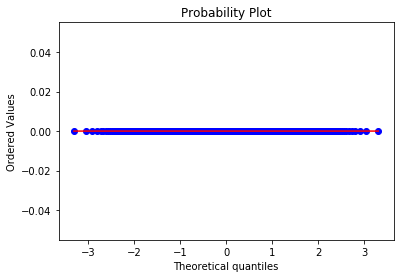

Vietnamese_Sq_log_sqrt


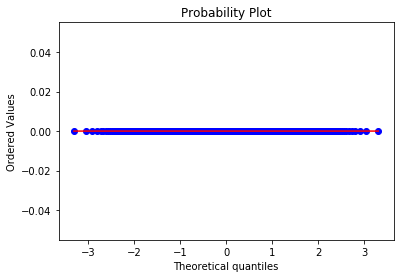

Can_Sq_log_sqrt


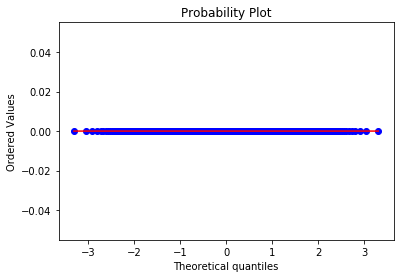

Laotian_Sq_log_sqrt


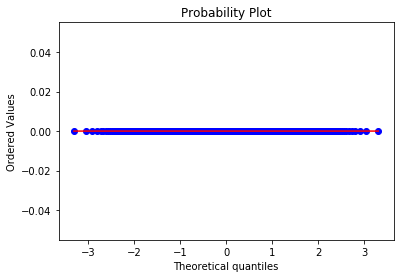

Other Asian_Sq_log_sqrt


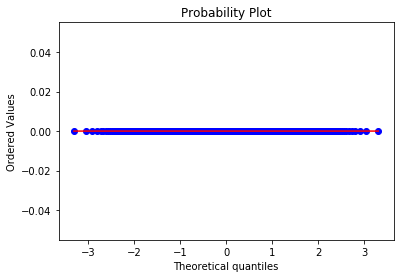

Samoan_Sq_log_sqrt


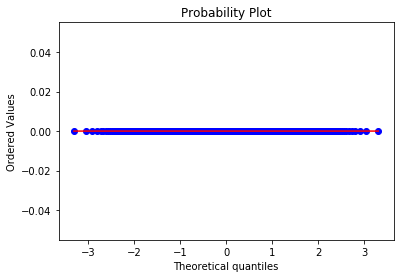

Zip_Sq_log_sqrt


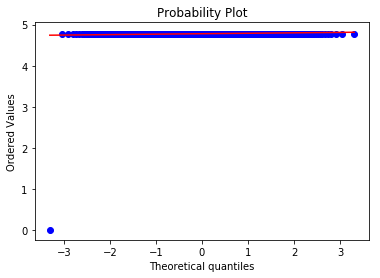

In [22]:
for x1 in X:
    print(x1)
    stats.probplot(X[x1], dist="norm", plot=pylab)
    pylab.show()

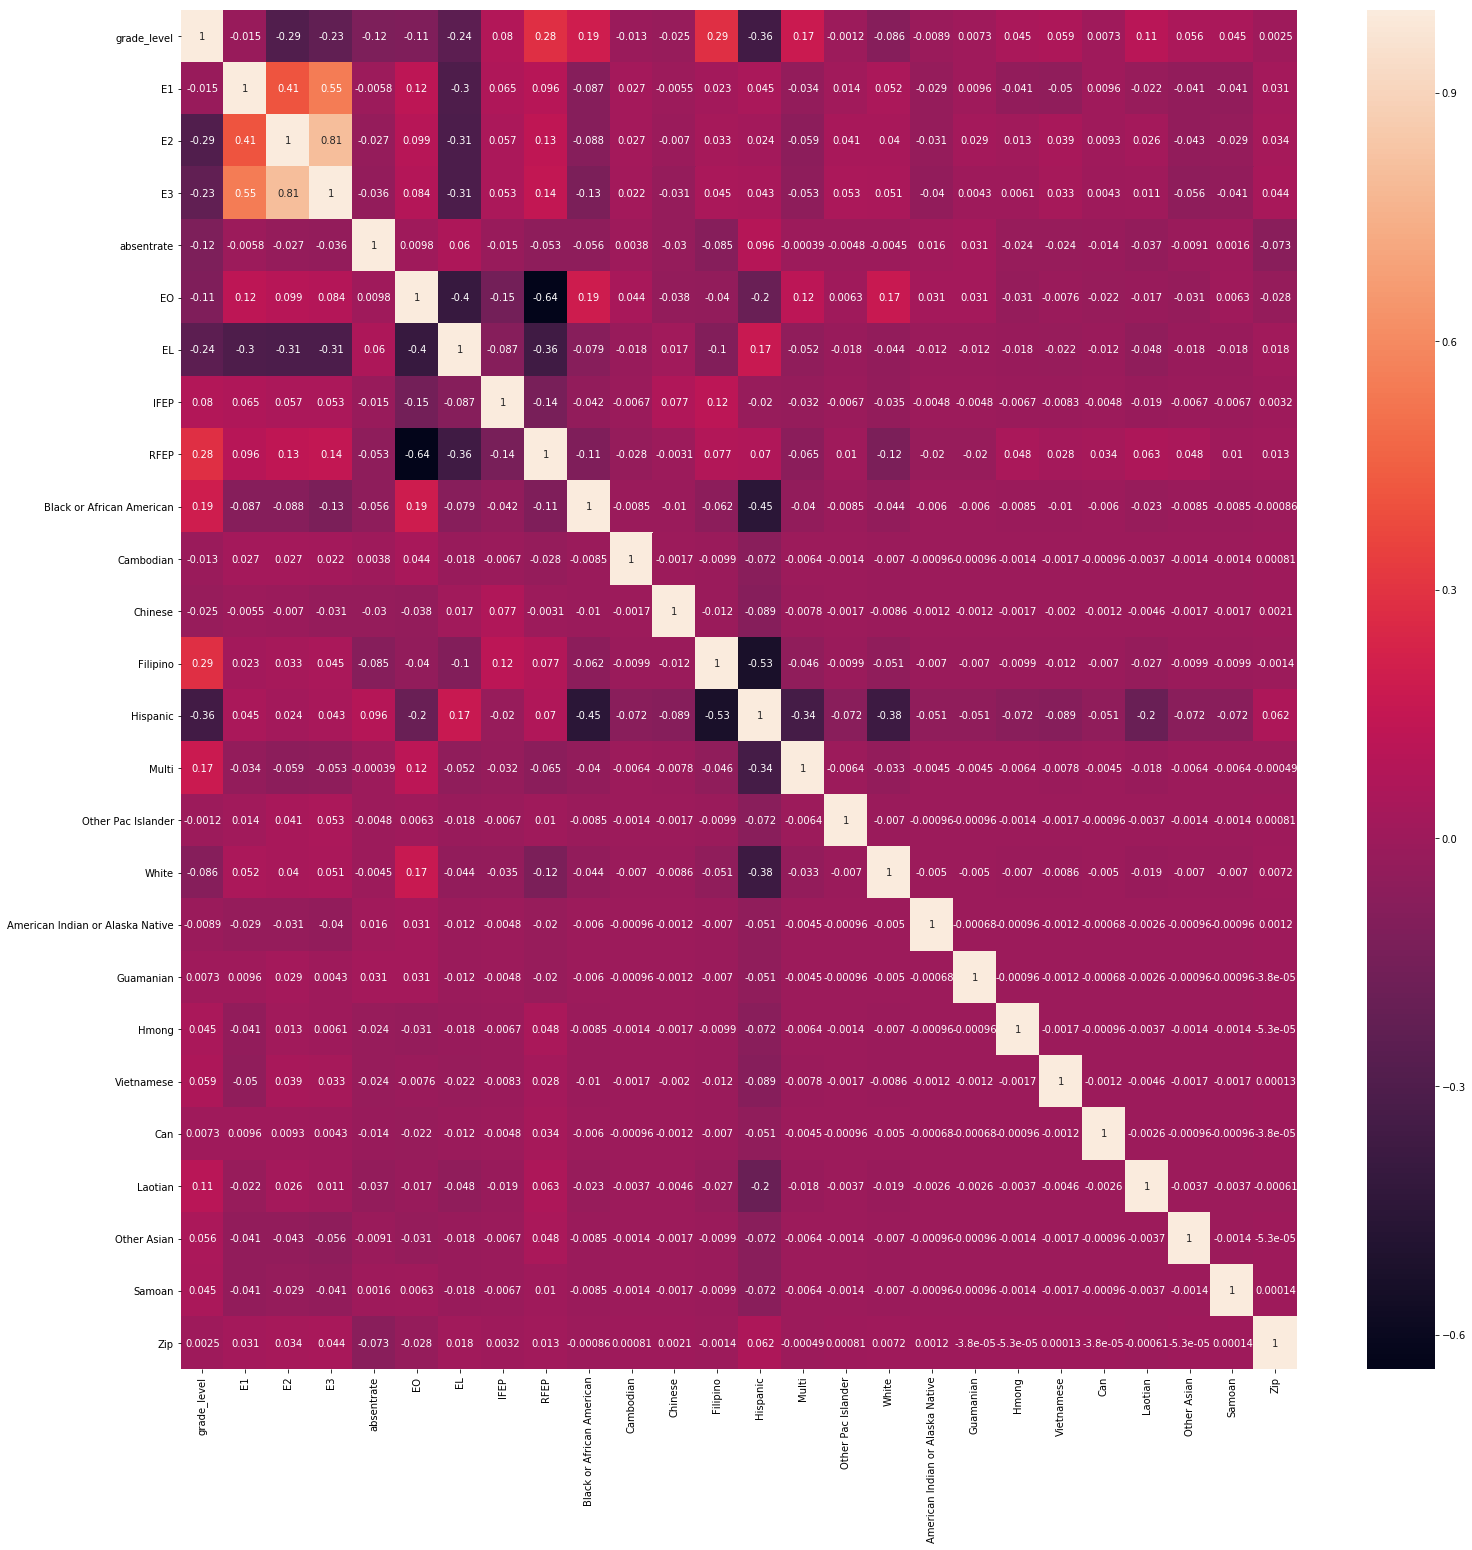

In [17]:
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(X.corr(), annot=True, ax=ax)


### There is a lot of categorical data
#### Some of it is due to converting the grades and ELA status to OHE

In [ ]:
X.columns[31]

In [ ]:
#The interesting one for me is our distribution of ELA status at the bottom. 

## Predicting inDanger Score

In [ ]:
#will start with a logistic regression as this is a classification problem

In [18]:
# Declare a logistic regression classifier.
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

#lr = ensemble.GradientBoostingClassifier(subsample=.2, n_estimators=300, max_features=2)
lr = LogisticRegression()
# Fit the model.
lr.fit(X_train, y_train)

# Display.
print('Coefficients')
print(lr.coef_)

#print(lr.intercept_)
pred_y = lr.predict(X_test)

print('\n Accuracy by E1')
print(pd.crosstab(pred_y, y_test))

print('\n Percentage accuracy')
print(lr.score(X_train, y_train))

print("Cross Val Score")
print(cross_val_score(lr,X_test,y_test,cv=10))

print("Mean Squared Error")
print(metrics.mean_squared_error(y_test, pred_y))

Coefficients
[[-1.39819370e-03 -1.26036202e-03 -7.45598323e-04 -9.02732335e-04
   6.34464141e-03 -7.12682966e-05  4.64001231e-04 -2.62441147e-05
  -3.55924453e-04 -6.21553626e-05 -3.99744964e-06 -5.94760450e-06
  -1.30640569e-04  2.12293686e-04  1.23827371e-05 -3.98711116e-06
   1.72953053e-05 -2.00920002e-06  0.00000000e+00 -3.97260947e-06
  -3.97118284e-06 -1.98847116e-06 -1.59250723e-05 -3.99070774e-06
  -4.00123367e-06 -2.56468200e-05]]

 Accuracy by E1
col_0    0   1
row_0         
0      330  40

 Percentage accuracy
0.9124548736462094
Cross Val Score
[0.89189189 0.91891892 0.89189189 0.89189189 0.89189189 0.91891892
 0.86486486 0.89189189 0.89189189 0.89189189]
Mean Squared Error
0.10810810810810811


c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

In [19]:
print(metrics.classification_report(y_test,pred_y))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       330
           1       0.00      0.00      0.00        40

   micro avg       0.89      0.89      0.89       370
   macro avg       0.45      0.50      0.47       370
weighted avg       0.80      0.89      0.84       370



c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

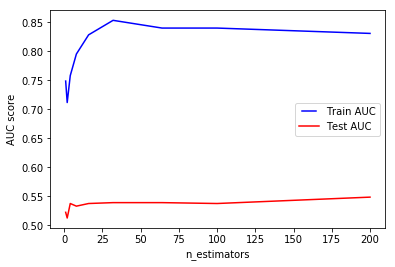

In [21]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = ensemble.RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:2

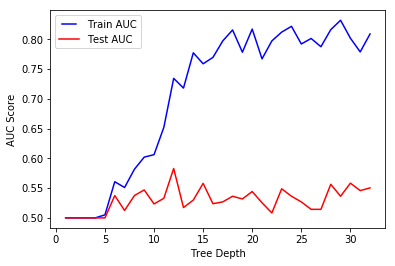

In [22]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = ensemble.RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()

c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:2

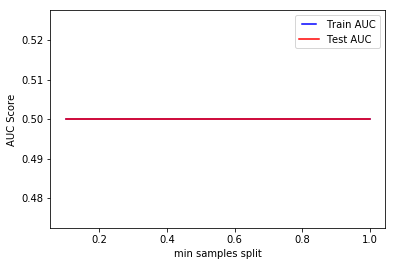

In [23]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = ensemble.RandomForestClassifier(min_samples_split=min_samples_split)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel('min samples split')
plt.show()

c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:2

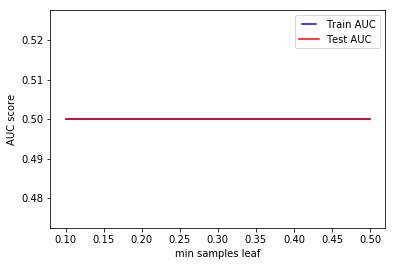

In [24]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = ensemble.RandomForestClassifier(min_samples_leaf=min_samples_leaf)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()


c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:2

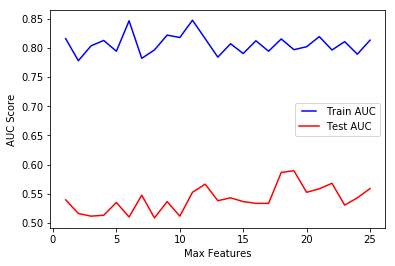

In [28]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   rf = ensemble.RandomForestClassifier(max_features=max_feature)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Max Features')
plt.show()

### Random Forest

In [29]:
#next we will look at a random forest
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier( n_estimators=250, max_depth=5, min_samples_split=.1)

rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test) 

print(rfc.score(X_train,y_train))
print('\n Accuracy by inDanger status')
print(pd.crosstab(pred_rfc, y_test))

cross_val_score(rfc,X_test, y_test,cv=10, n_jobs=-1)

0.9115523465703971

 Accuracy by inDanger status
col_0    0   1
row_0         
0      330  40


array([0.89189189, 0.89189189, 0.89189189, 0.89189189, 0.89189189,
       0.89189189, 0.86486486, 0.89189189, 0.89189189, 0.89189189])

In [30]:
print(metrics.classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       330
           1       0.00      0.00      0.00        40

   micro avg       0.89      0.89      0.89       370
   macro avg       0.45      0.50      0.47       370
weighted avg       0.80      0.89      0.84       370



c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SVM

In [31]:
#Linear SVC
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)
#predictions
predsvc = svc.predict(X_test)

print(svc.score(X_train,y_train))
print('\n Accuracy by ela status')
print(pd.crosstab(predsvc, y_test))

cross_val_score(svc,X_test, y_test,cv=10)


c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

0.9097472924187726

 Accuracy by ela status
col_0    0   1
row_0         
0      329  40
1        1   0


c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([0.89189189, 0.89189189, 0.89189189, 0.89189189, 0.89189189,
       0.89189189, 0.89189189, 0.89189189, 0.89189189, 0.89189189])

In [32]:
print(metrics.classification_report(y_test,predsvc))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       330
           1       0.00      0.00      0.00        40

   micro avg       0.89      0.89      0.89       370
   macro avg       0.45      0.50      0.47       370
weighted avg       0.80      0.89      0.84       370



## Mixed Model

In [34]:
data["absentrate"] = data["Days Absent 2018-2019"]
#create our X variable
mainSet = data[["student_number","grade_level", "absentrate", "E1", "E2", 'E3'
         , "M1", "M2", "M3", "Zip", "CurEngGrade", "CurMathGrade", "EO", "EL", "IFEP", "RFEP", "Black or African American",
           "Cambodian", "Chinese", "Filipino", "Hispanic", "Multi", "Other Pac Islander", "White", "American Indian or Alaska Native",
             'Guamanian', 'Hmong','Vietnamese', 'Can', 'Laotian', 'Other Asian', 'Samoan' ]]

 
#"CurEngGrade"
X = mainSet[["student_number","grade_level","E1","E2", "E3", "absentrate", "EO", "EL", "IFEP", "RFEP","Black or African American",
           "Cambodian", "Chinese", "Filipino", "Hispanic", "Multi", "Other Pac Islander", "White", "American Indian or Alaska Native",
             'Guamanian', 'Hmong','Vietnamese', 'Can', 'Laotian', 'Other Asian', 'Samoan']]

#clean up 
X["E1"] = np.where(X["E1"] == ' ', 0, X["E1"]).astype("int")

X["E2"] = np.where(X["E2"] == ' ', 0, X["E2"]).astype("int")

X["E3"] = np.where(X["E3"] == ' ', 0, X["E3"]).astype("int")


#brought this up because of the loops below that pollute the df with E1
y = X["E1"]
X = X.drop("E1", axis=1)


#squared
for x1 in X:
    X[x1 +"_Sq"] = X[x1] ** 2

#log
def getlog(x):
    if x > 0:
        return math.log(x)
    else:
        return x
 
for x2 in X:
    X[x2 + "_log"] = X[x2].apply(getlog)

#square root
def squareroot(x):
    if x > 1:
        return math.sqrt(x)
    else:
        return x

for x3 in X:
    X[x3 + "_sqrt"] = X[x3].apply(squareroot)    


X["inDanger"] = np.where(mainSet["CurEngGrade"] >= 4, 1, 0).astype('int')




c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [35]:
#clean up the spaces in some areas
y = np.where(y == ' ', 0, y).astype("int")

#X["E1"] = np.where(X["E1"] == ' ', 0, X["E1"]).astype("int")

#X["E2"] = np.where(X["E2"] == ' ', 0, X["E2"]).astype("int")

#X["E3"] = np.where(X["E3"] == ' ', 0, X["E3"]).astype("int")

#X["M1"] = np.where(X["M1"] == ' ', 0, X["M1"]).astype("int")

#X["M2"] = np.where(X["M2"] == ' ', 0, X["M2"]).astype("int")

#X["M3"] = np.where(X["M3"] == ' ', 0, X["M3"]).astype("int")

In [36]:
# Multilevel models expect data in a long format, with multiple rows per person.  Restructing data:
E_long=pd.wide_to_long(X, ['E',], i='student_number', j='Year')
E_long=E_long.reset_index()
print(E_long.head())

E_long=E_long.dropna()

# Multilevel models expect data in a long format, with multiple rows per person.  Restructing data:
#M_long=pd.wide_to_long(X, ['M',], i='student_number', j='Year')
#M_long=M_long.reset_index()
#print(M_long.head())

#M_long=M_long.dropna()

   student_number  Year  Vietnamese_Sq_sqrt  absentrate_Sq  Laotian_Sq  \
0         1021777     2                   0              0           0   
1         1020537     2                   0              1           0   
2         1023536     2                   0              4           0   
3         1021353     2                   0            121           0   
4         1022551     2                   0             25           0   

   Guamanian_Sq  grade_level_Sq_log_sqrt  Can_Sq_sqrt  Guamanian_log_sqrt  \
0             0                 1.893018            0                 0.0   
1             0                 1.893018            0                 0.0   
2             0                 1.893018            0                 0.0   
3             0                 1.893018            0                 0.0   
4             0                 1.893018            0                 0.0   

   Samoan_Sq_log_sqrt  ...  White_log_sqrt  E2_Sq_log  \
0                 0.0  ...         

Absent Rate
Mean: 5.62381596752368
Median: 4.0
Max: 180
Min: 0


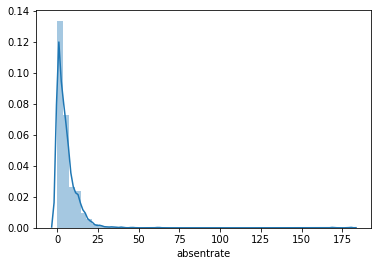

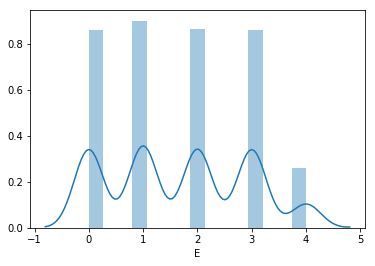

In [37]:
# Getting a sense for the data

# Checking the distributions: Is the outcome normally distributed, or close to it?
print("Absent Rate")
print("Mean:",E_long["absentrate"].mean())
print("Median:",E_long["absentrate"].median())
print("Max:",E_long["absentrate"].max())
print("Min:",E_long["absentrate"].min())

"Absent Rate"
sns.distplot(E_long["absentrate"])
plt.show()


"E"
sns.distplot(E_long["E"])
plt.show()
#E_long["M1"].hist()
#plt.show()



In [38]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("inDanger ~ 1", E_long, groups=E_long["student_number"])

mdf = md.fit()

print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: inDanger  
No. Observations: 2956    Method:             REML      
No. Groups:       1478    Scale:              0.0000    
Min. group size:  2       Likelihood:         16201.0370
Max. group size:  2       Converged:          Yes       
Mean group size:  2.0                                   
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  0.093     0.005  17.445  0.000   0.083   0.104
Group Var  0.042   447.112                               



In [39]:
print('running random intercept model')
ri_model = smf.mixedlm("E ~ inDanger",data=E_long,groups=E_long["student_number"])
ri_result = ri_model.fit(method='nm',maxiter=200, full_output=True)
print(ri_result.summary())
print("done!")

# Function to calculate the intraclass correlation
def ICC(fittedmodel):
    between_var= fittedmodel.cov_re.iloc[0,0]
    resid=fittedmodel.scale
    icc=between_var/(between_var+resid)
    return icc

print('The Intraclass Correlation is: {}'.format(ICC(ri_result)))

running random intercept model
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: E         
No. Observations: 2956    Method:             REML      
No. Groups:       1478    Scale:              0.3397    
Min. group size:  2       Likelihood:         -4147.9601
Max. group size:  2       Converged:          Yes       
Mean group size:  2.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.705    0.032 53.194 0.000  1.642  1.768
inDanger      -0.386    0.105 -3.683 0.000 -0.592 -0.181
Group Var      1.207    0.123                           

done!
The Intraclass Correlation is: 0.7804216133444147


In [40]:
print('running random slopes model')
rs_model = smf.mixedlm("inDanger ~ E",data=E_long,groups=E_long["student_number"], re_formula="~0+Year")
rs_result = rs_model.fit(method='nm',maxiter=200, full_output=True)
print(rs_result.summary())
print("done!")

print('running random intercept and random slopes model')
ris_model = smf.mixedlm("inDanger ~ E",data=E_long,groups=E_long["student_number"], re_formula="~Year")
ris_result = ris_model.fit(method='nm', maxiter=200, full_output=True)
print(ris_result.summary())
print("done!")

running random slopes model
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: inDanger
No. Observations: 2956    Method:             REML    
No. Groups:       1478    Scale:              0.0065  
Min. group size:  2       Likelihood:         859.4629
Max. group size:  2       Converged:          Yes     
Mean group size:  2.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.100    0.007 15.267 0.000  0.087  0.112
E           -0.005    0.003 -1.667 0.096 -0.010  0.001
Year Var     0.012    0.008                           

done!
running random intercept and random slopes model


c:\users\sakok\miniconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\users\sakok\miniconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: inDanger  
No. Observations:   2956    Method:             REML      
No. Groups:         1478    Scale:              0.0000    
Min. group size:    2       Likelihood:         20606.4818
Max. group size:    2       Converged:          Yes       
Mean group size:    2.0                                   
----------------------------------------------------------
                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.093    0.005 17.442 0.000  0.083  0.104
E                0.000    0.000  0.026 0.979 -0.000  0.000
Group Var        0.042 8917.457                           
Group x Year Cov 0.000    0.008                           
Year Var         0.000                                    

done!


c:\users\sakok\miniconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [41]:
from scipy.stats import chi2

def likelihood_ratio_test(bigmodel, smallmodel):
    likelihoodratio=2*(bigmodel.llf-smallmodel.llf)
    df=bigmodel.df_modelwc-smallmodel.df_modelwc
    p=chi2.sf(likelihoodratio, df)
    return p


lrt=likelihood_ratio_test(ris_result,rs_result)
print('The p-value for the likelihood ratio test of the random intercept and random intercept/slope models is: {}'.format(lrt))

The p-value for the likelihood ratio test of the random intercept and random intercept/slope models is: 0.0


### Moving forward

We definitely need a bit more data so that not so many nulls need to be filled. I felt that that could have definitely been a factor. There is good accuracy, but the sensitivity can be better for me. In this case, I believe I would move forward with the SVM 

As far as production goes, I'm not sure, to be honest. There are a few possible avenues. I may explore Azure's ML studio and build an api that can be rolled out. I can house the pipeline and build the reports/dashboards for schools that way. This course didn't really deal with production so it's something that I will need to explore further.